In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import display
import dataloader
from dataloader import ThermalData
import clustering
import anomaly_detection

In [4]:
import module_extraction
#from module_extraction import Filters, Modules
from module_extraction_ortho import Filters, Modules

In [5]:
input_img_path = "./images/ortho/1466.tif"

In [6]:
input_dir_path = "./outputs/"+input_img_path.split("/")[-1][:-4]
print(input_dir_path)

./outputs/1466


画像データの取得

In [7]:
thermal_img_files = dataloader.get_img_files(dir_path=input_dir_path+"/modules",gray=False)

In [8]:
type(thermal_img_files), len(thermal_img_files)

(dict, 5216)

In [9]:
img_org = cv2.imread(input_img_path, 0)

モジュール情報の取得

In [10]:
import pickle
with open(input_dir_path+'/module_contours.pkl', 'rb') as pkl:
    module_contours = pickle.load(pkl)
#with open(input_dir_path+'/module_labels.pkl', 'rb') as pkl:
with open(input_dir_path+'/module_labels_split.pkl', 'rb') as pkl:
    module_labels = pickle.load(pkl)

温度分布の確認

In [11]:
data = ThermalData(thermal_img_files, scale_type="individual")

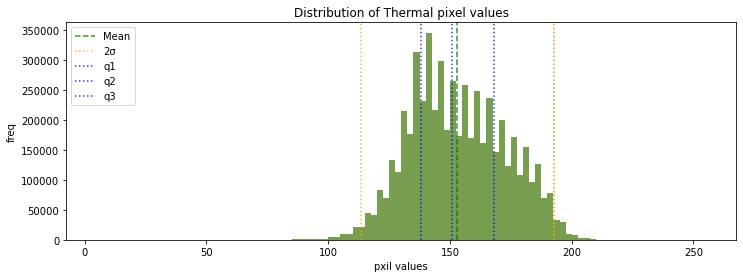

In [12]:
display.display_distributions(data.all_temperature, 
                              filepath = "hist_all_temperature.jpg")

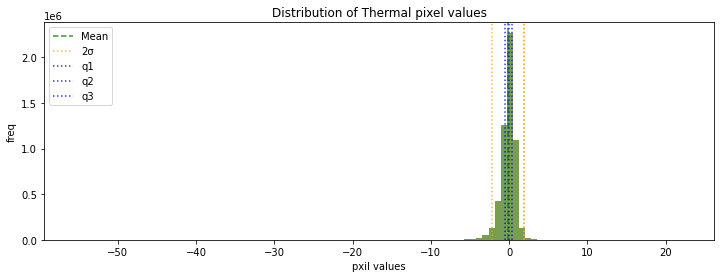

In [13]:
display.display_distributions(data.scaled_all_temperature,
                              filepath = "hist_scaled_all_temperature.jpg")

In [14]:
def gamma_correction(x, gamma=1):
    return np.clip(pow(x / 255.0, gamma) * 255.0, 0, 255).astype(int)

温度分布の確認（アレイごと）

In [15]:
from sklearn import preprocessing

No handles with labels found to put in legend.


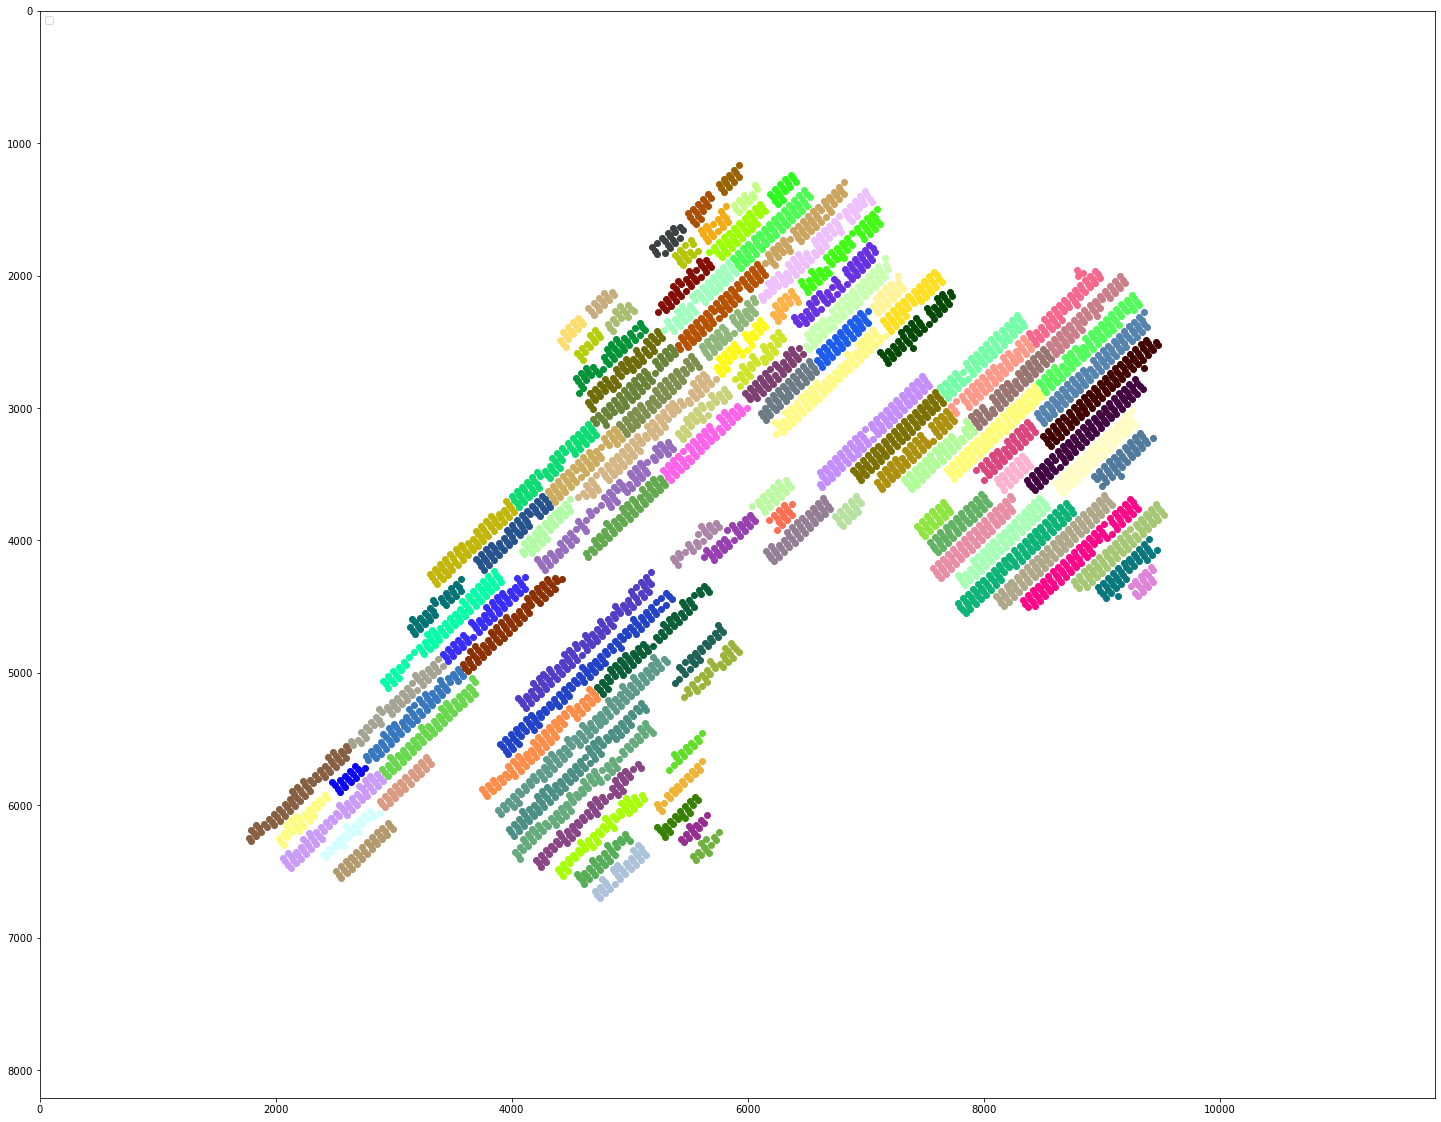

In [16]:
fig, ax = plt.subplots(facecolor="w", figsize=(25,20))
#cmap = plt.get_cmap("tab20")
colors = list(matplotlib.colors.XKCD_COLORS.items())[:max(module_labels)+1]
module_centers = np.array( [c.mean(axis=0) for c in module_contours] )
for i in range(-1,max(module_labels)+1):
    centers = module_centers[module_labels == i]
    plt.scatter(centers[:, 0], centers[:, 1], color=colors[i][1])
#plt.scatter(module_centers[:, 0], module_centers[:, 1], color=cmap(module_labels+1), label=)
ax.legend(loc='upper left')
ax.set_xlim([0, img_org.shape[1]])
ax.set_ylim([img_org.shape[0], 0])
plt.show()

In [17]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [18]:
# This will be implemented in ThermalData class
data_array = {}; array_zscaler= {}; 
for c in range(0,max(module_labels)+1):
    indices = np.where(module_labels==c)
    np.where(module_labels==c)
    target_thermal_img_files = pd.Series(thermal_img_files).iloc[indices]
    data_array[c] = ThermalData(target_thermal_img_files, scale_type="individual")
    rscaler = preprocessing.RobustScaler()
    array_zscaler[c] = rscaler.fit(data_array[c].all_temperature)

In [19]:
clustering_method="kmeans"
#clustering_method="xmeans" # not stable
#clustering_method="dbscan"

In [20]:
# clusters temperature 
array_clusters_temperature = {}
for c in range(0,max(module_labels)+1):
    tmp = []
    print("array:", c)
    print("--> generate clusters temperature")
    # -- clustering --
    for k, v in data_array[c].scaled_temperature_with_index.items():
        clusters = clustering.TemperatureClusters(v, method=clustering_method)  
        sliced_data = clusters.get_clusters_data(data_array[c].temperature[k])   
        original_clusters_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in sliced_data])
        tmp.append(original_clusters_temperature)
    array_clusters_temperature[c] = np.vstack(tmp)

array: 0
--> generate clusters temperature
array: 1
--> generate clusters temperature
array: 2
--> generate clusters temperature
array: 3
--> generate clusters temperature
array: 4
--> generate clusters temperature
array: 5
--> generate clusters temperature
array: 6
--> generate clusters temperature
array: 7
--> generate clusters temperature
array: 8
--> generate clusters temperature
array: 9
--> generate clusters temperature
array: 10
--> generate clusters temperature
array: 11
--> generate clusters temperature
array: 12
--> generate clusters temperature
array: 13
--> generate clusters temperature
array: 14
--> generate clusters temperature
array: 15
--> generate clusters temperature
array: 16
--> generate clusters temperature
array: 17
--> generate clusters temperature
array: 18
--> generate clusters temperature
array: 19
--> generate clusters temperature
array: 20
--> generate clusters temperature
array: 21
--> generate clusters temperature
array: 22
--> generate clusters temperatur

In [65]:
# clf models
gamma = 3.0
array_zscaler_cluster = {}; 
array_lof_normal = {}; array_lof_gamma = {}; 
array_isof_normal = {}; array_isof_gamma = {};
for c in range(0,max(module_labels)+1):
    print("array:", c)
    n_modules = len(data_array[c].temperature)
    # -- Zscaler --
    rscaler = preprocessing.RobustScaler()
    array_zscaler_cluster[c] = rscaler.fit(array_clusters_temperature[c])
    # -- Local Outlier Factor --
    lof_normal = LocalOutlierFactor(n_neighbors=n_modules, contamination="auto", novelty=True)
    lof_gamma = LocalOutlierFactor(n_neighbors=n_modules, contamination="auto", novelty=True)
    array_lof_normal[c] = lof_normal.fit(array_clusters_temperature[c])
    array_lof_normal[c].offset_ = -2.0 # default: -1.5            
    array_lof_gamma[c] = lof_gamma.fit(
        gamma_correction(array_clusters_temperature[c], gamma=gamma))
    array_lof_gamma[c].offset_ = -2.0 # default: -1.5    
    # -- Isolation Forest --
    isof_normal = IsolationForest(contamination="auto")
    isof_gamma = IsolationForest(contamination="auto")
    array_isof_normal[c] = isof_normal.fit(array_clusters_temperature[c])
    array_isof_normal[c].offset_ = -0.7 # default: -0.5    
    array_isof_gamma[c] = isof_gamma.fit(
        gamma_correction(array_clusters_temperature[c], gamma=gamma))                
    array_isof_gamma[c].offset_ = -0.7 # default: -0.5

array: 0
array: 1
array: 2
array: 3
array: 4
array: 5
array: 6
array: 7
array: 8
array: 9
array: 10
array: 11
array: 12
array: 13
array: 14
array: 15
array: 16
array: 17
array: 18
array: 19
array: 20
array: 21
array: 22
array: 23
array: 24
array: 25
array: 26
array: 27
array: 28
array: 29
array: 30
array: 31
array: 32
array: 33
array: 34
array: 35
array: 36
array: 37
array: 38
array: 39
array: 40
array: 41
array: 42
array: 43
array: 44
array: 45
array: 46
array: 47
array: 48
array: 49
array: 50
array: 51
array: 52
array: 53
array: 54
array: 55
array: 56
array: 57
array: 58
array: 59
array: 60
array: 61
array: 62
array: 63
array: 64
array: 65
array: 66
array: 67
array: 68
array: 69
array: 70
array: 71
array: 72
array: 73
array: 74
array: 75
array: 76
array: 77
array: 78
array: 79
array: 80
array: 81
array: 82
array: 83
array: 84
array: 85
array: 86
array: 87
array: 88
array: 89
array: 90
array: 91
array: 92
array: 93
array: 94
array: 95
array: 96
array: 97
array: 98
array: 99
array: 100

In [22]:
def check_pred_labels(model_normal, model_gamma):
    cmap = plt.get_cmap("tab20")
    for c in range(0,max(module_labels)+1):
        print("array:", c)
        fig = plt.figure(facecolor="w", figsize=(12,4))
        ax1 = fig.add_subplot(1,2,1)
        ax2 = fig.add_subplot(1,2,2)
        X1 = array_clusters_temperature[c]
        X2 = gamma_correction(array_clusters_temperature[c], gamma=gamma)
        pred1 = model_normal[c].predict(X1)
        pred2 = model_gamma[c].predict(X2)
        ax1.set_title("Normal")
        ax2.set_title("Gamma")
        ax1.scatter(X1[:, 0], X1[:, 1], color=cmap(pred1+1))
        ax2.scatter(X2[:, 0], X2[:, 1], color=cmap(pred2+1))
        plt.show()

array: 0


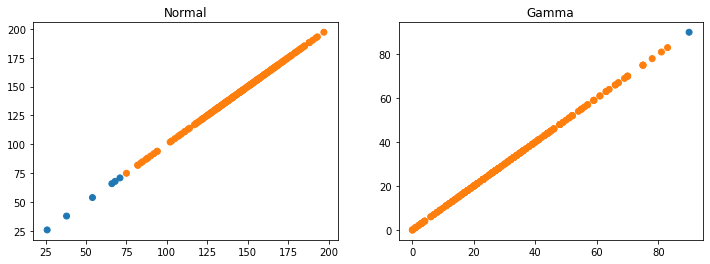

array: 1


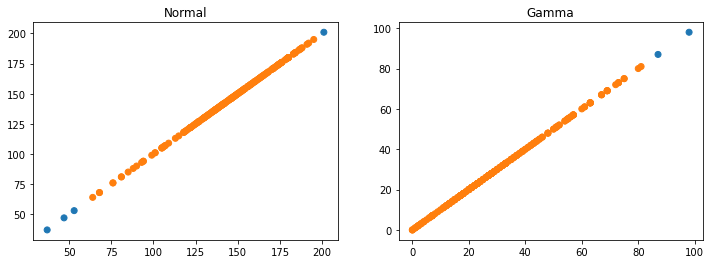

array: 2


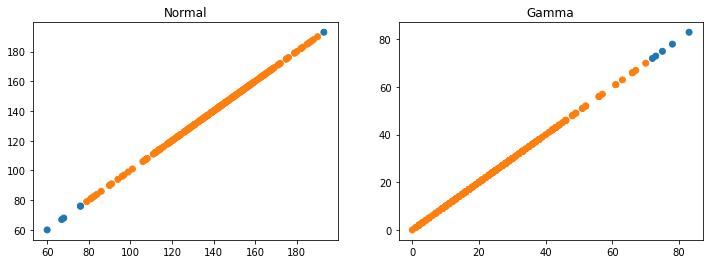

array: 3


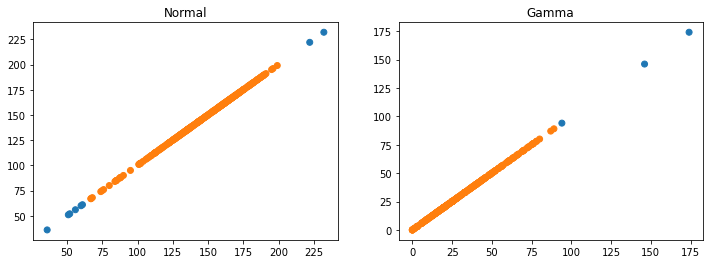

array: 4


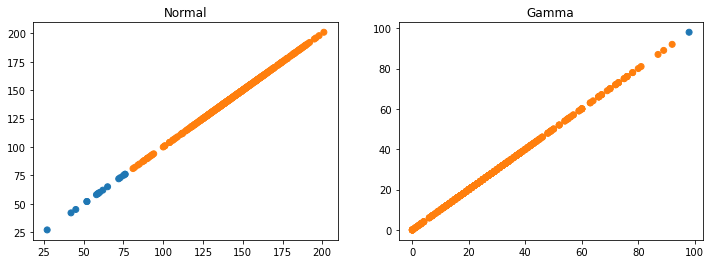

array: 5


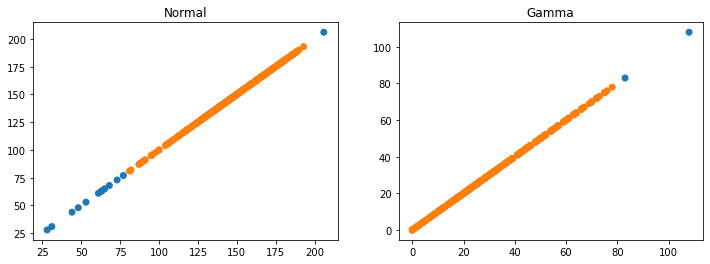

array: 6


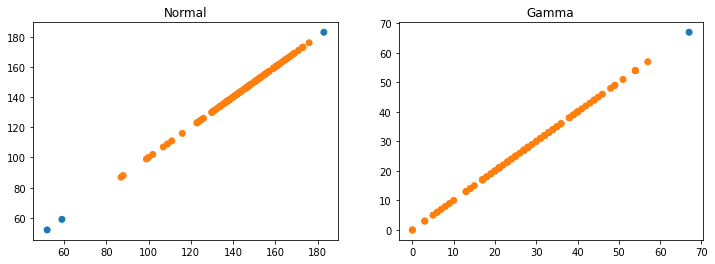

array: 7


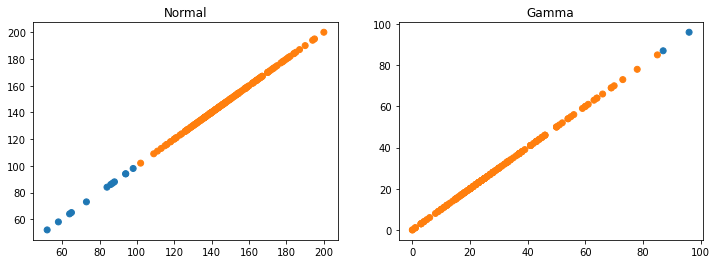

array: 8


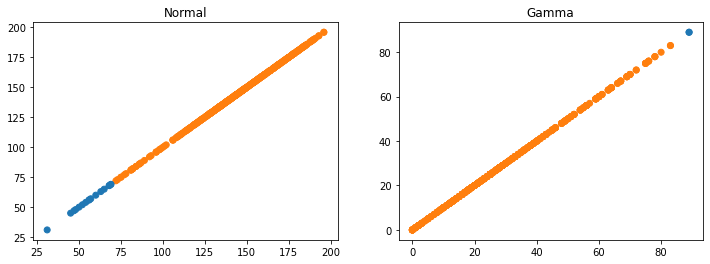

array: 9


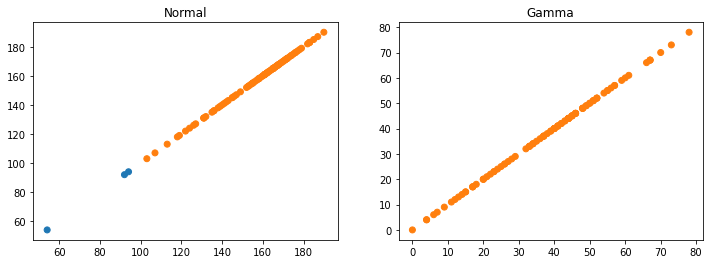

array: 10


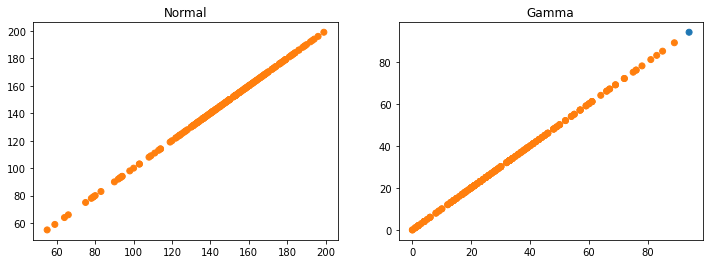

array: 11


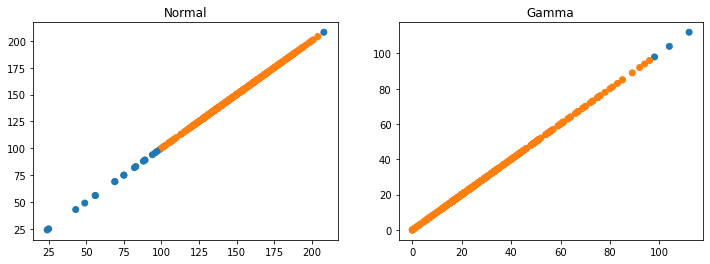

array: 12


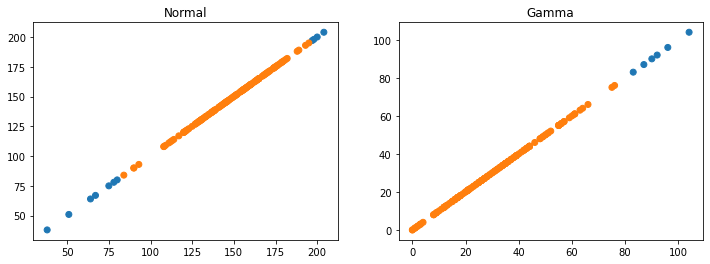

array: 13


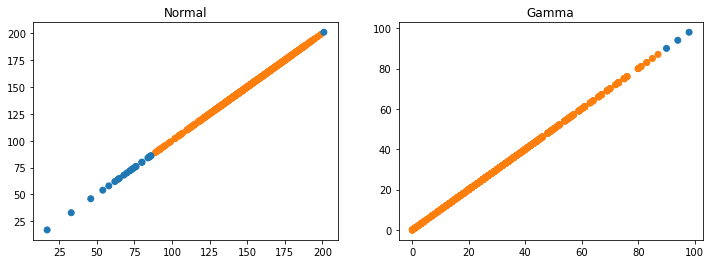

array: 14


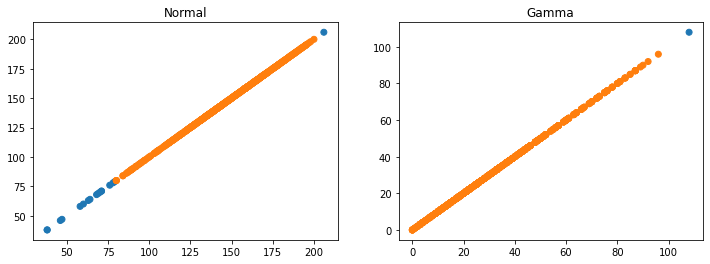

array: 15


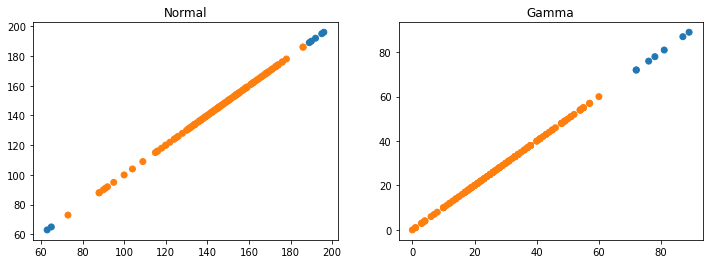

array: 16


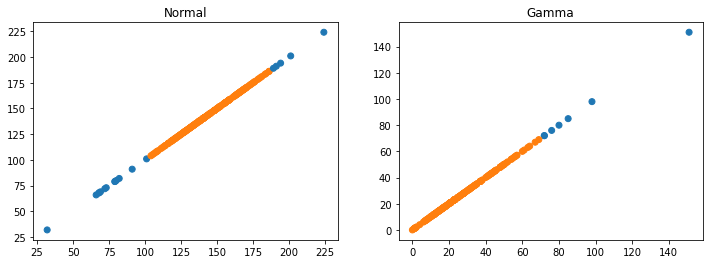

array: 17


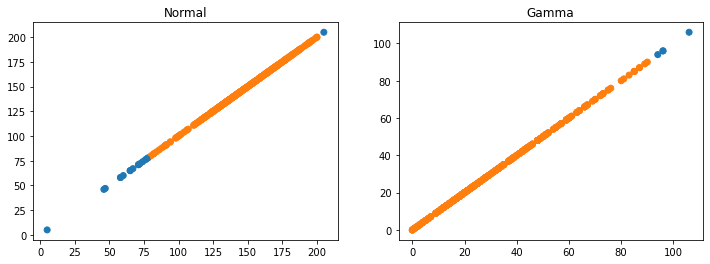

array: 18


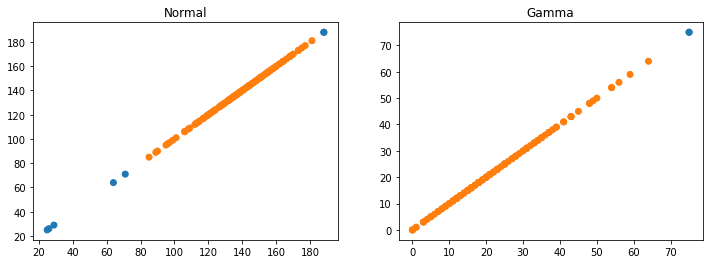

array: 19


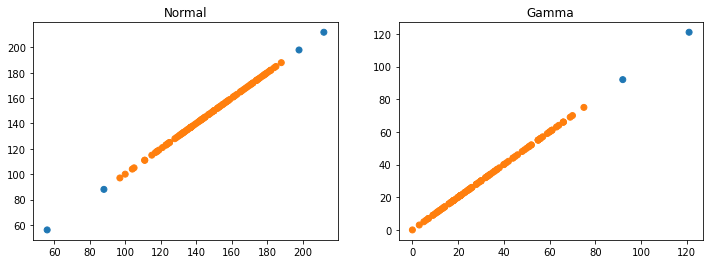

array: 20


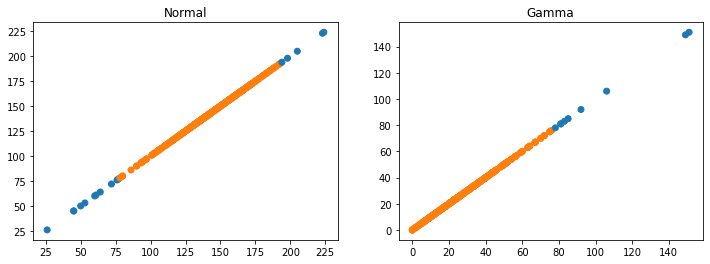

array: 21


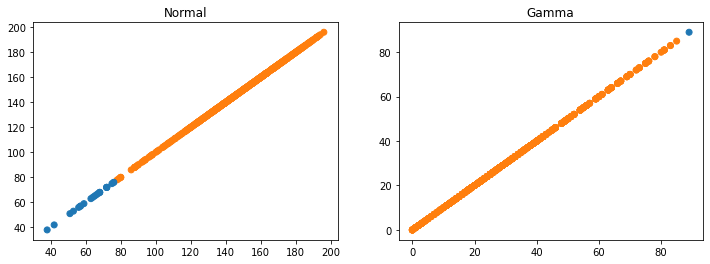

array: 22


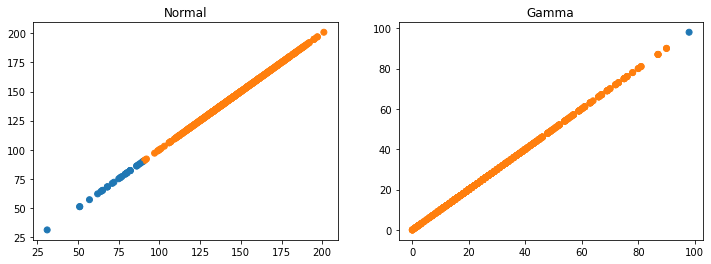

array: 23


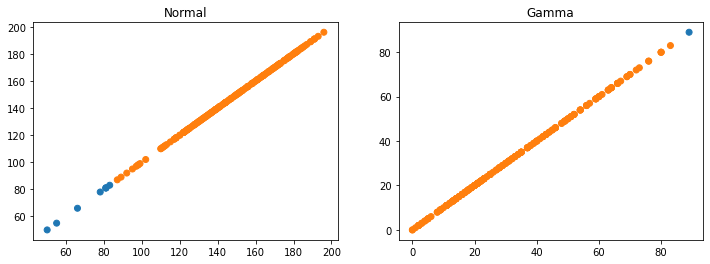

array: 24


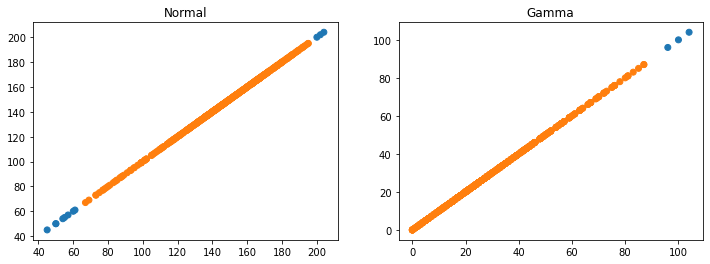

array: 25


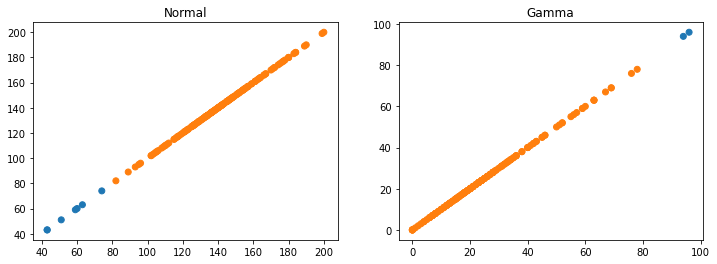

array: 26


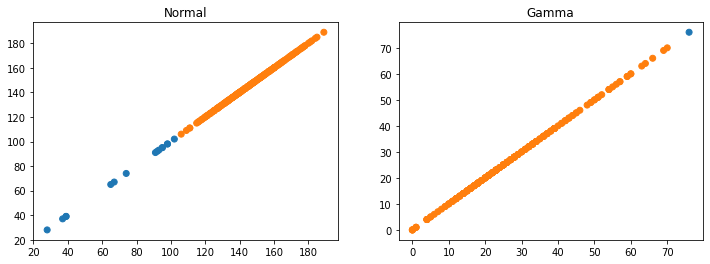

array: 27


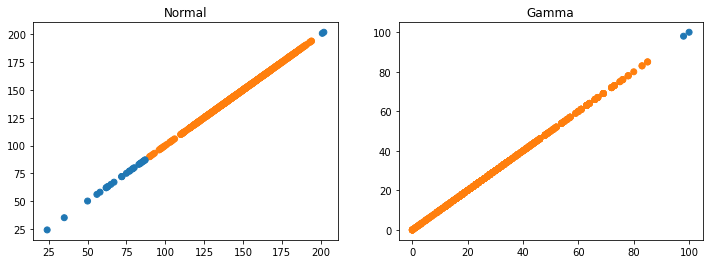

array: 28


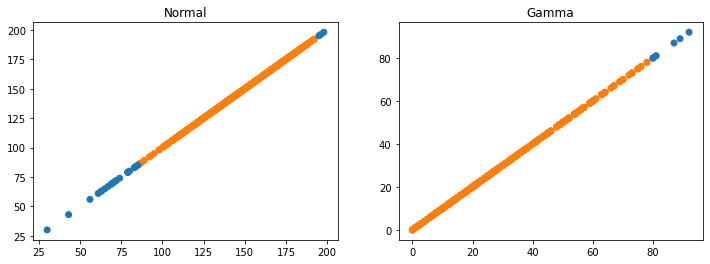

array: 29


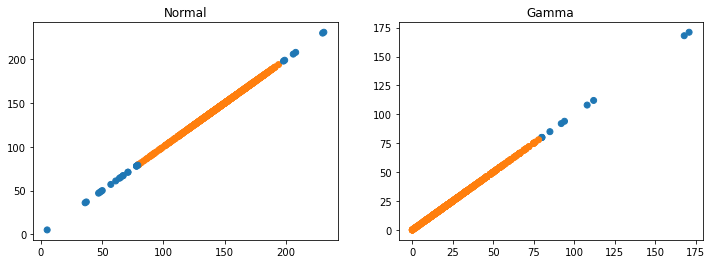

array: 30


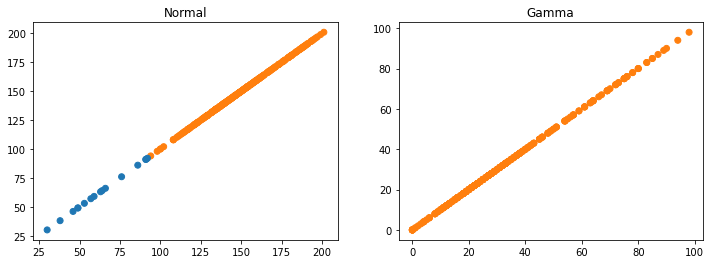

array: 31


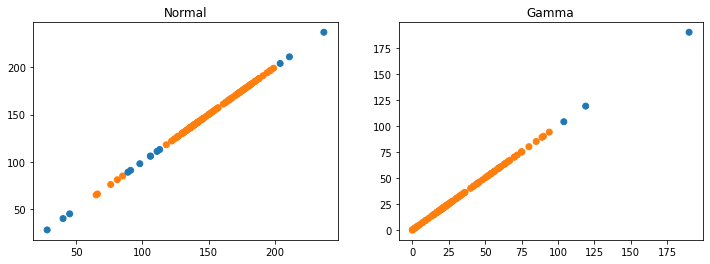

array: 32


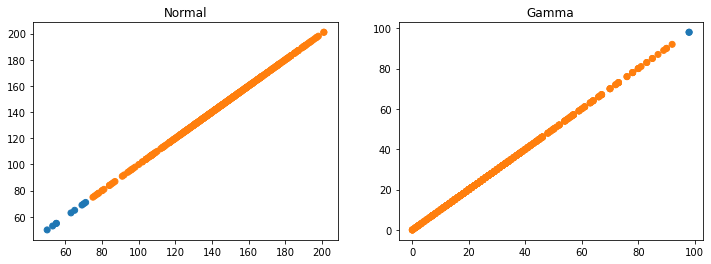

array: 33


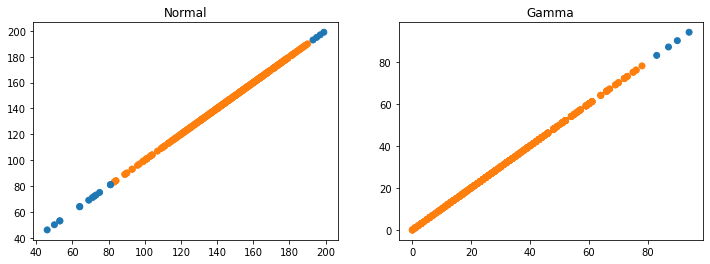

array: 34


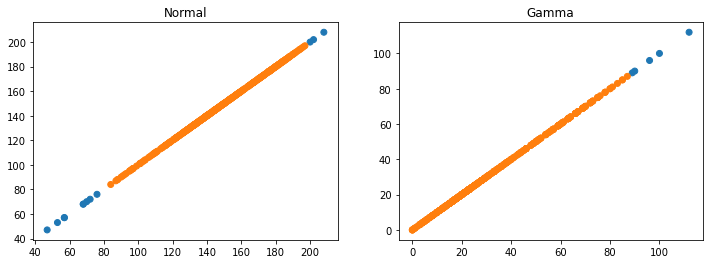

array: 35


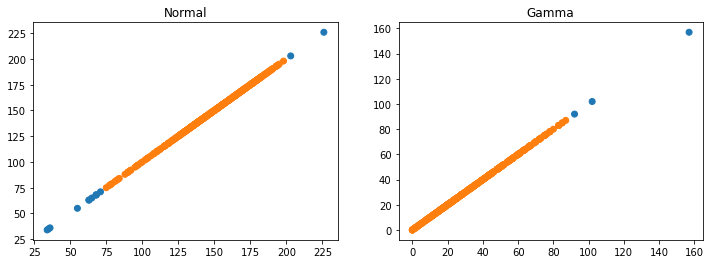

array: 36


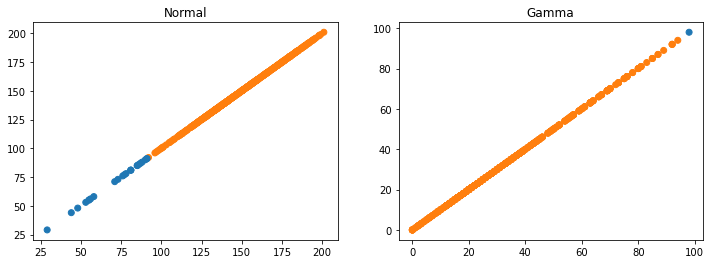

array: 37


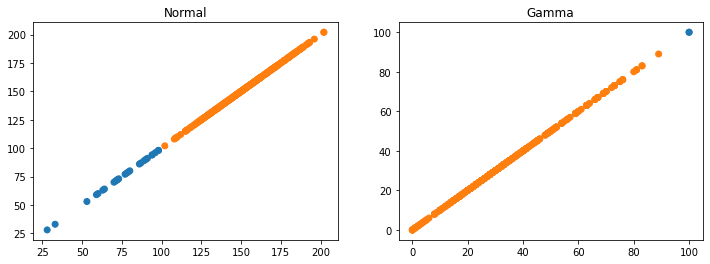

array: 38


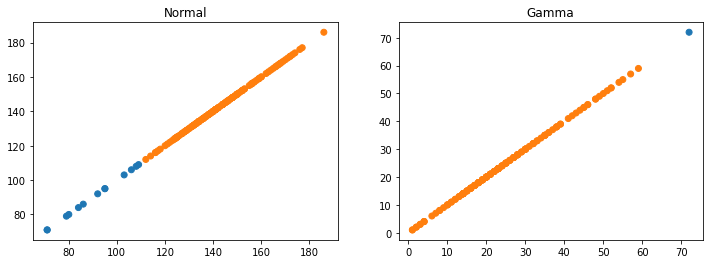

array: 39


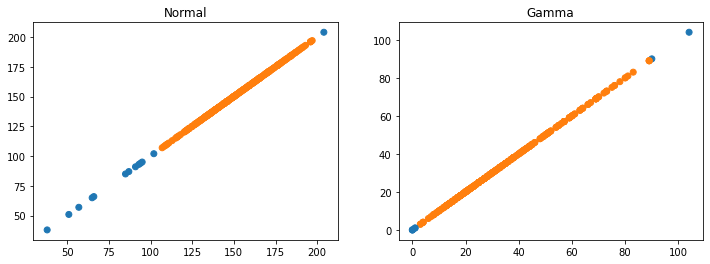

array: 40


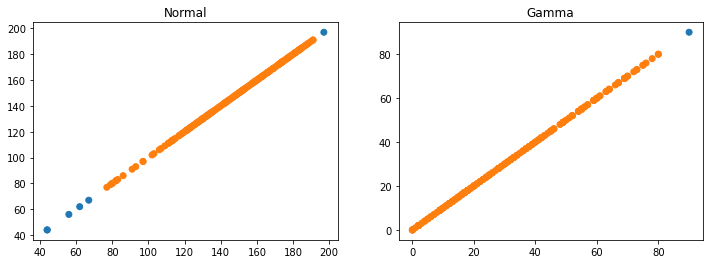

array: 41


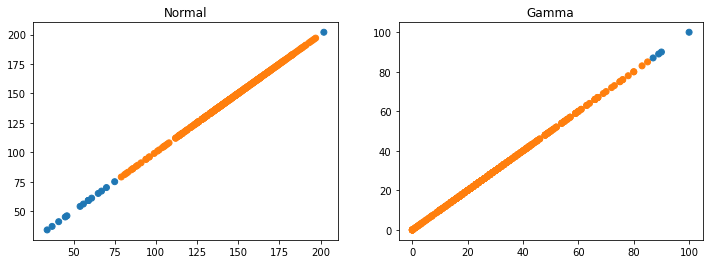

array: 42


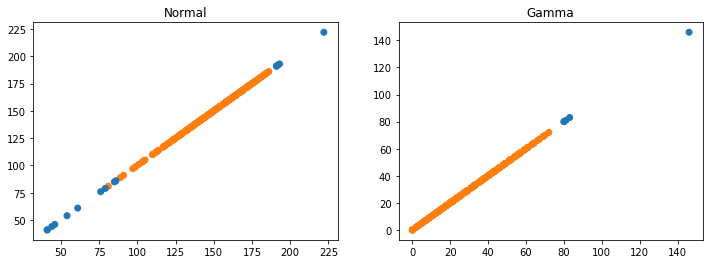

array: 43


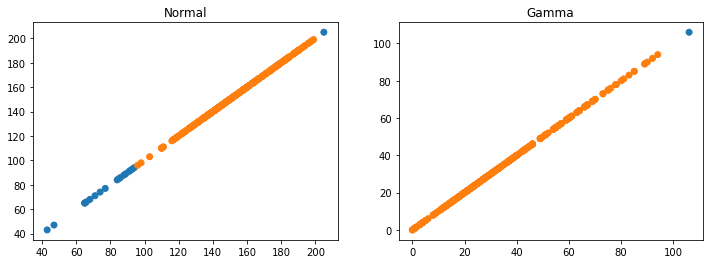

array: 44


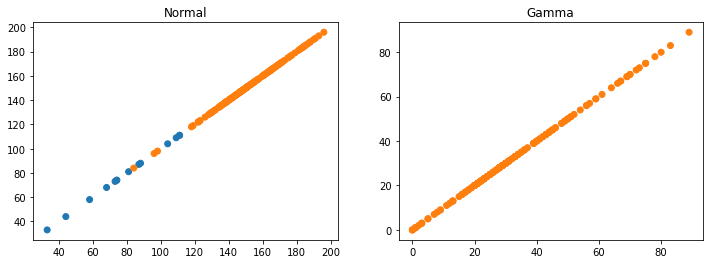

array: 45


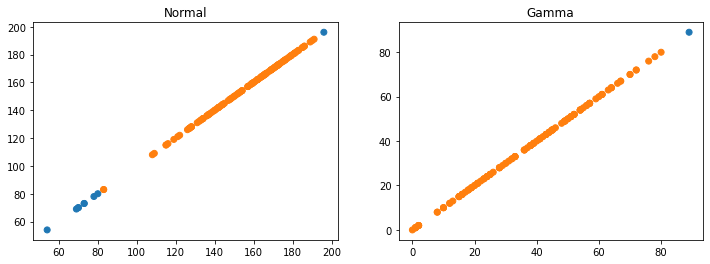

array: 46


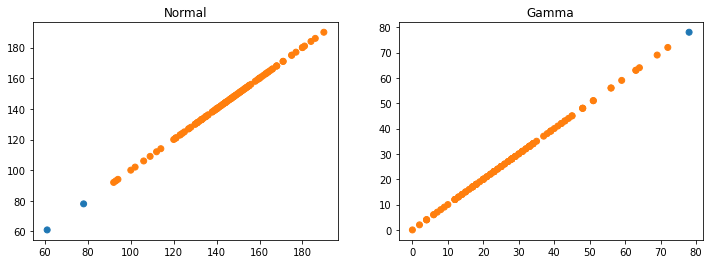

array: 47


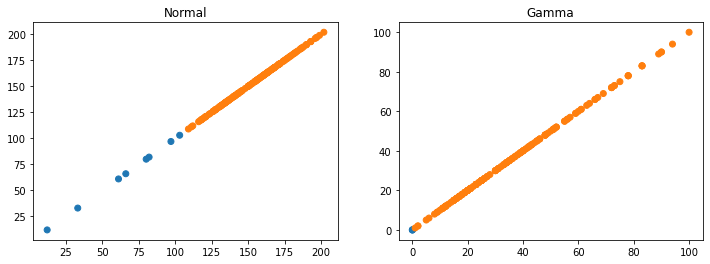

array: 48


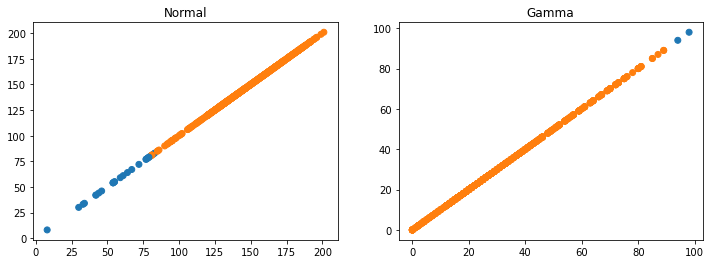

array: 49


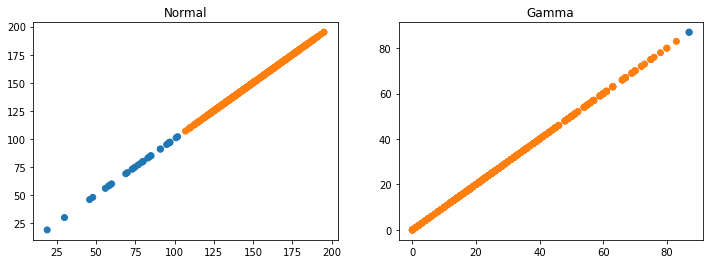

array: 50


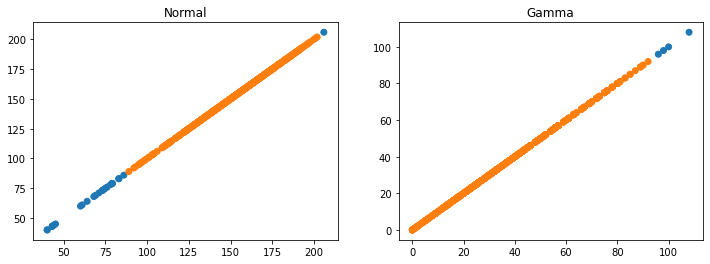

array: 51


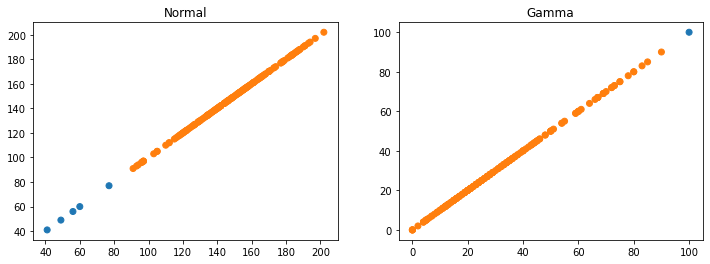

array: 52


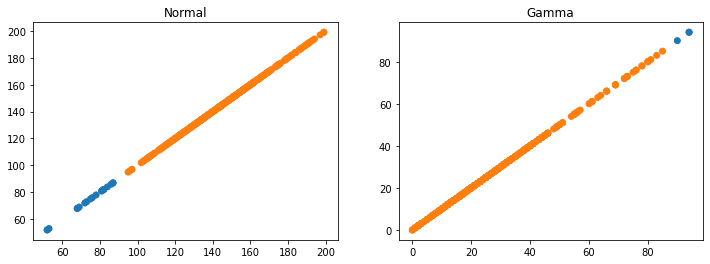

array: 53


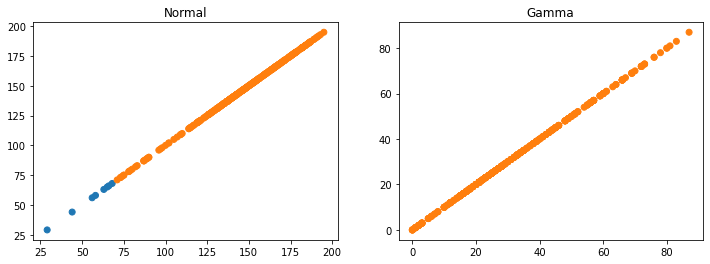

array: 54


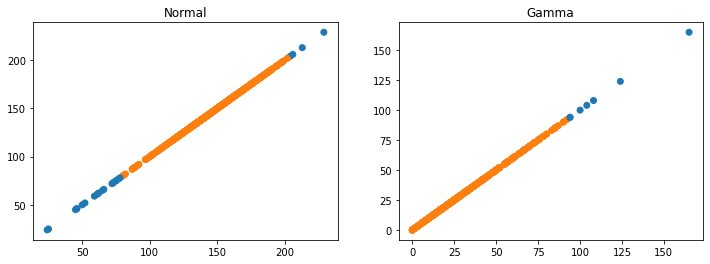

array: 55


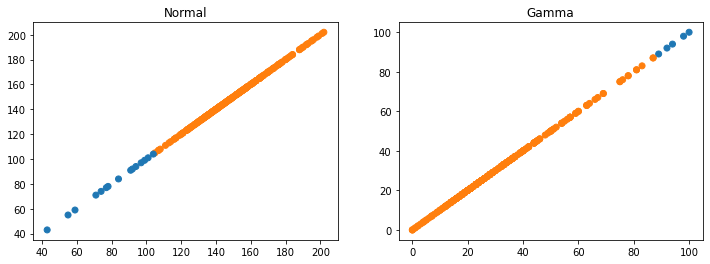

array: 56


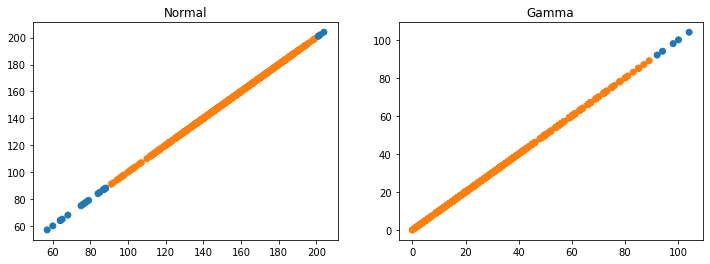

array: 57


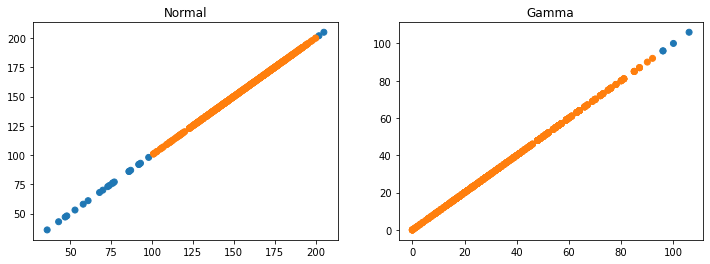

array: 58


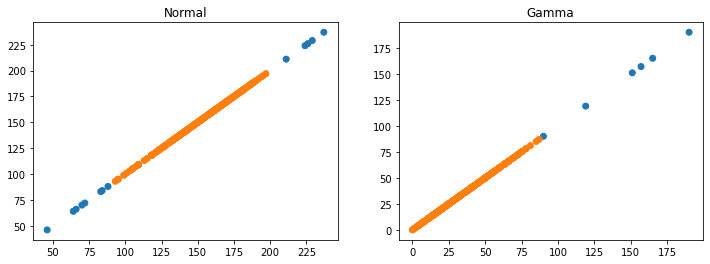

array: 59


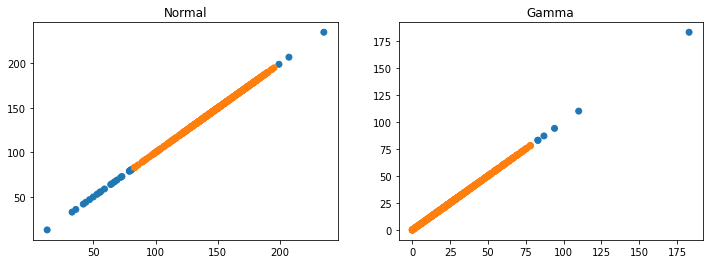

array: 60


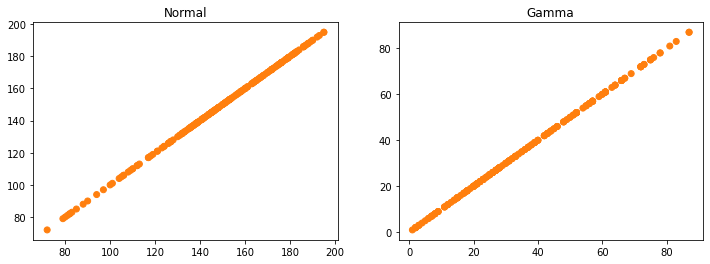

array: 61


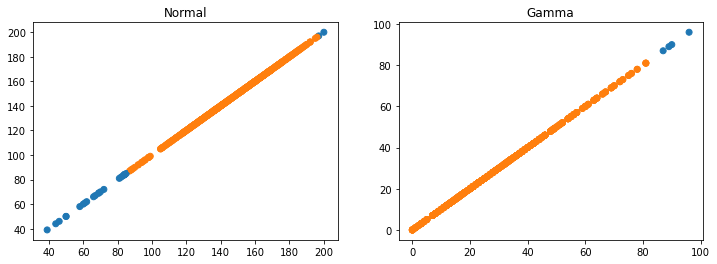

array: 62


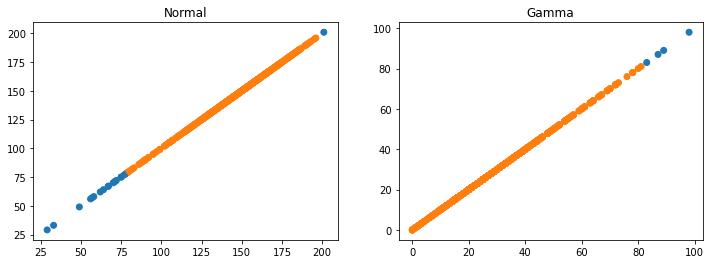

array: 63


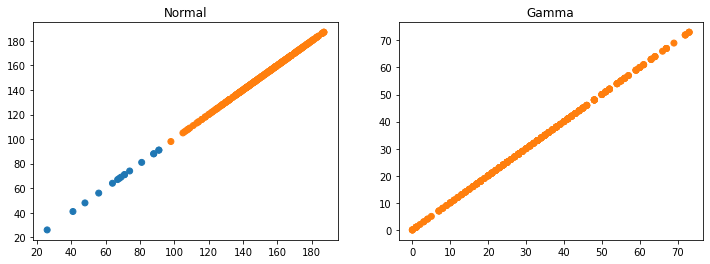

array: 64


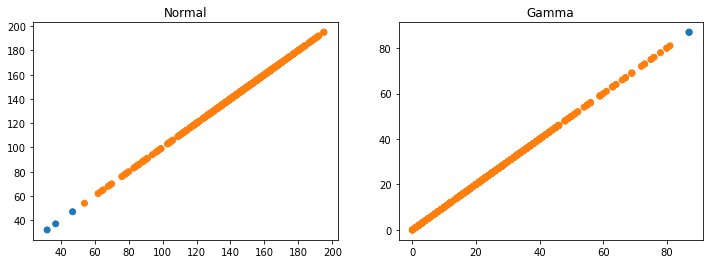

array: 65


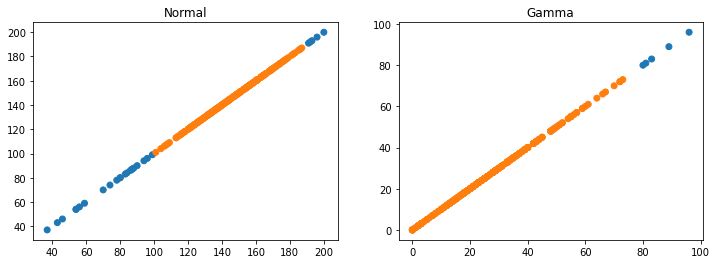

array: 66


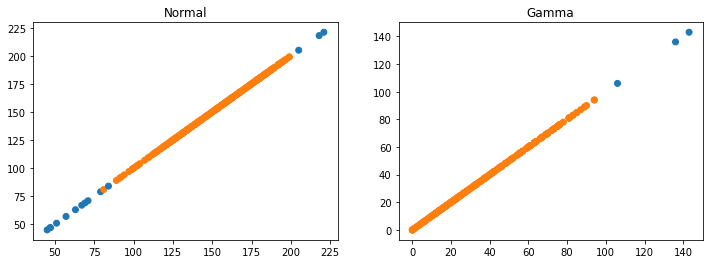

array: 67


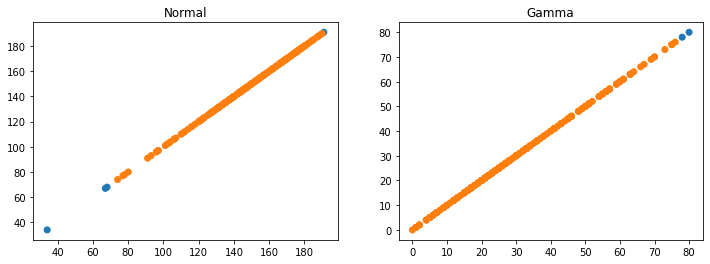

array: 68


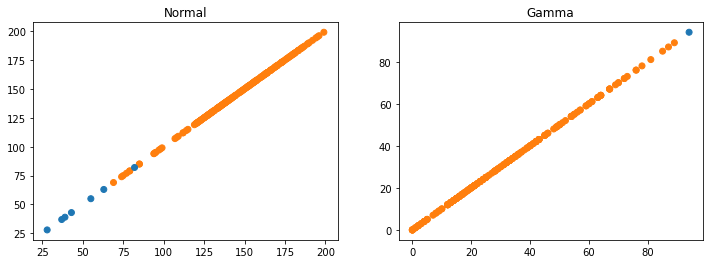

array: 69


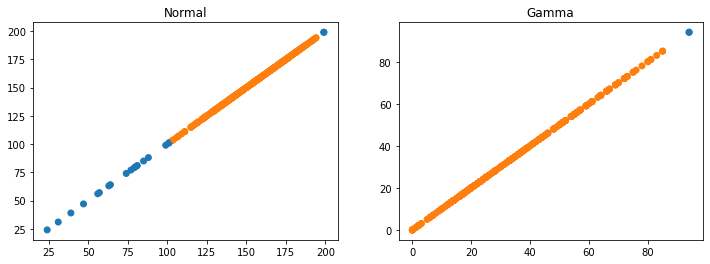

array: 70


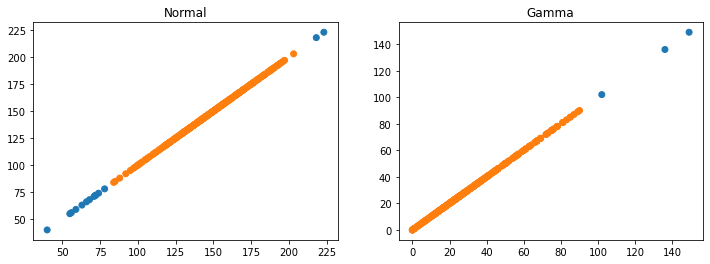

array: 71


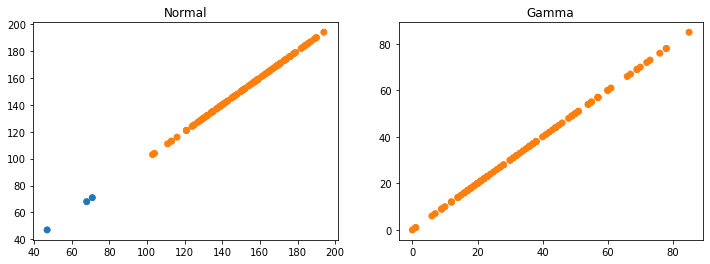

array: 72


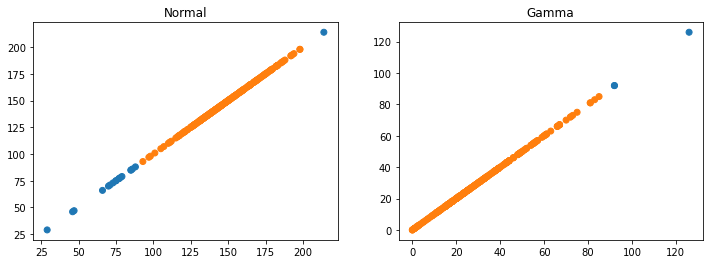

array: 73


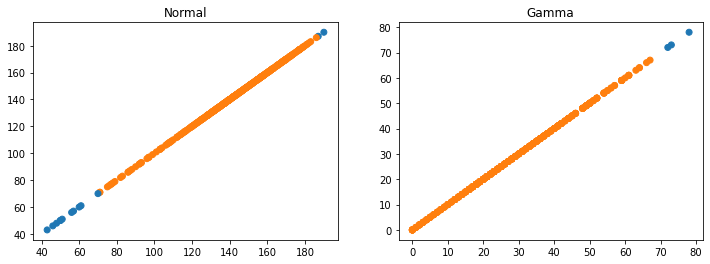

array: 74


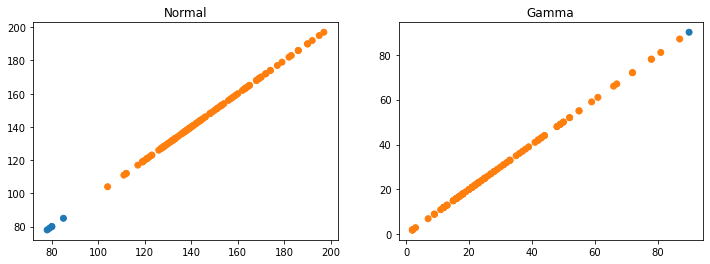

array: 75


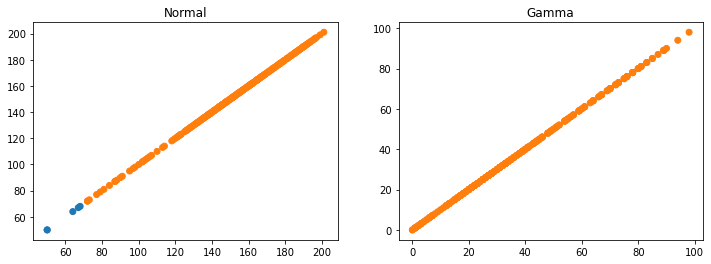

array: 76


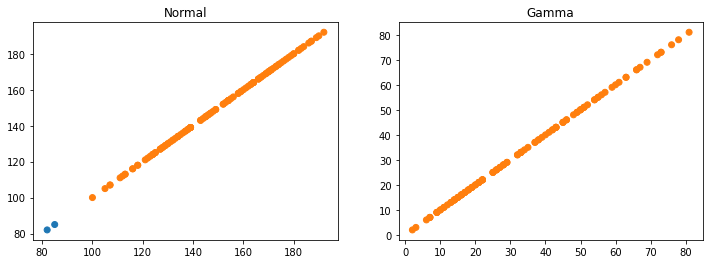

array: 77


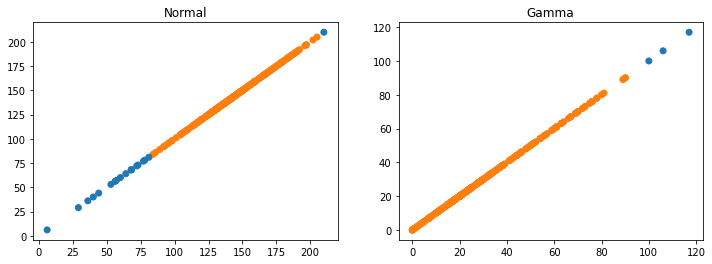

array: 78


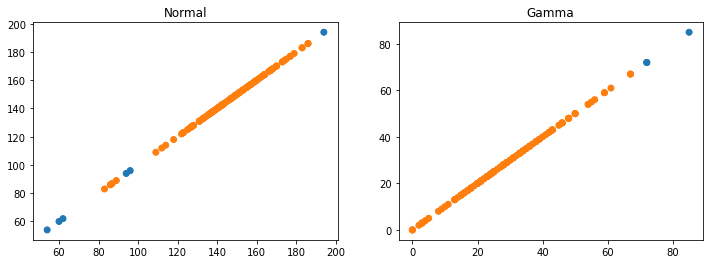

array: 79


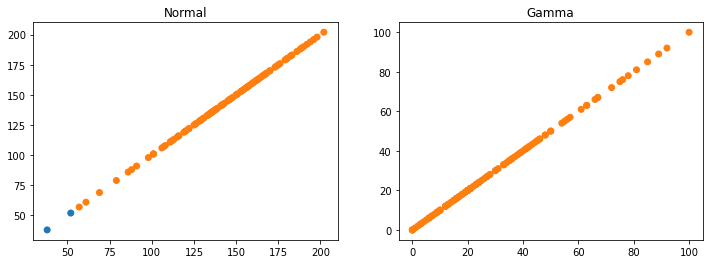

array: 80


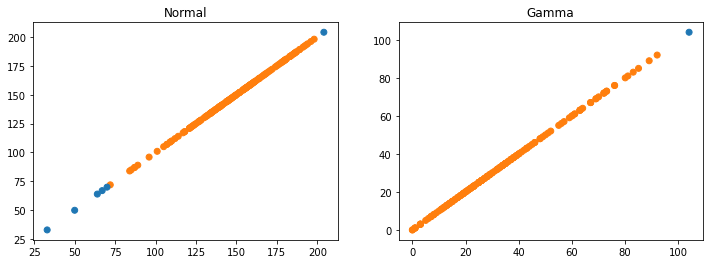

array: 81


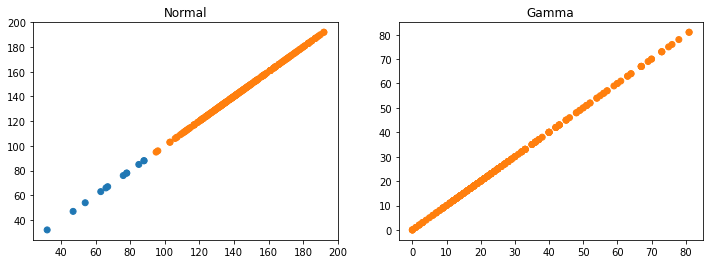

array: 82


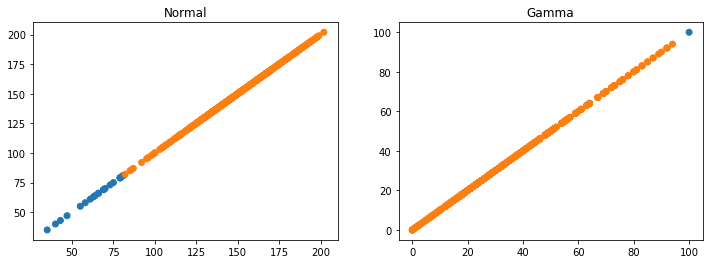

array: 83


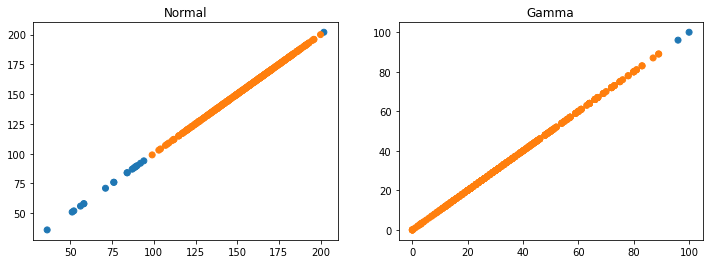

array: 84


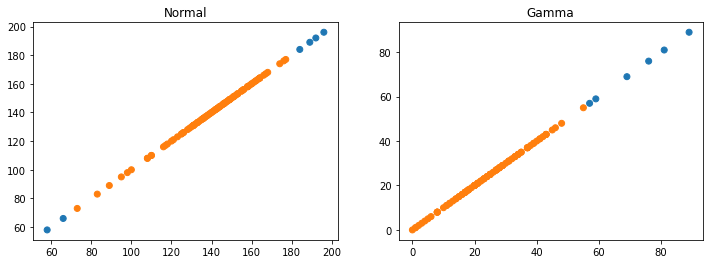

array: 85


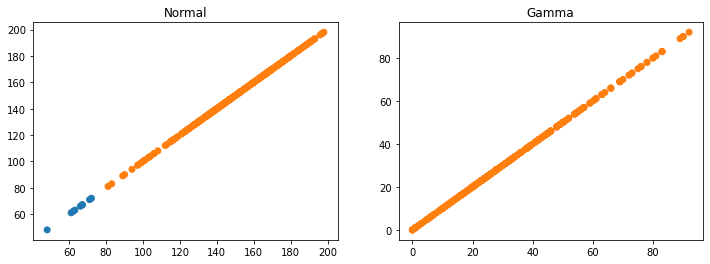

array: 86


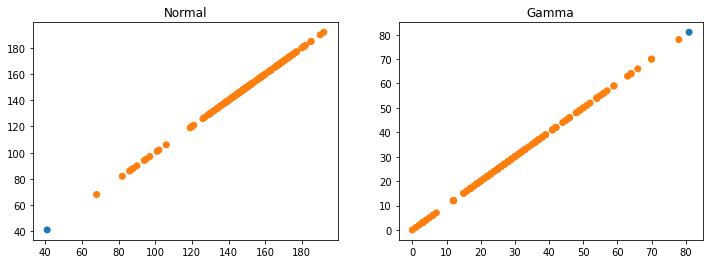

array: 87


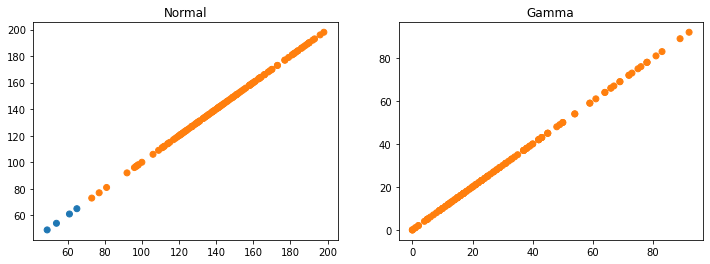

array: 88


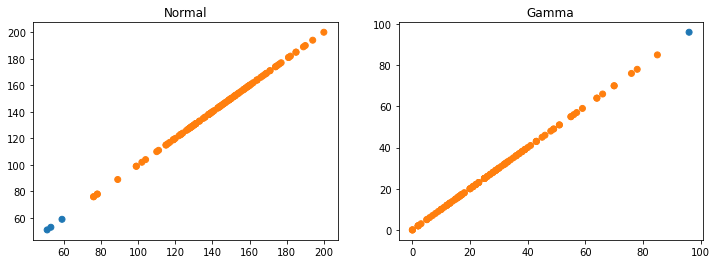

array: 89


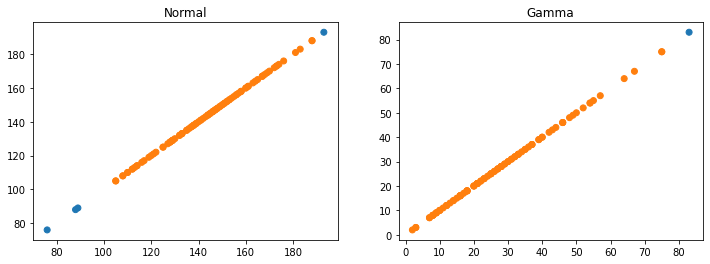

array: 90


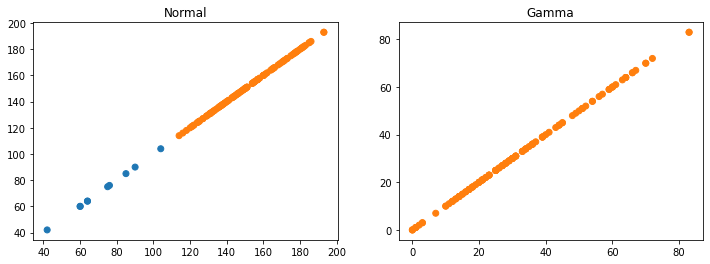

array: 91


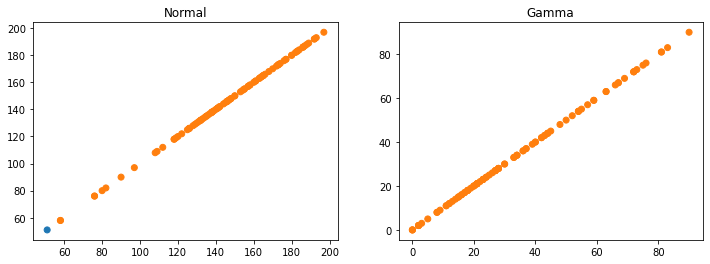

array: 92


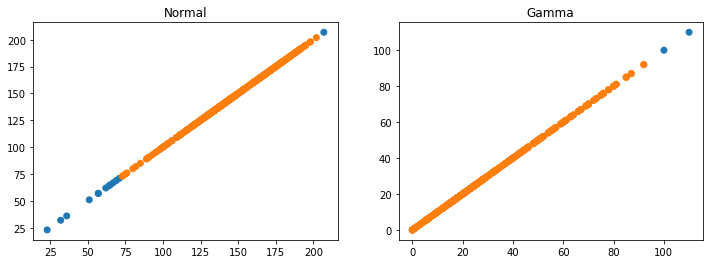

array: 93


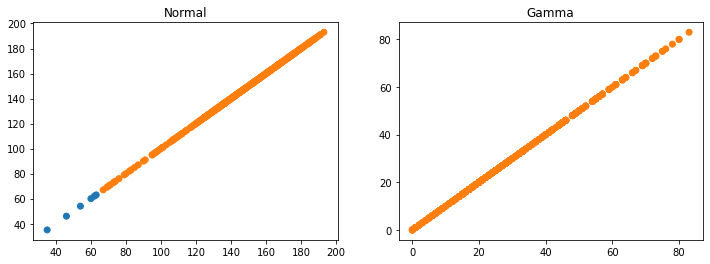

array: 94


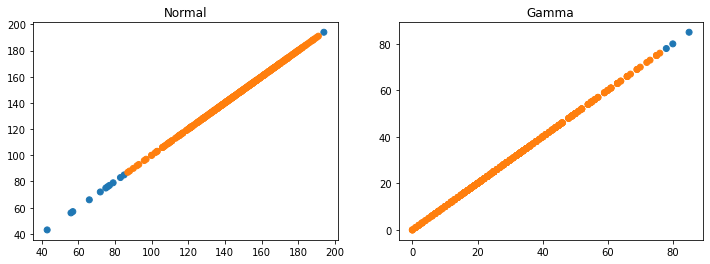

array: 95


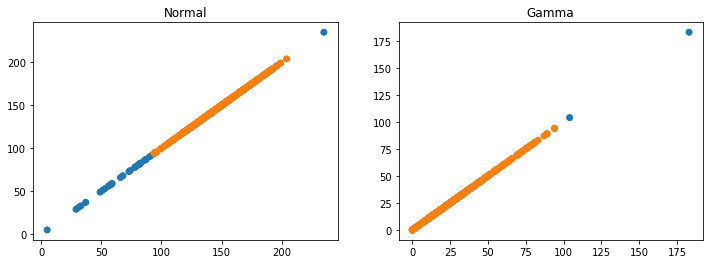

array: 96


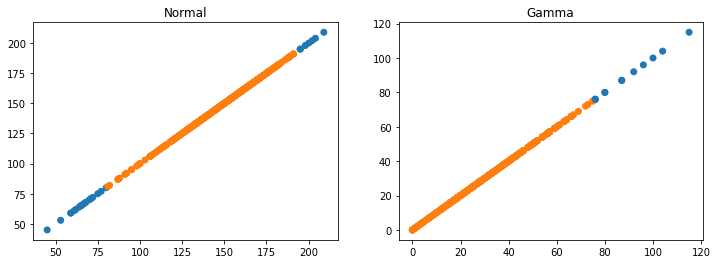

array: 97


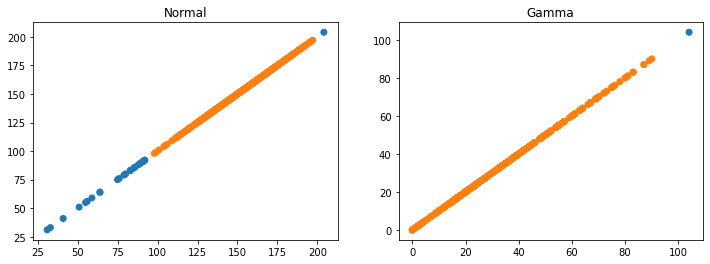

array: 98


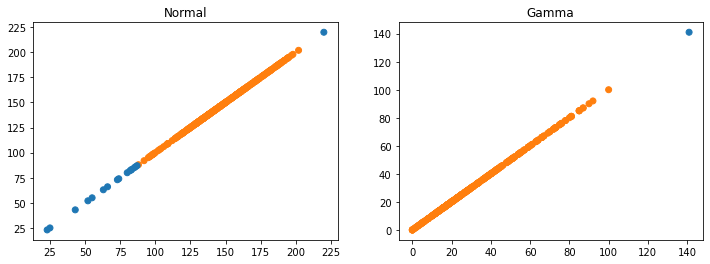

array: 99


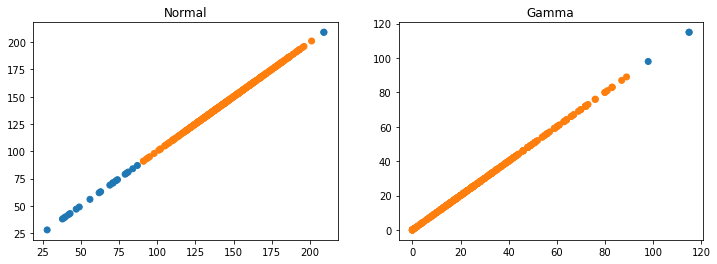

array: 100


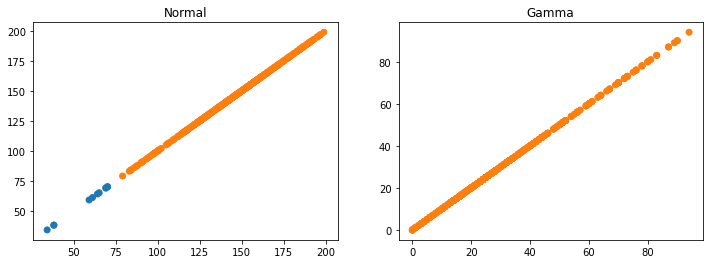

array: 101


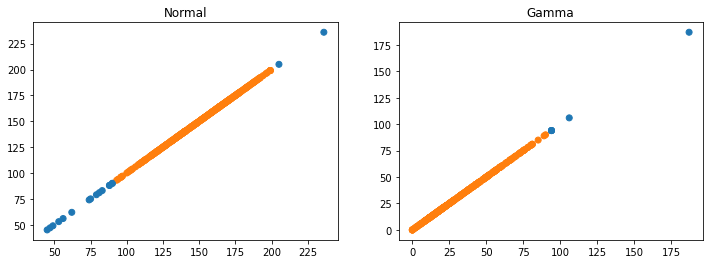

array: 102


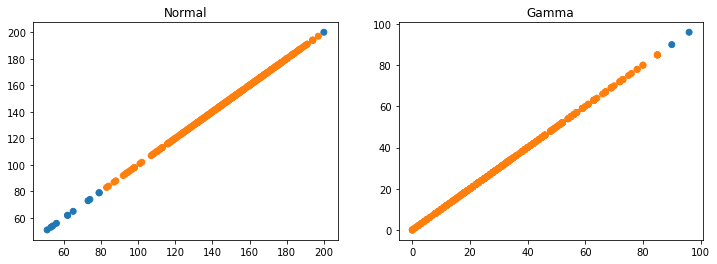

array: 103


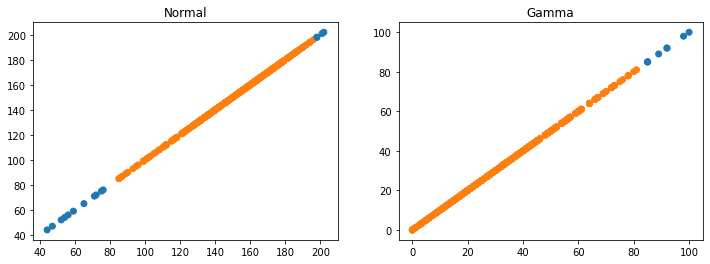

array: 104


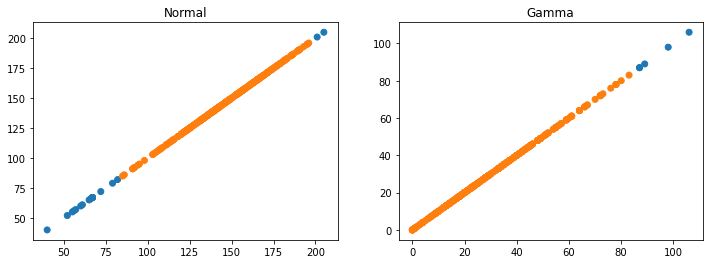

array: 105


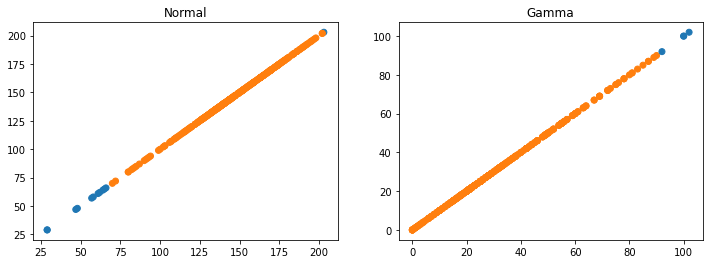

array: 106


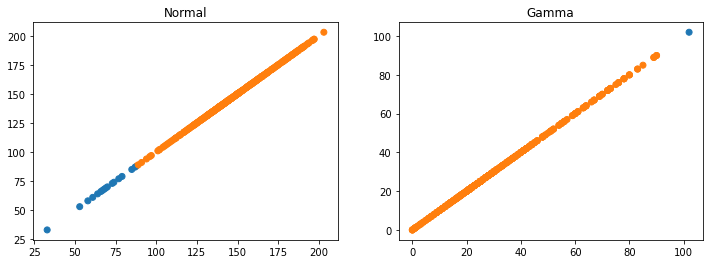

array: 107


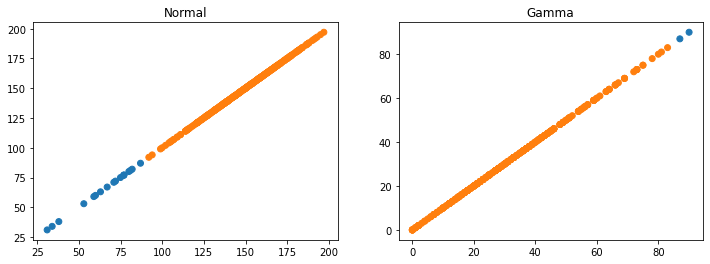

array: 108


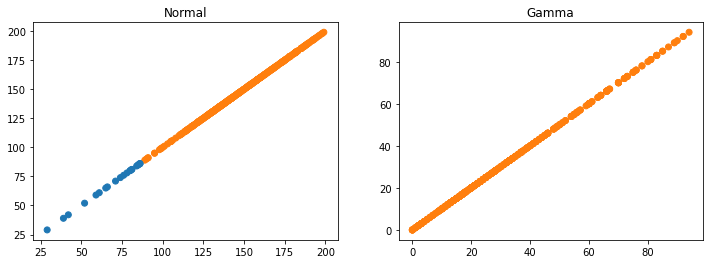

array: 109


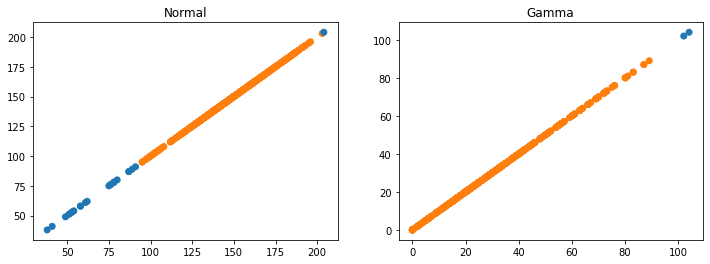

array: 110


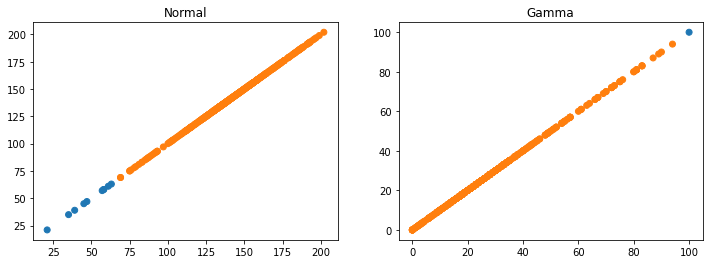

array: 111


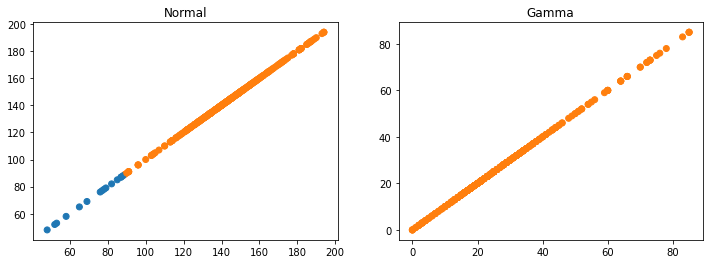

In [23]:
check_pred_labels(array_lof_normal, array_lof_gamma)

array: 0


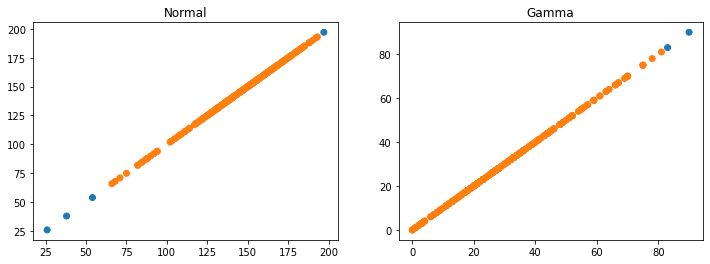

array: 1


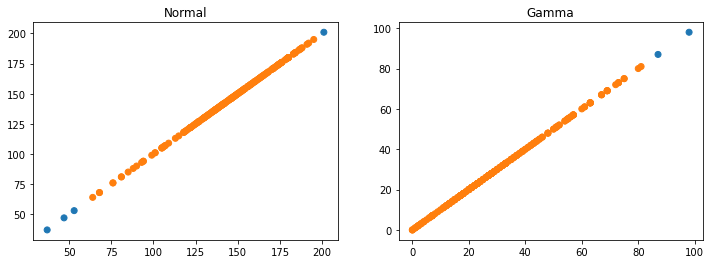

array: 2


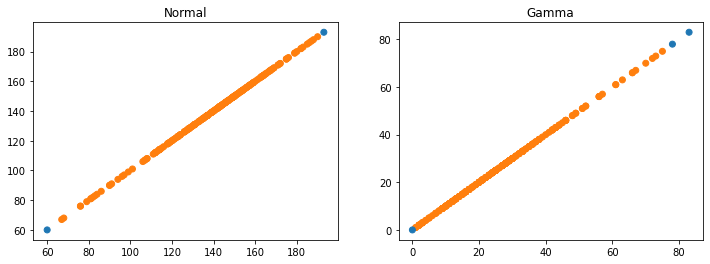

array: 3


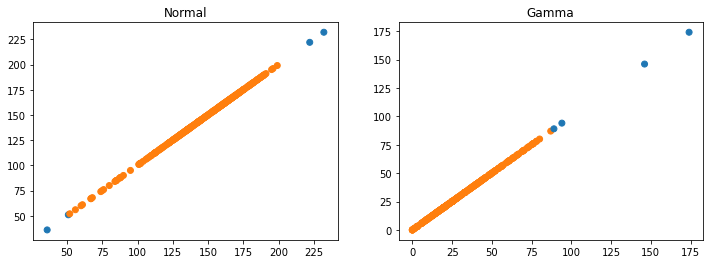

array: 4


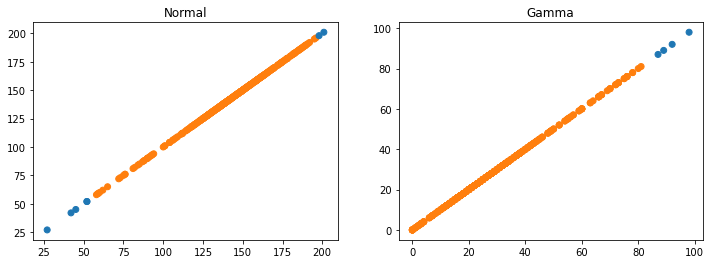

array: 5


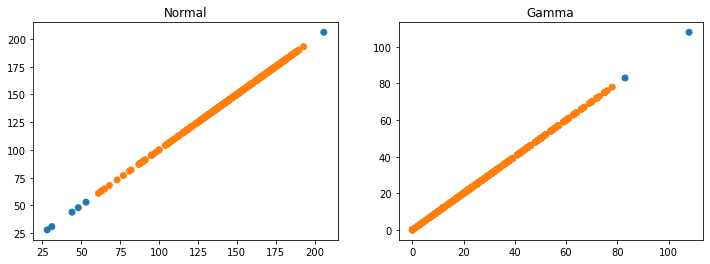

array: 6


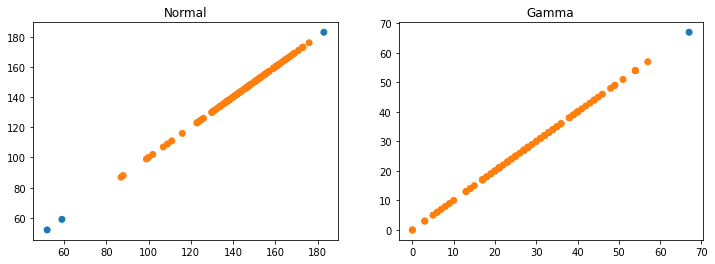

array: 7


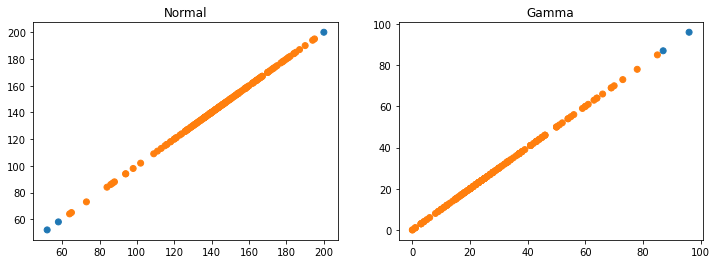

array: 8


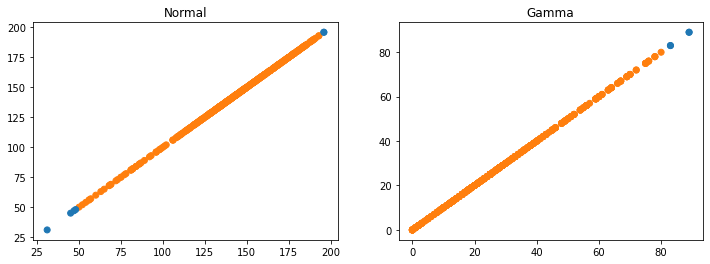

array: 9


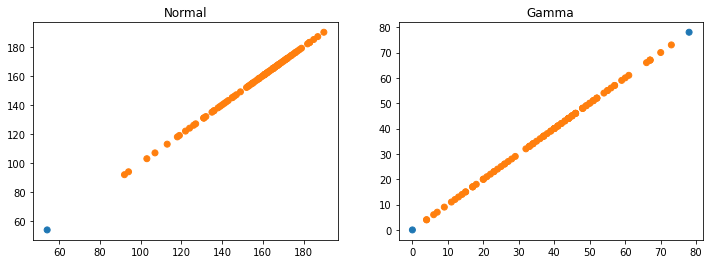

array: 10


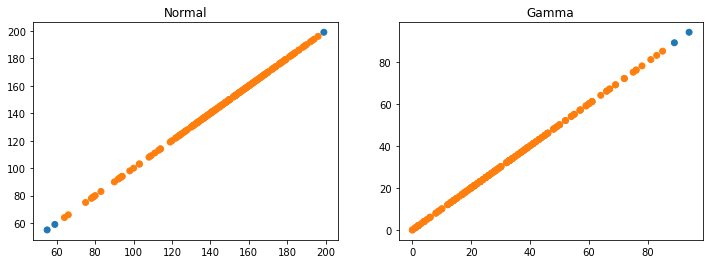

array: 11


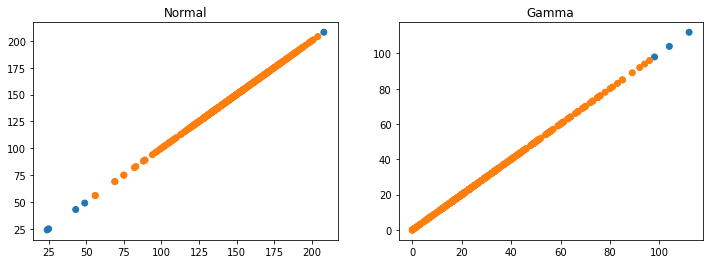

array: 12


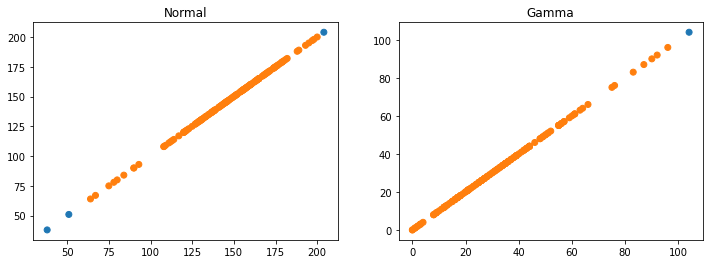

array: 13


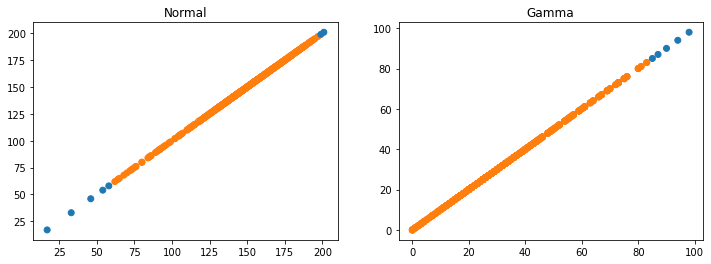

array: 14


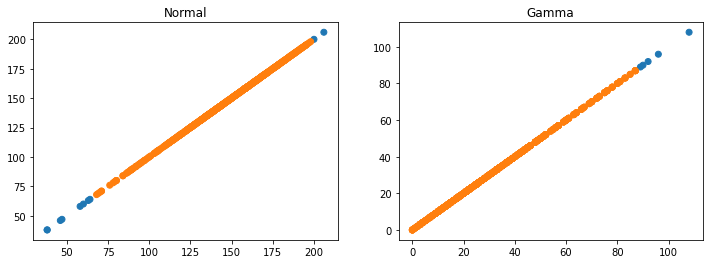

array: 15


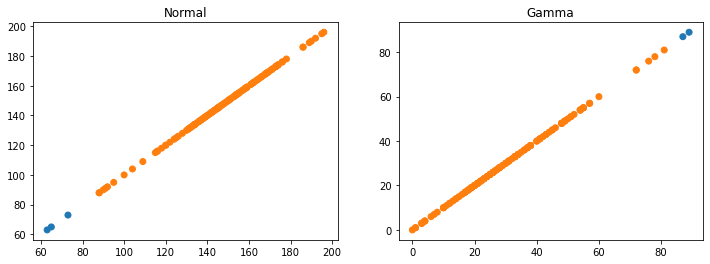

array: 16


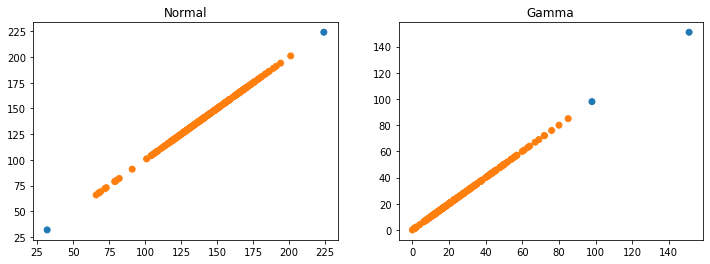

array: 17


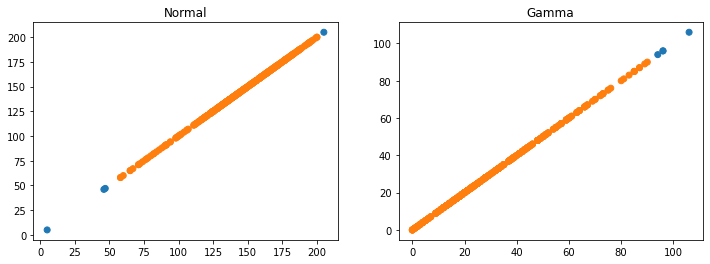

array: 18


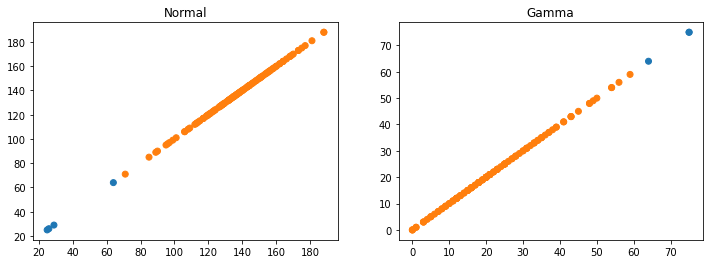

array: 19


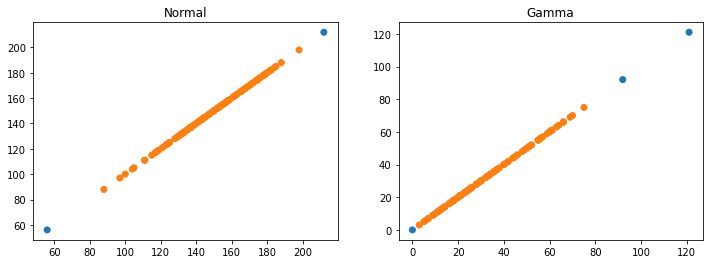

array: 20


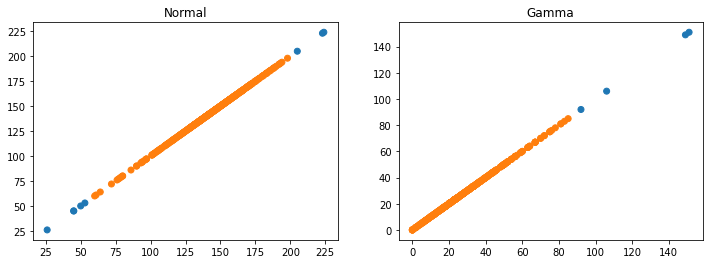

array: 21


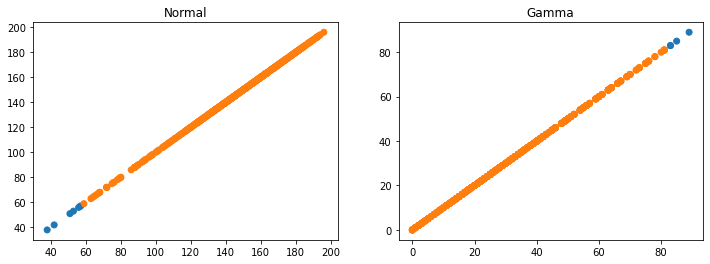

array: 22


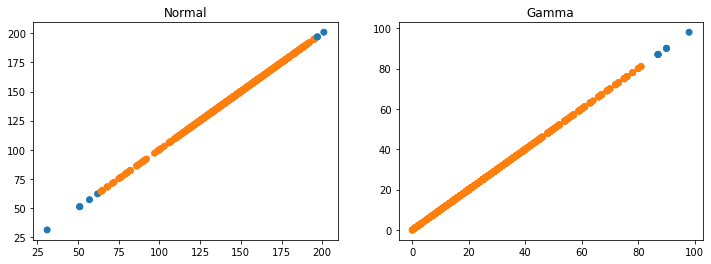

array: 23


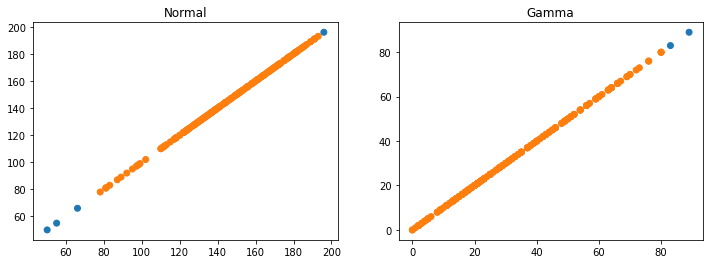

array: 24


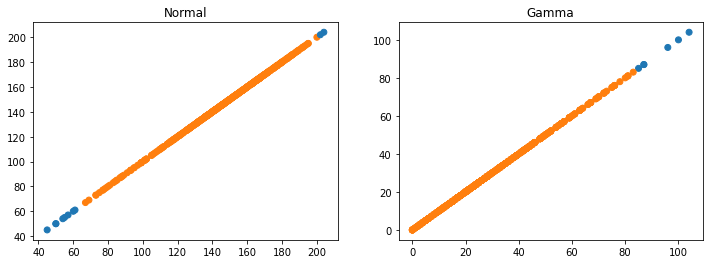

array: 25


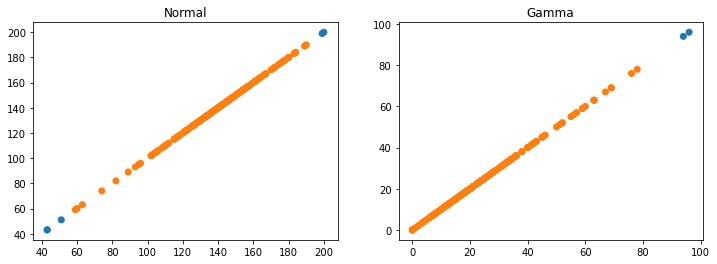

array: 26


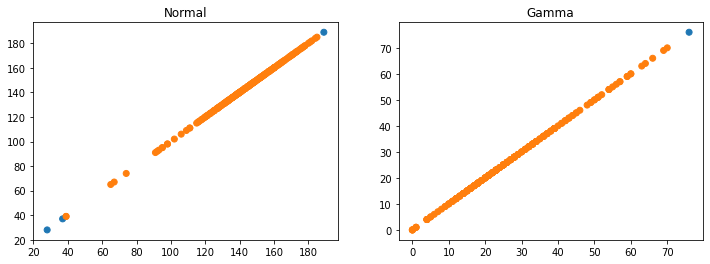

array: 27


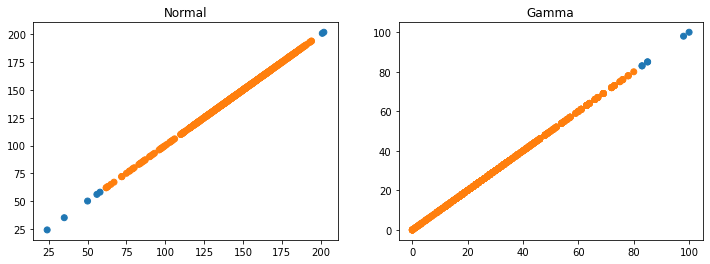

array: 28


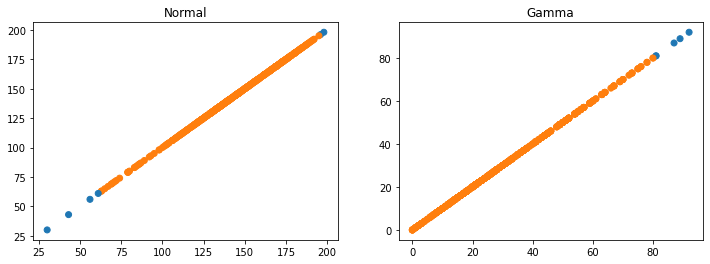

array: 29


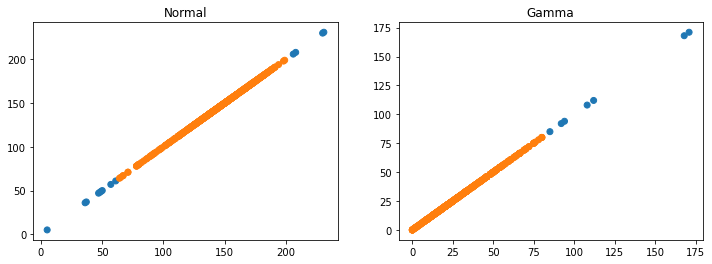

array: 30


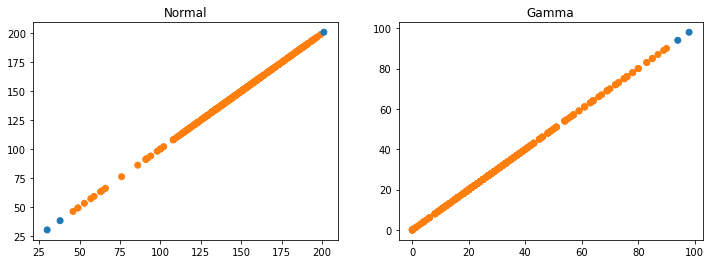

array: 31


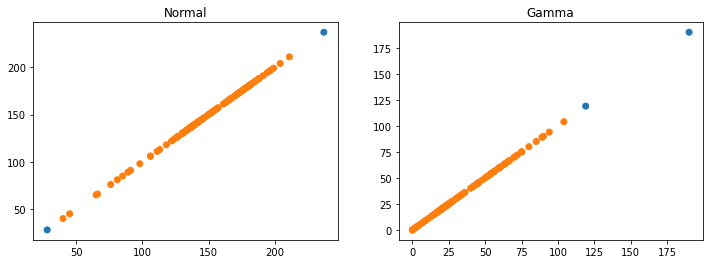

array: 32


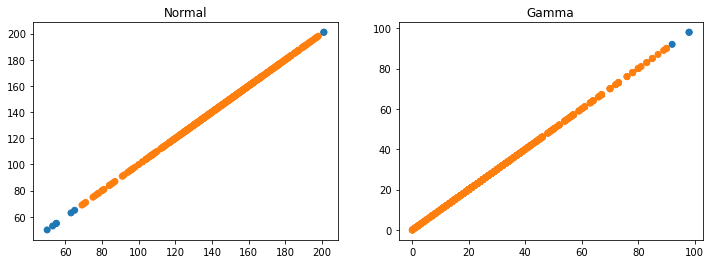

array: 33


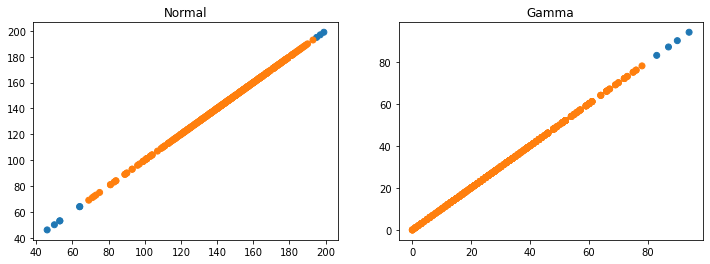

array: 34


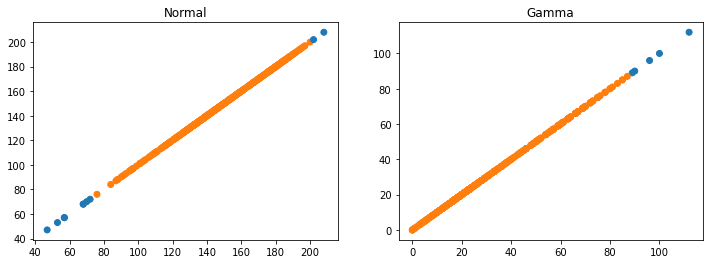

array: 35


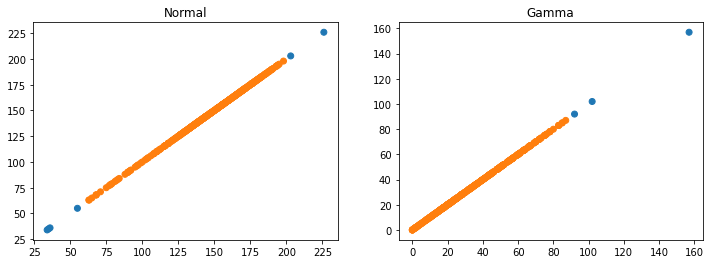

array: 36


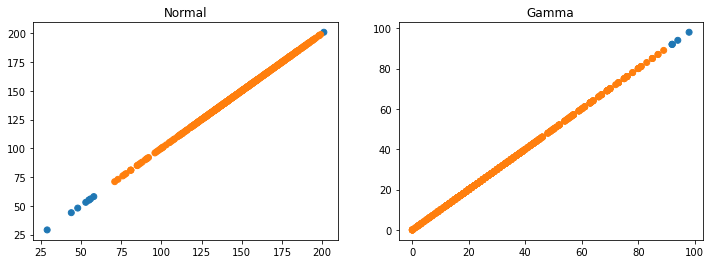

array: 37


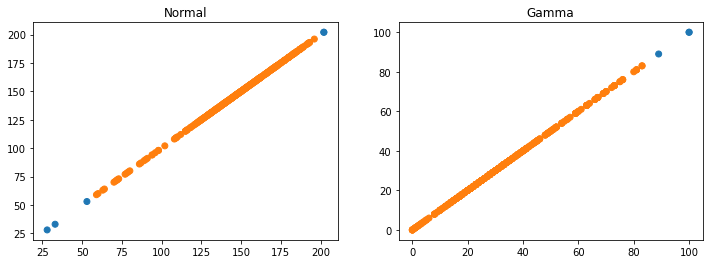

array: 38


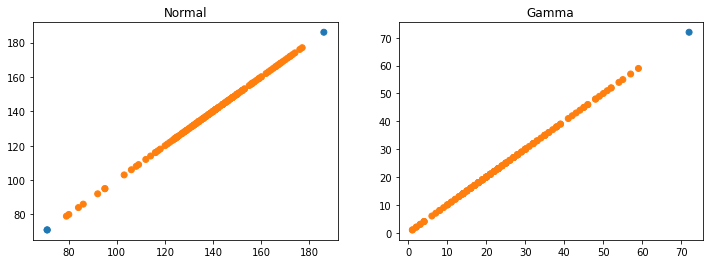

array: 39


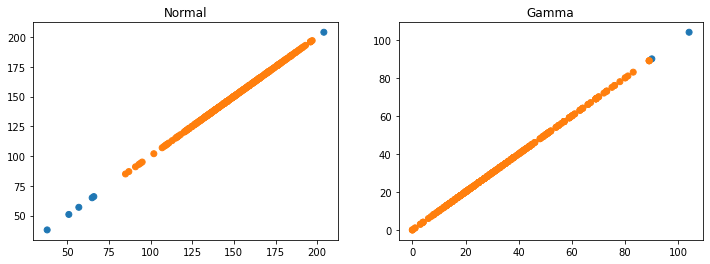

array: 40


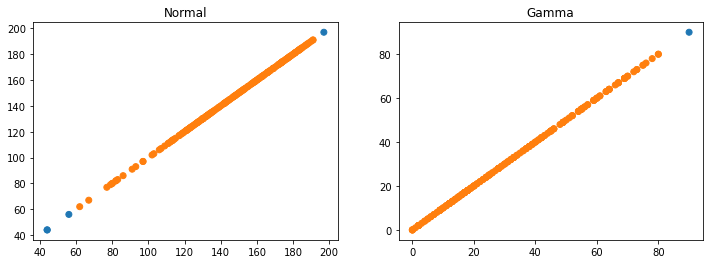

array: 41


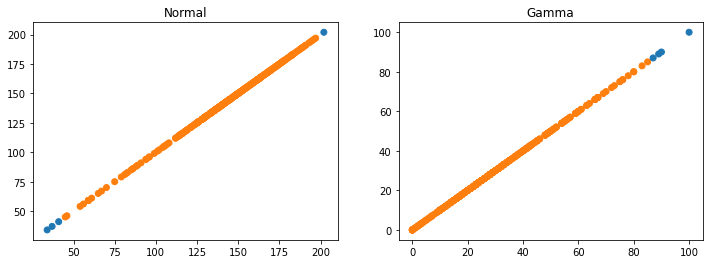

array: 42


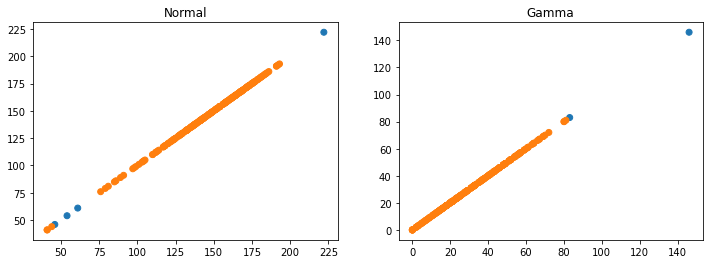

array: 43


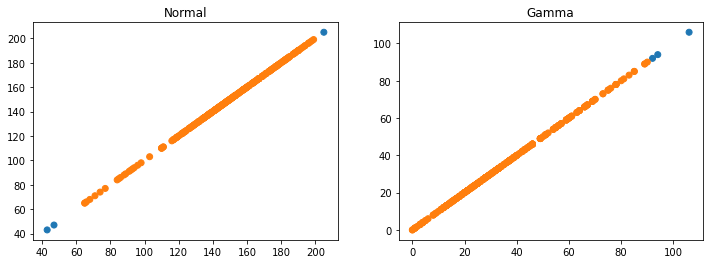

array: 44


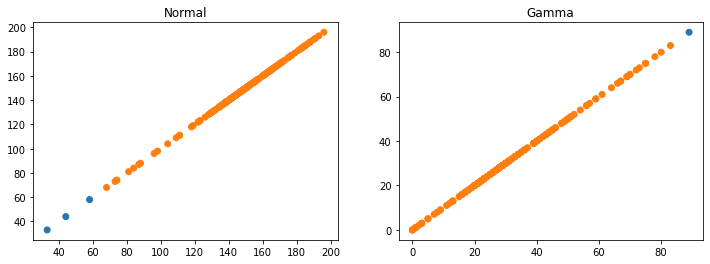

array: 45


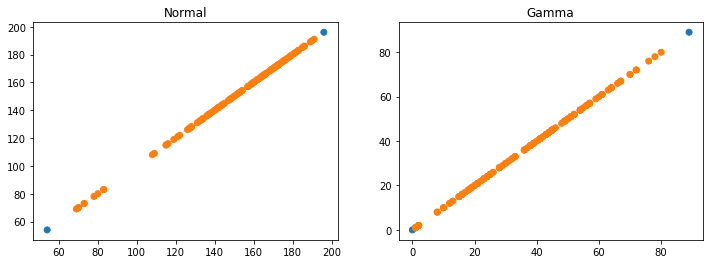

array: 46


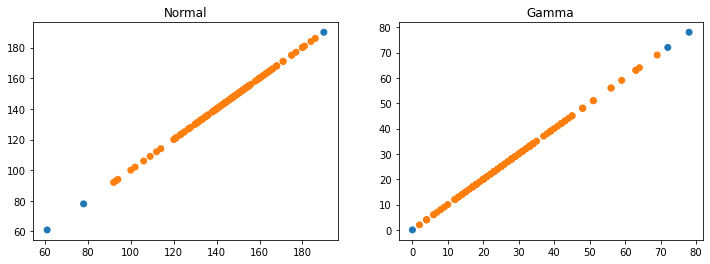

array: 47


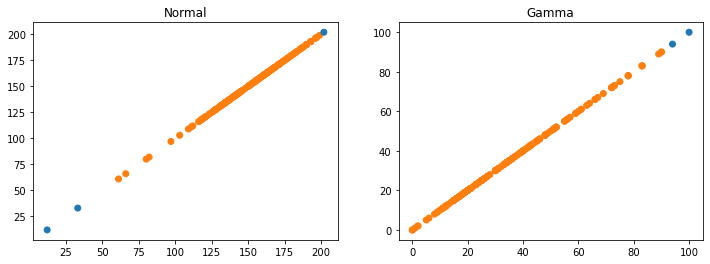

array: 48


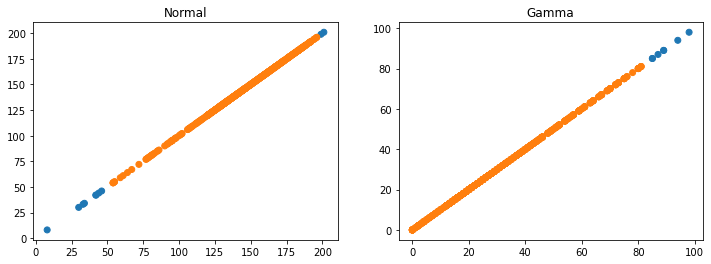

array: 49


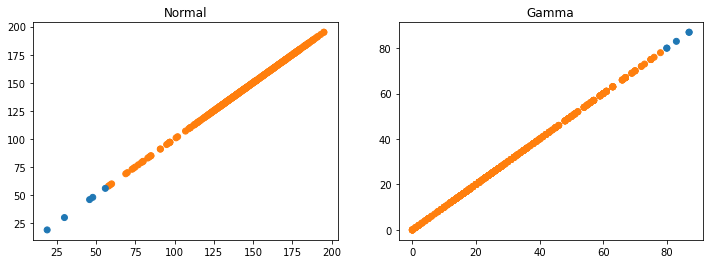

array: 50


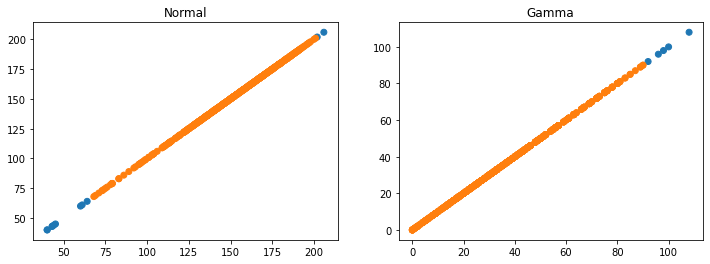

array: 51


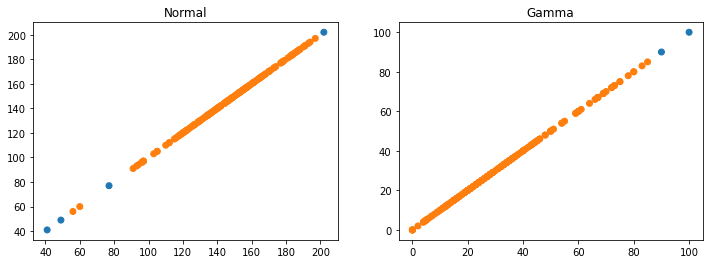

array: 52


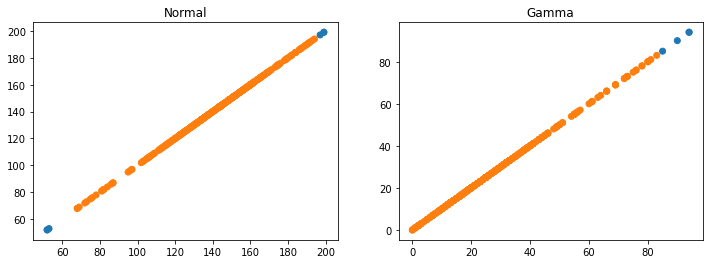

array: 53


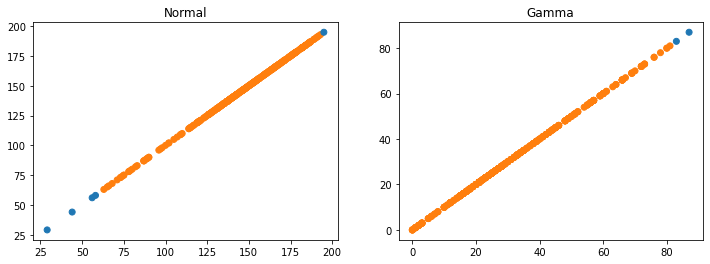

array: 54


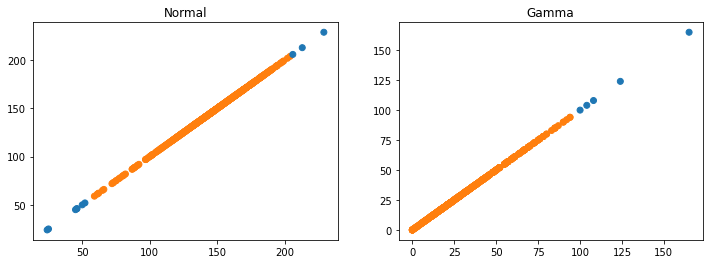

array: 55


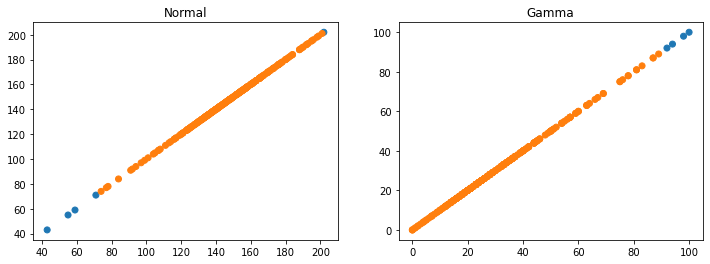

array: 56


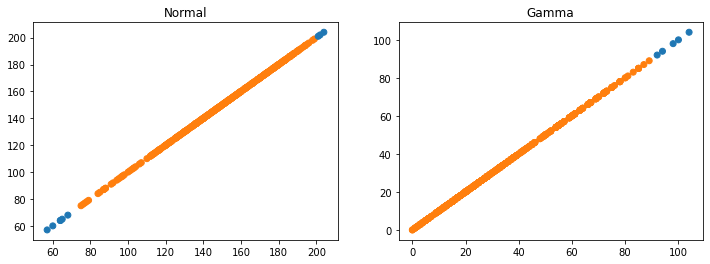

array: 57


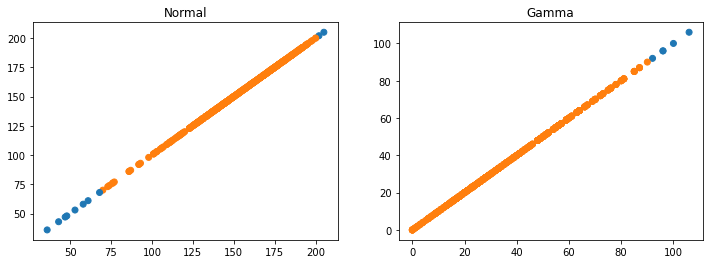

array: 58


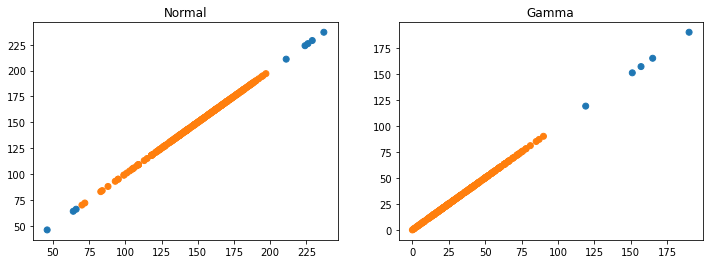

array: 59


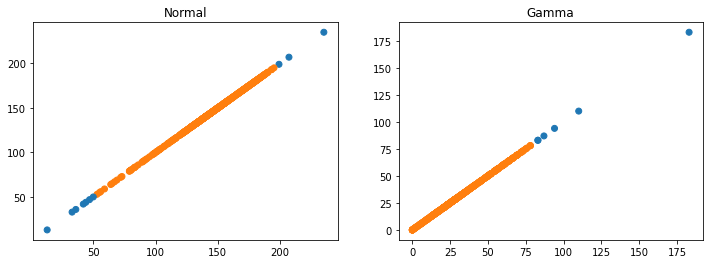

array: 60


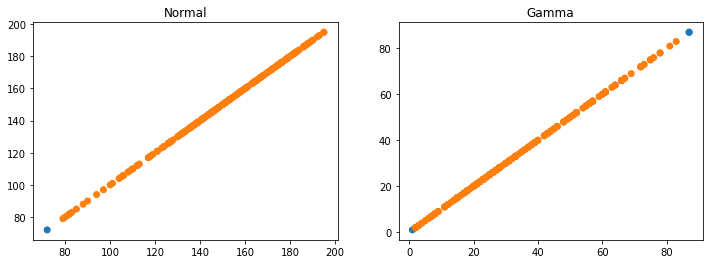

array: 61


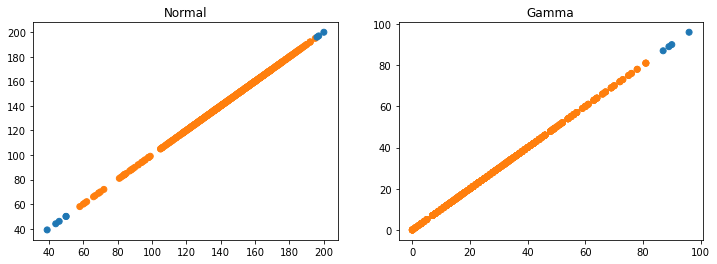

array: 62


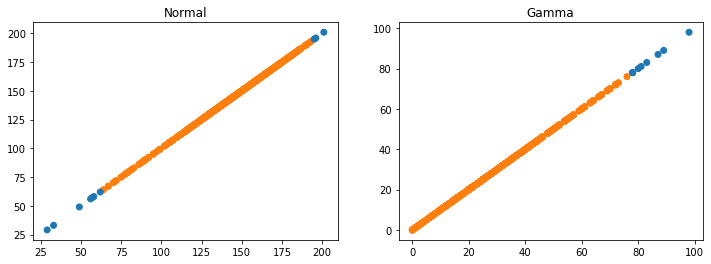

array: 63


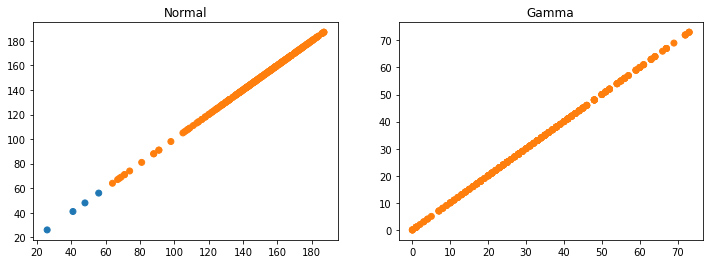

array: 64


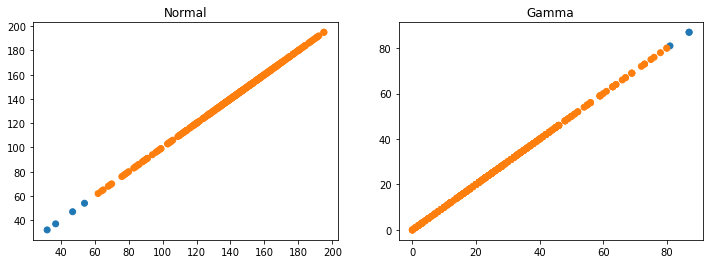

array: 65


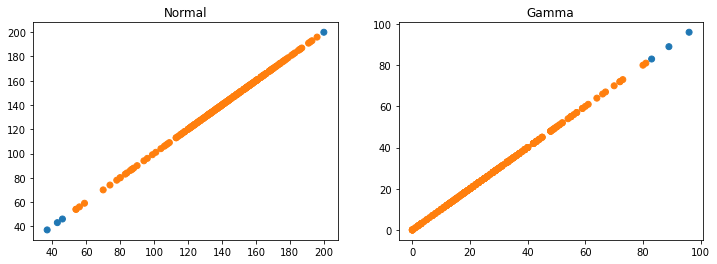

array: 66


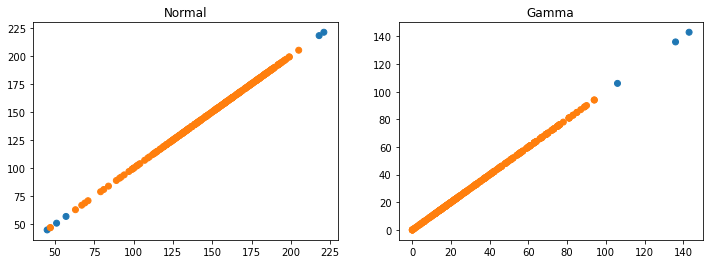

array: 67


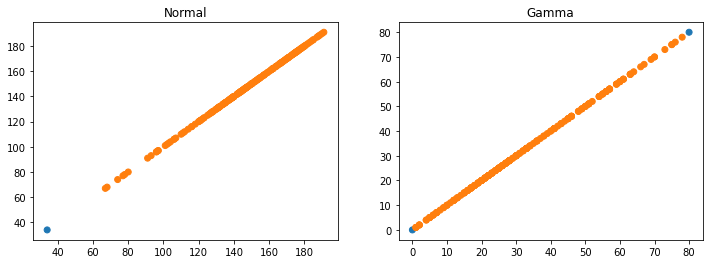

array: 68


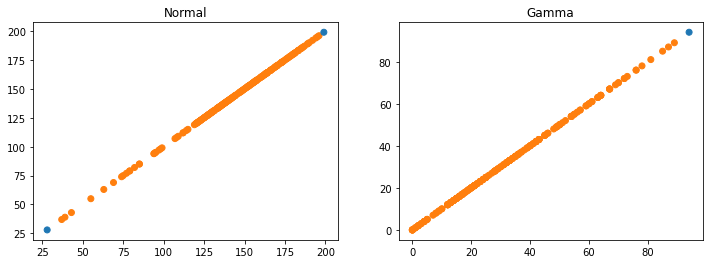

array: 69


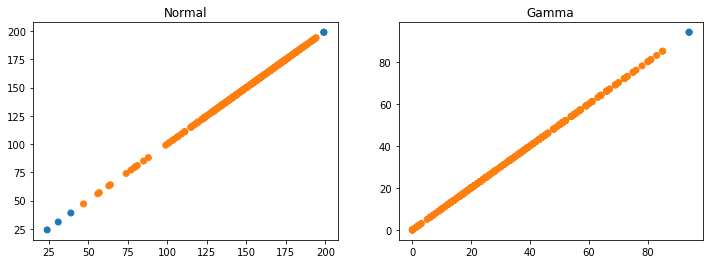

array: 70


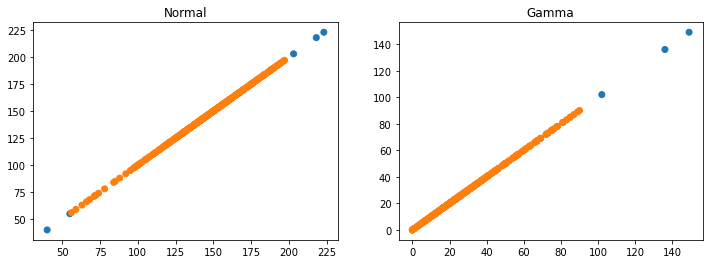

array: 71


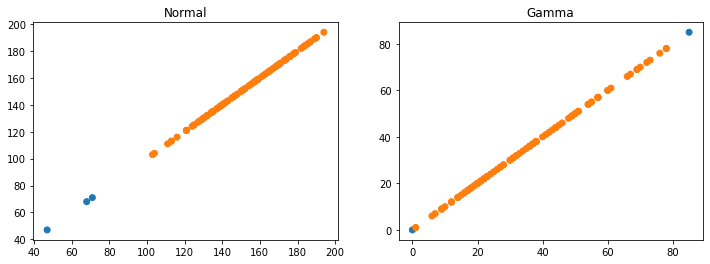

array: 72


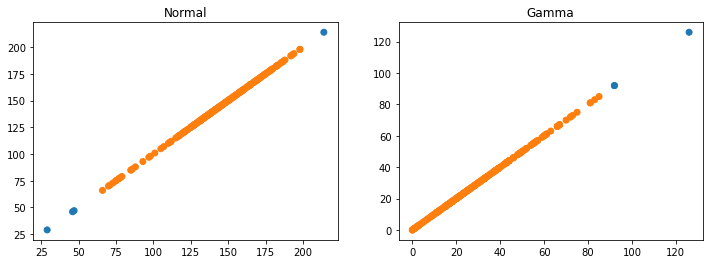

array: 73


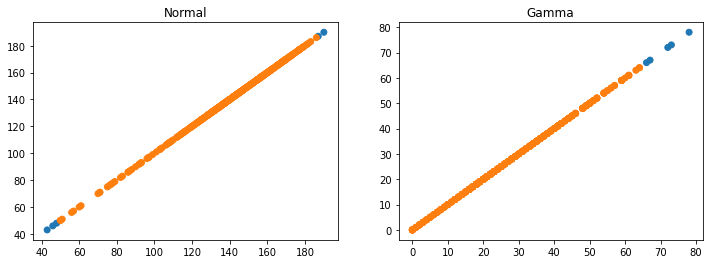

array: 74


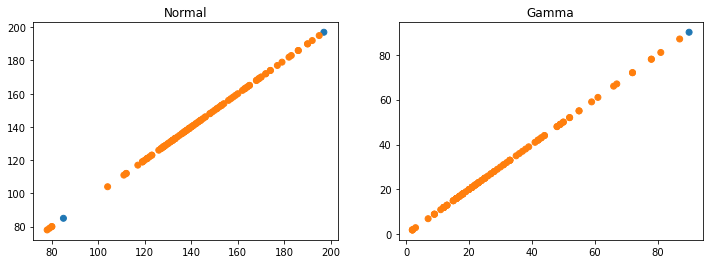

array: 75


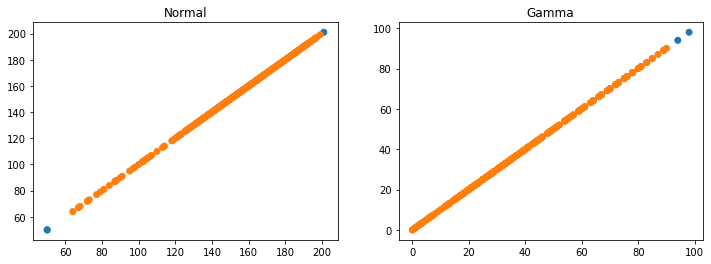

array: 76


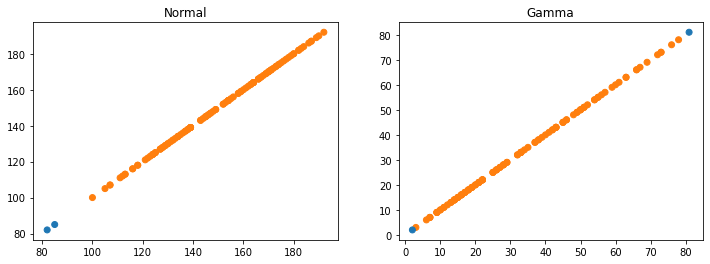

array: 77


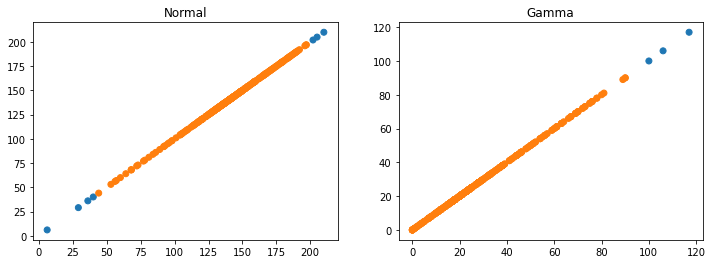

array: 78


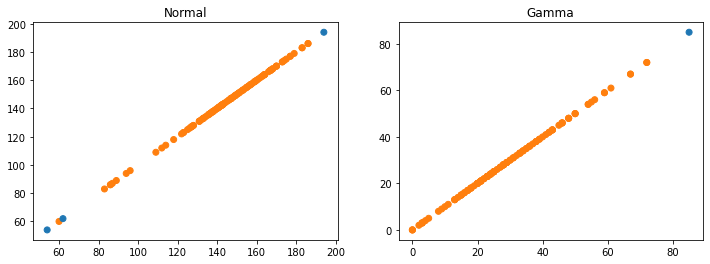

array: 79


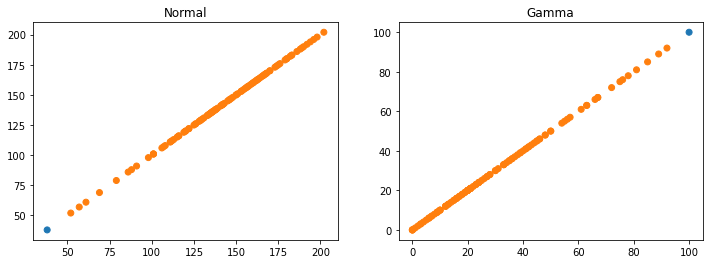

array: 80


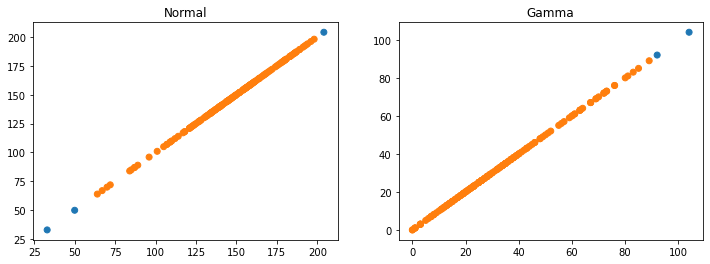

array: 81


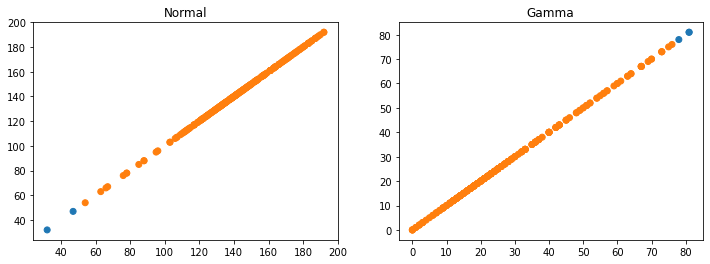

array: 82


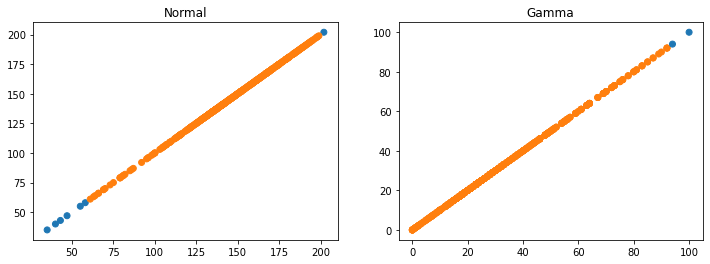

array: 83


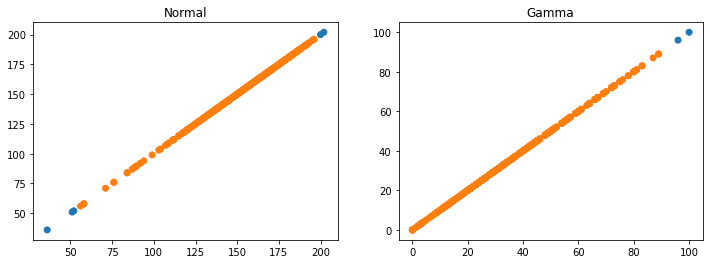

array: 84


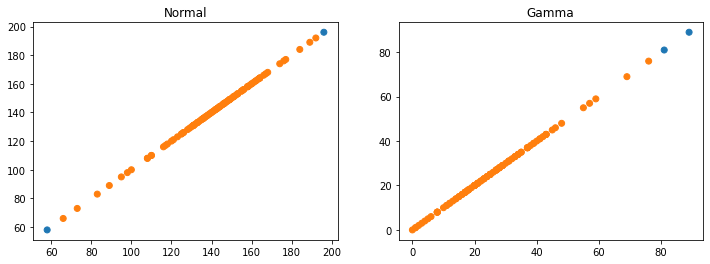

array: 85


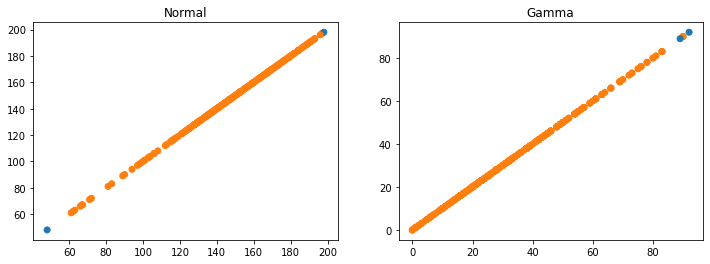

array: 86


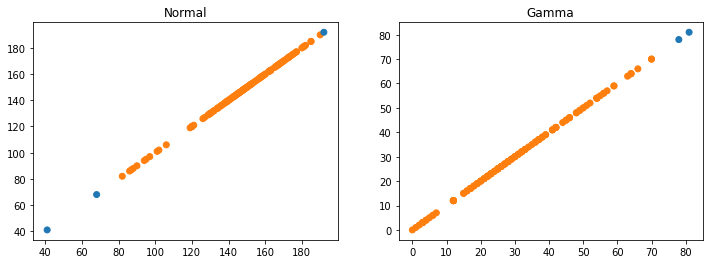

array: 87


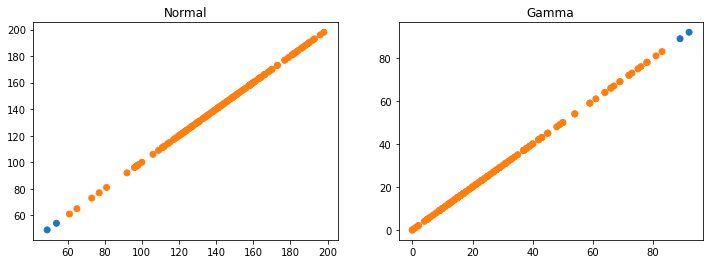

array: 88


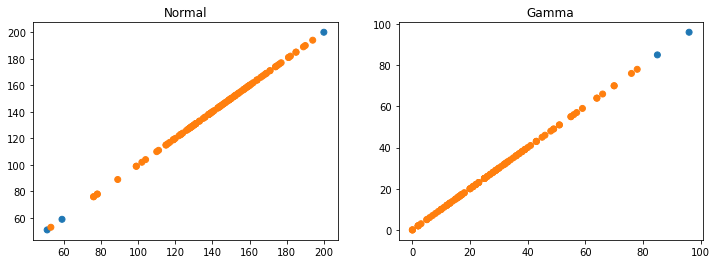

array: 89


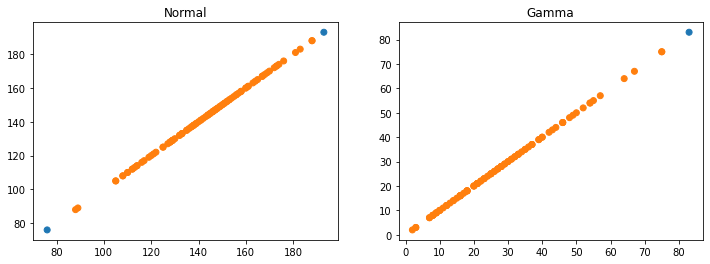

array: 90


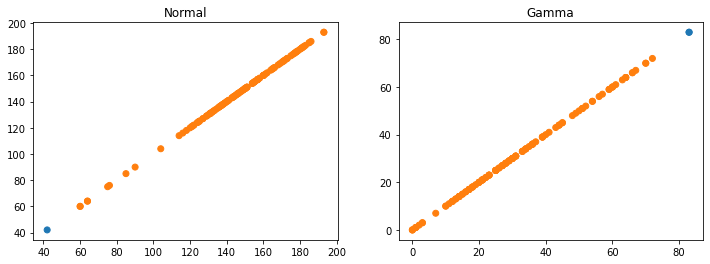

array: 91


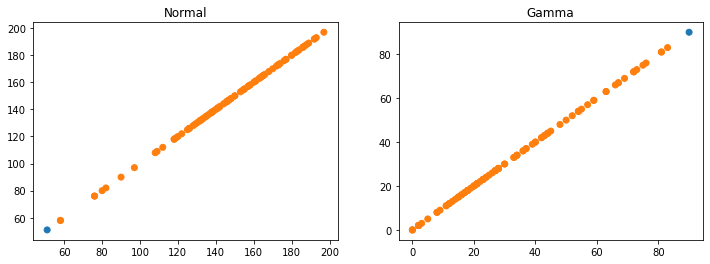

array: 92


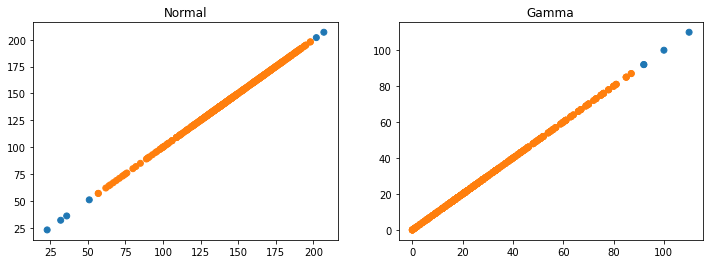

array: 93


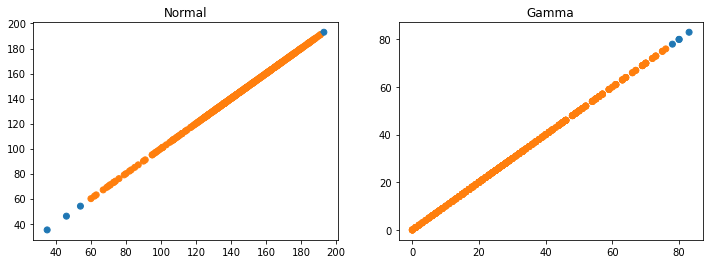

array: 94


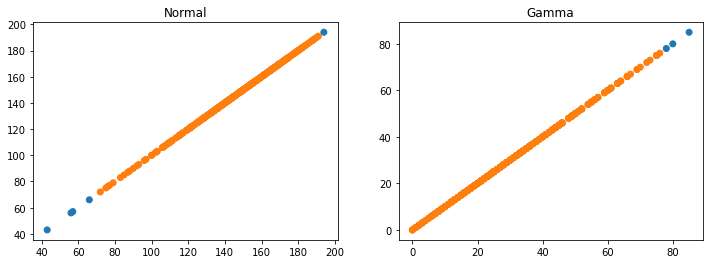

array: 95


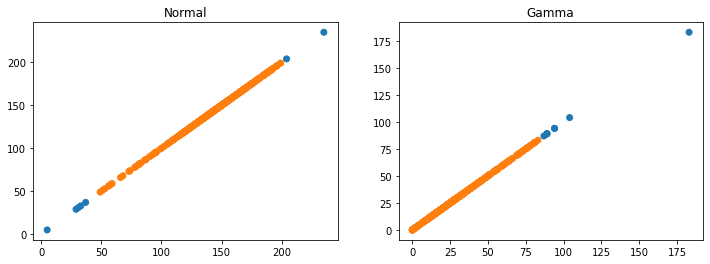

array: 96


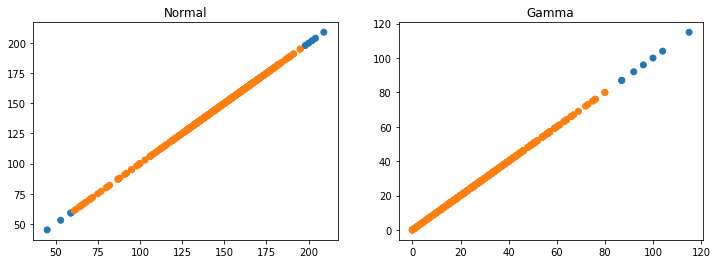

array: 97


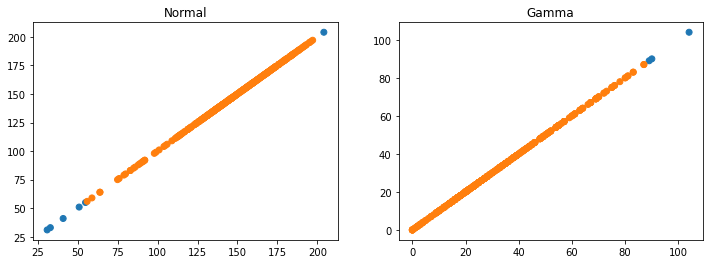

array: 98


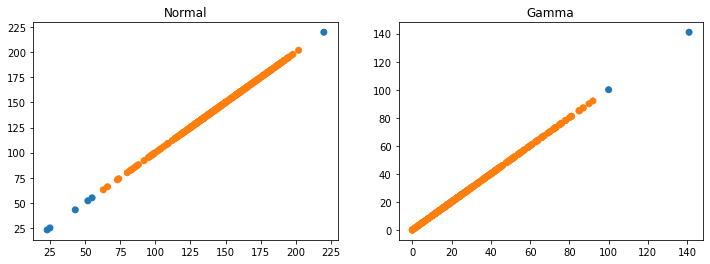

array: 99


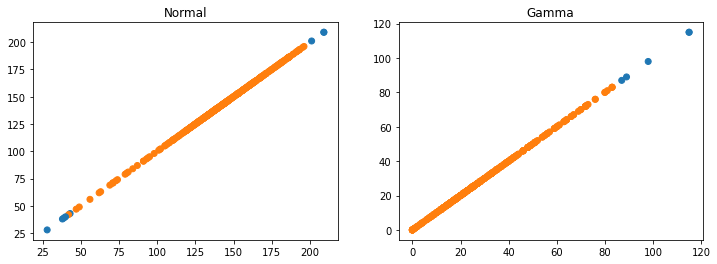

array: 100


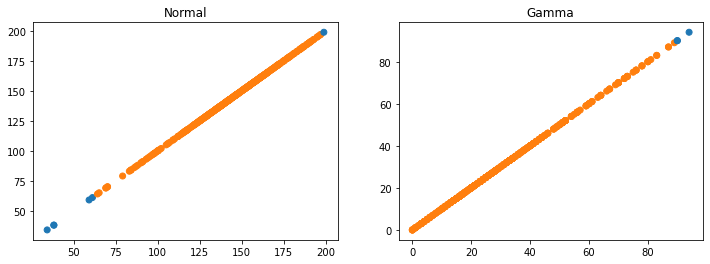

array: 101


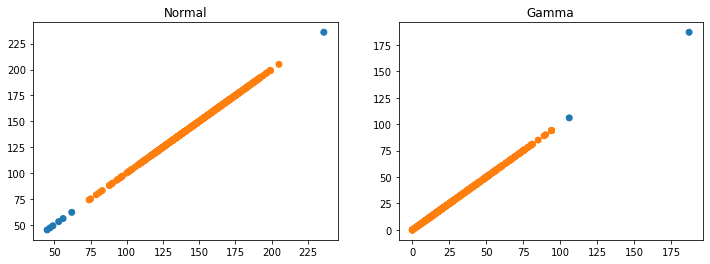

array: 102


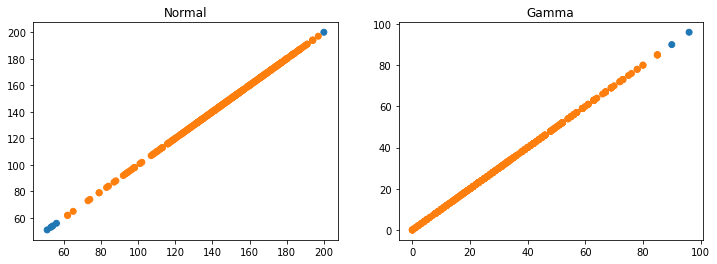

array: 103


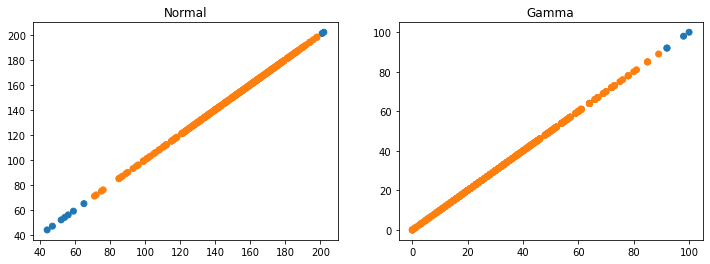

array: 104


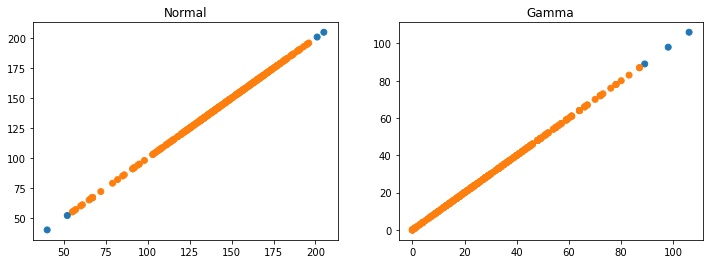

array: 105


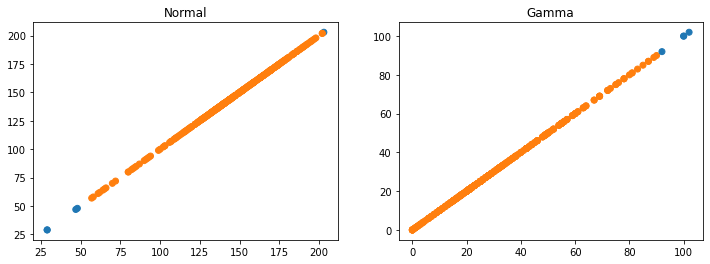

array: 106


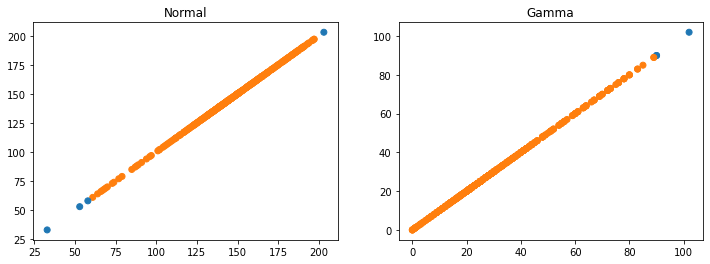

array: 107


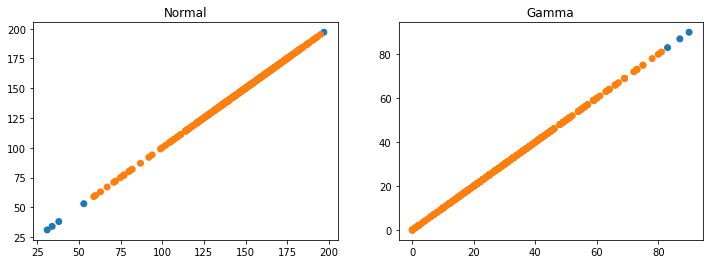

array: 108


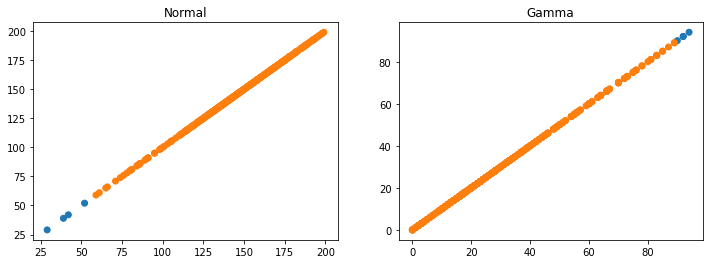

array: 109


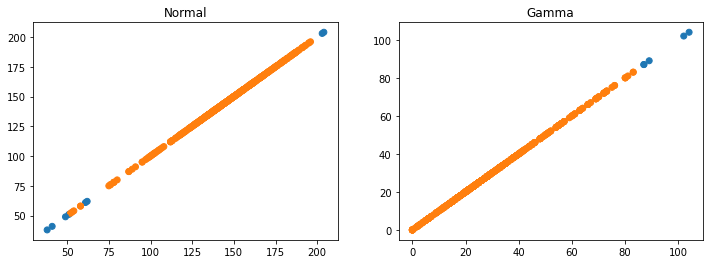

array: 110


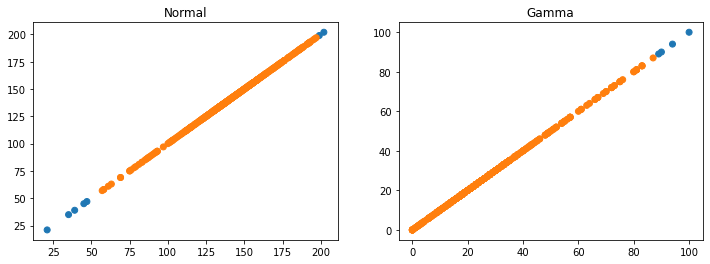

array: 111


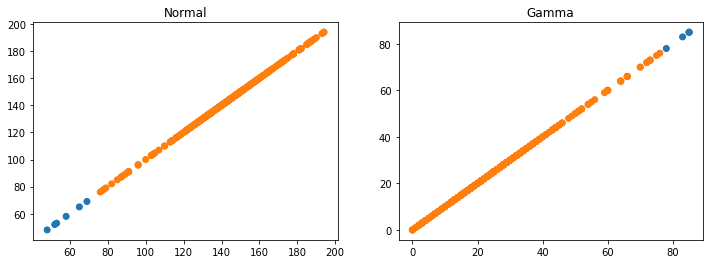

In [24]:
check_pred_labels(array_isof_normal, array_isof_gamma)

異常タイプの確認テスト

In [133]:
def remove_small_area(hot_pixels):
    gray = hot_pixels.astype(np.uint8)
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for cnt in contours:
        if cv2.contourArea(cnt) < 10:
            cv2.drawContours(gray, cnt, -1, color=(0,0,0), thickness=cv2.FILLED) 
    return gray

In [75]:
def get_hotspots_in_array(transformed_clusters_temperature, img_file, log=False):
    # -- hot cluster --
    hot_clusters = (transformed_clusters_temperature.mean(axis=1) > 2.0)
    # -- hot pixcel --
    #hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = np.array([1 if c in np.where(hot_clusters==True)[0] else 0 for c in clusters.labels]) 
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1)
    hot_pixels = remove_small_area(remove_small_area(hot_pixels))
    if log:
        print("Hot cluster labels in array:",hot_clusters)
        print("Hotspot weights in array:",hot_pixels.mean())
    return hot_pixels, hot_clusters

In [76]:
def get_hotspots_in_module(
    scaled_clusters_temperature, transformed_clusters_temperature, img_file, log=False):
    # -- hot cluster --
    hot_clusters = (scaled_clusters_temperature.mean(axis=1) > 2.5) \
    & (transformed_clusters_temperature.mean(axis=1) > 0)
    # -- hot pixel --
    #hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = np.array([1 if c in np.where(hot_clusters==True)[0] else 0 for c in clusters.labels]) 
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1)    
    hot_pixels = remove_small_area(remove_small_area(hot_pixels))
    if log:
        print("Hot cluster labels in module:",hot_clusters)
        print("Hotspot weights in module:",hot_pixels.mean())
    return hot_pixels, hot_clusters

In [77]:
def get_hotspots_by_models(
    original_clusters_temperature, transformed_clusters_temperature, model, img_file, log=False):
    # -- hot cluster --
    hot_clusters = (model.predict(original_clusters_temperature) < 0) \
    & (transformed_clusters_temperature.mean(axis=1) > 0)
    #print(model.score_samples(original_clusters_temperature))
    #print(model.offset_)
    # -- hot pixel --
    #hot_pixels = np.array([c in np.where(hot_clusters==True)[0] for c in clusters.labels])
    hot_pixels = np.array([1 if c in np.where(hot_clusters==True)[0] else 0 for c in clusters.labels])    
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1) 
    hot_pixels = remove_small_area(remove_small_area(hot_pixels))
    return hot_pixels, hot_clusters

63.jpg
823.jpg
4217.jpg
3578.jpg
2666.jpg
5109.jpg
2100.jpg
4571.jpg
1409.jpg
189.jpg
2114.jpg
4565.jpg
4203.jpg
2672.jpg
2672.jpg Single-Hotspot


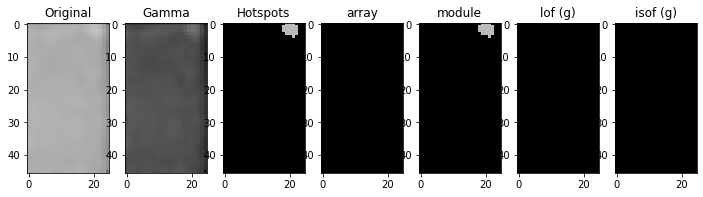

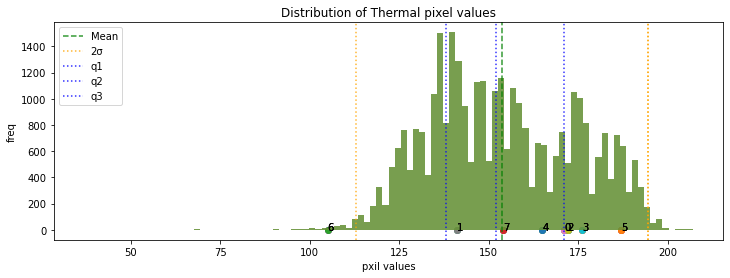

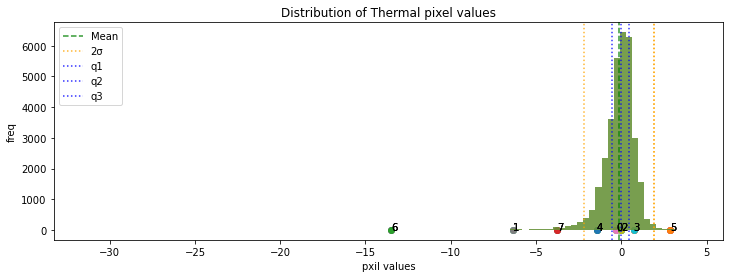

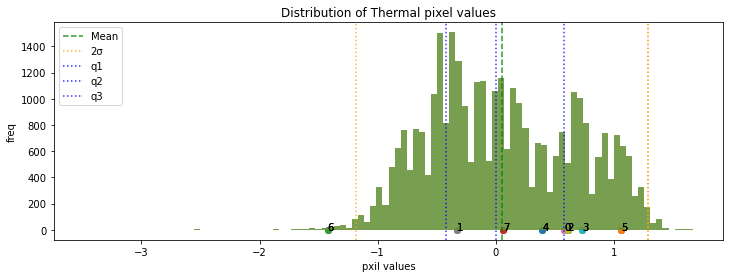

77.jpg
837.jpg
2882.jpg
3544.jpg
5135.jpg
1353.jpg
1435.jpg
3222.jpg
2128.jpg
3236.jpg
4559.jpg
1421.jpg
1421.jpg Single-Hotspot


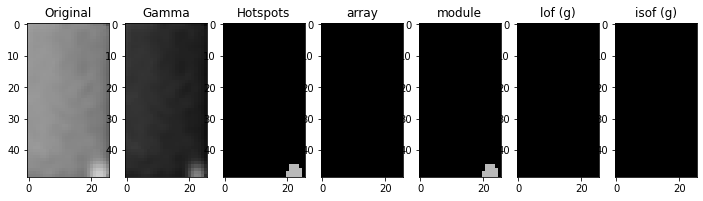

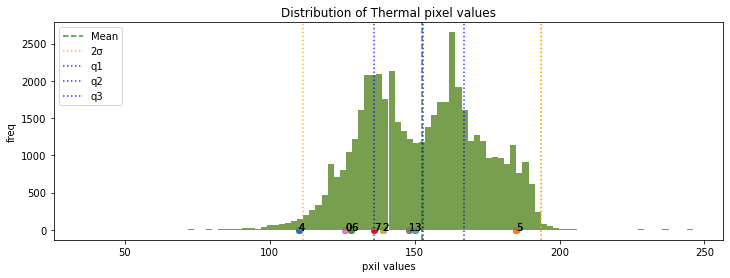

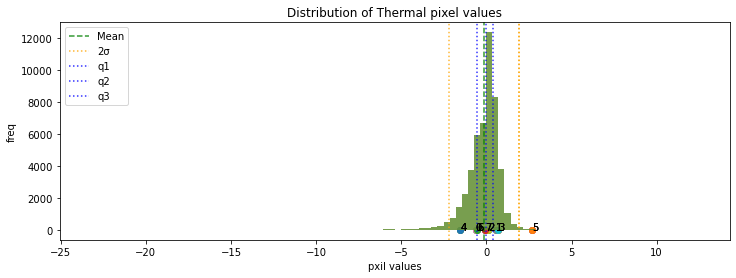

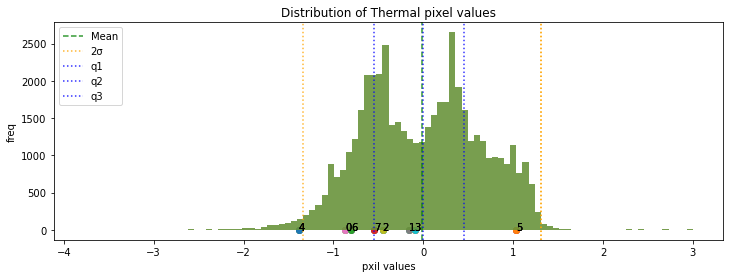

1347.jpg
2896.jpg
3550.jpg
5121.jpg
638.jpg
2869.jpg
1390.jpg
604.jpg
2699.jpg
2841.jpg
3587.jpg
162.jpg
176.jpg
2855.jpg
3593.jpg
88.jpg
610.jpg
1384.jpg
4773.jpg
2302.jpg
2464.jpg
4015.jpg
1179.jpg
2470.jpg
4001.jpg
4767.jpg
3008.jpg
2316.jpg
3020.jpg
4997.jpg
1637.jpg
1151.jpg
2458.jpg
3746.jpg
4029.jpg
3752.jpg
3752.jpg Single-Hotspot


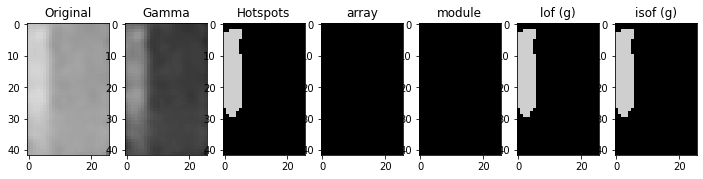

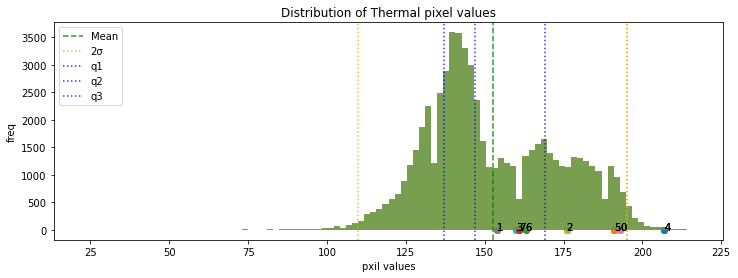

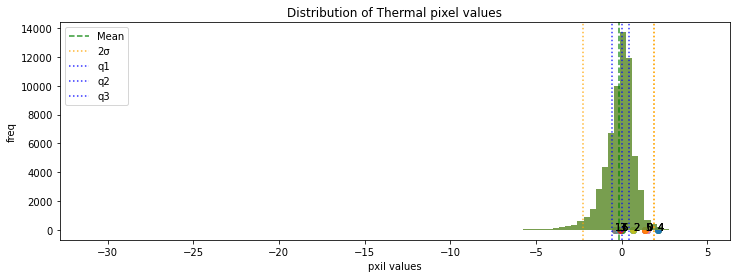

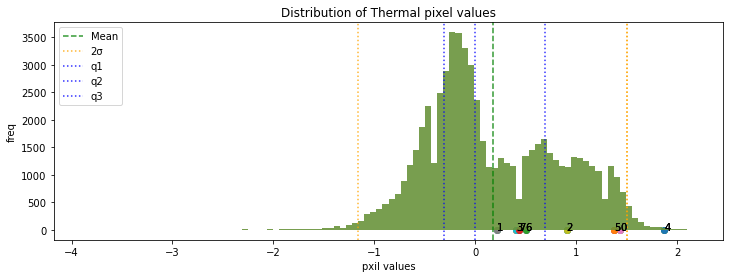

1145.jpg
1623.jpg
3034.jpg
4983.jpg
4968.jpg
1810.jpg
3961.jpg
3975.jpg
1804.jpg
348.jpg
360.jpg
4954.jpg
3785.jpg
3785.jpg Single-Hotspot


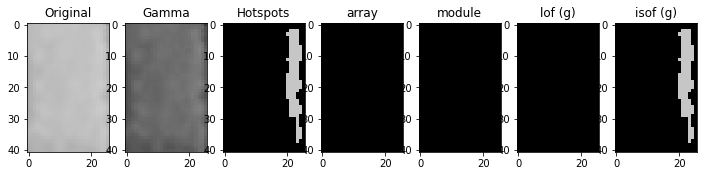

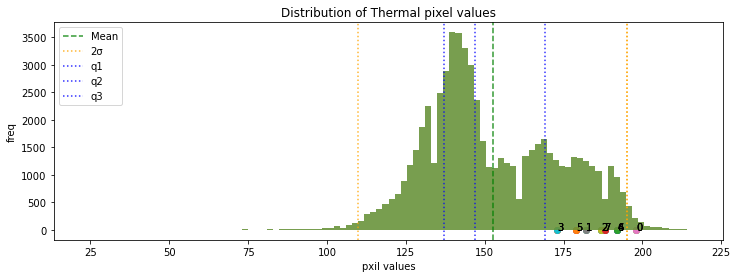

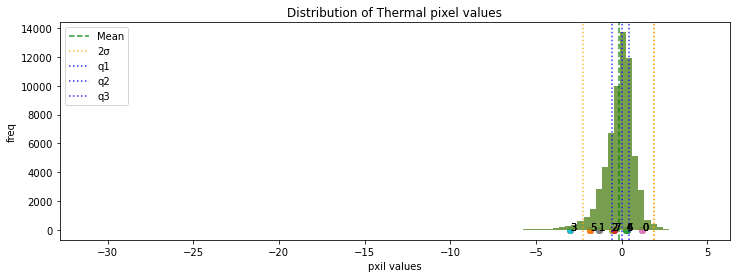

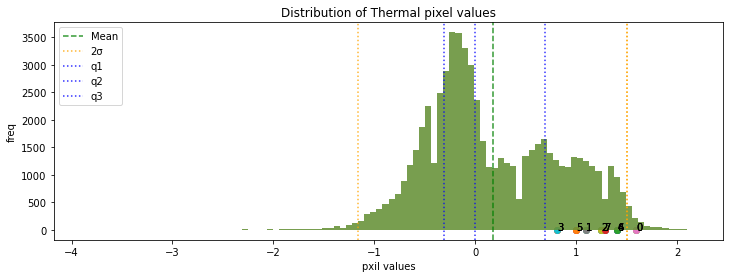

406.jpg
1192.jpg
1186.jpg
412.jpg
3791.jpg
3949.jpg
4940.jpg
4798.jpg
1838.jpg
374.jpg
2276.jpg
3168.jpg
4607.jpg
4161.jpg
2510.jpg
1019.jpg
599.jpg
4175.jpg
2504.jpg
2262.jpg
2262.jpg Multi-Hotspots


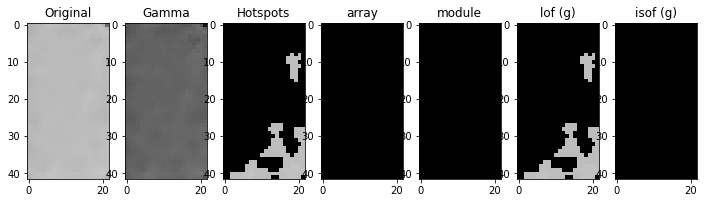

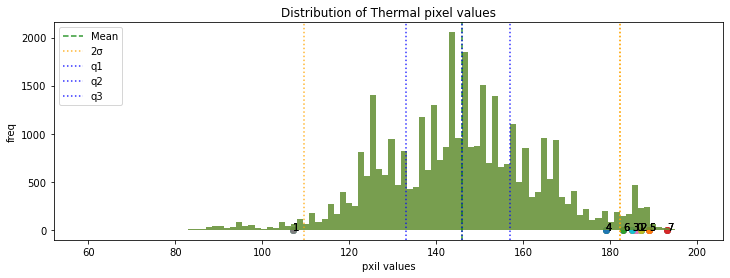

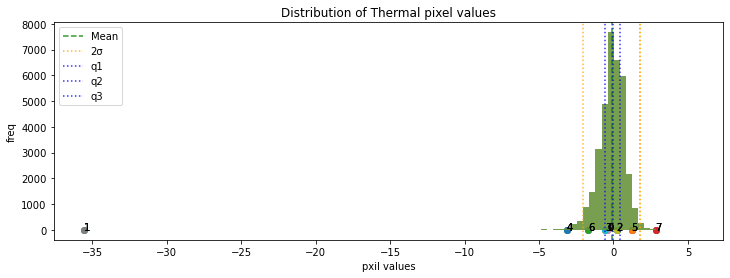

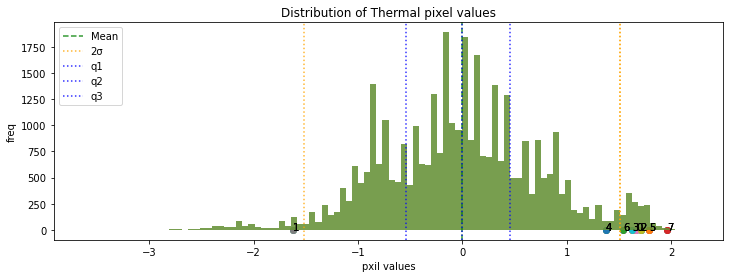

4613.jpg
3154.jpg
1743.jpg
1025.jpg
3632.jpg
3632.jpg Single-Hotspot


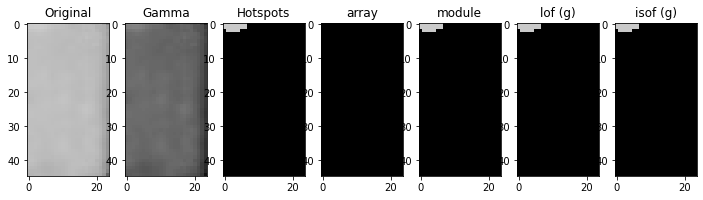

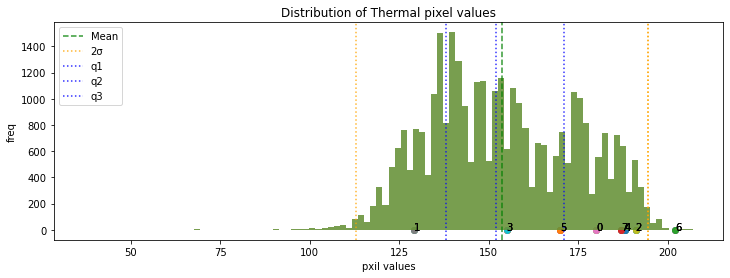

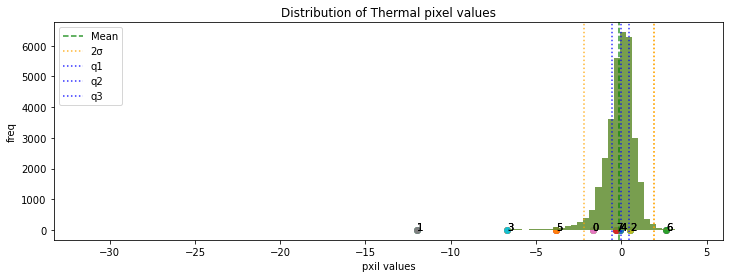

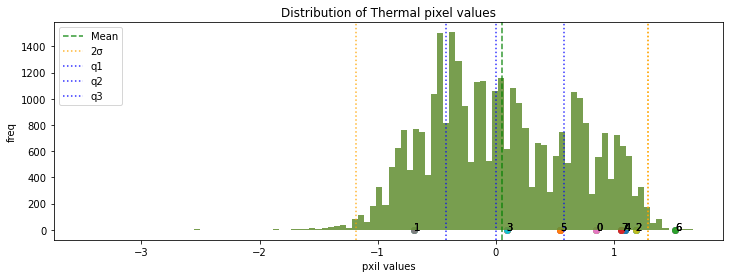

In [134]:
anomaly_modules= {}
os.makedirs(input_dir_path+"/hist/",exist_ok=True)
#for n, k in enumerate(list(thermal_img_files)[:100]):
for n, k in enumerate(list(thermal_img_files)):    
    # -- module label --
    print(k)
    l = module_labels[n]
    if l == -1:
        pass
    else:
        # -- cluster temperature ---
        clusters = clustering.TemperatureClusters(
            data_array[l].scaled_temperature_with_index[k], method=clustering_method)  
        # -- original cluster --
        sliced_data = clusters.get_clusters_data(data_array[l].temperature[k])    
        original_clusters_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in sliced_data])
        # -- scaled cluster --
        sliced_data = clusters.get_clusters_data(data_array[l].scaled_temperature[k])
        scaled_clusters_temperature = np.stack([t.mean(axis=0) for t in sliced_data ])
        # -- transformed temperature --
        transformed_clusters_temperature = array_zscaler[l].transform(
            original_clusters_temperature)
        gamma_clusters_temperature = gamma_correction(
            original_clusters_temperature, gamma=gamma)
        # -- anomaly detection --    
        hot_pixels_in_array, hot_clusters_in_array = get_hotspots_in_array(
            transformed_clusters_temperature, thermal_img_files[k], log=False) 
        hot_pixels_in_module, hot_clusters_in_module = get_hotspots_in_module(
            scaled_clusters_temperature, transformed_clusters_temperature, 
            thermal_img_files[k], log=False)
        hot_pixels_lof_normal, hot_clusters_lof_normal = get_hotspots_by_models(
            original_clusters_temperature, transformed_clusters_temperature,
            array_lof_normal[l], thermal_img_files[k], log=False)        
        hot_pixels_isof_normal, hot_clusters_isof_normal = get_hotspots_by_models(
            original_clusters_temperature, transformed_clusters_temperature,
            array_isof_normal[l], thermal_img_files[k], log=False)        
        hot_pixels_lof_gamma, hot_clusters_lof_gamma = get_hotspots_by_models(
            gamma_clusters_temperature, transformed_clusters_temperature,
            array_lof_gamma[l], thermal_img_files[k], log=False)
        hot_pixels_isof_gamma, hot_clusters_isof_gamma = get_hotspots_by_models(
            gamma_clusters_temperature, transformed_clusters_temperature,
            array_isof_gamma[l], thermal_img_files[k], log=False)
        hot_pixels = (
            hot_pixels_in_array
            | hot_pixels_in_module
            | hot_pixels_lof_gamma
            | hot_pixels_isof_gamma
        )
        hot_clusters = (
            hot_clusters_in_array 
            | hot_clusters_in_module 
            | hot_clusters_lof_gamma
            | hot_clusters_isof_gamma
        )
        module_type = anomaly_detection.detect_module_type(hot_clusters, hot_pixels, clusters)
        # -- save anomaly modules --
        if module_type not in anomaly_modules:
            anomaly_modules[module_type] = [k]
        else:
            anomaly_modules[module_type].append(k)
        if module_type != "Normal":
            # -- display -- 
            img_clustered = original_clusters_temperature[clusters.labels].reshape(thermal_img_files[k].shape)
            img_hotspots = img_clustered * hot_pixels
            img_hotspots_in_array = img_clustered * hot_pixels_in_array
            img_hotspots_in_module = img_clustered * hot_pixels_in_module
            img_hotspots_lof_normal = img_clustered * hot_pixels_lof_normal
            img_hotspots_lof_gamma = img_clustered * hot_pixels_lof_gamma
            img_hotspots_isof_normal = img_clustered * hot_pixels_isof_normal
            img_hotspots_isof_gamma = img_clustered * hot_pixels_isof_gamma
            print(k, module_type)
            display.display_modules({
                "Original": thermal_img_files[k], 
                "Gamma": gamma_correction(thermal_img_files[k], gamma=gamma), 
                "Hotspots": img_hotspots,
                "array": img_hotspots_in_array,
                "module": img_hotspots_in_module,
                #"lof (n)": img_hotspots_lof_normal,
                "lof (g)": img_hotspots_lof_gamma,
                #"isof (n)": img_hotspots_isof_normal,
                "isof (g)": img_hotspots_isof_gamma 
            })
            display.display_distributions(
                data_array[l].all_temperature,            
                filepath = input_dir_path+"/hist/hist_original_" + k,
                cluster_centers = original_clusters_temperature
            )
            display.display_distributions(
                data_array[l].scaled_all_temperature, 
                filepath = input_dir_path+"/hist/hist_scaled_" + k,
                cluster_centers = scaled_clusters_temperature
            )    
            display.display_distributions(
                array_zscaler[l].transform(data_array[l].all_temperature),
                filepath = input_dir_path+"/hist/hist_transformed_" + k,
                cluster_centers = transformed_clusters_temperature
            )      

In [30]:
list_anomaly_modules = [
    "190.jpg", 
    "320.jpg", 
    "351.jpg ",
    "737.jpg",     
    "899.jpg", 
    "923.jpg", 
    "1270.jpg", 
    "1408.jpg", 
    "1561.jpg"
    "1669.jpg"    
    "1853.jpg"        
    "1991.jpg", 
    "2078.jpg", 
    "2139.jpg",     
    "2195.jpg",     
    "3283.jpg",     
    "3672.jpg", 
    "3752.jpg", 
    "4567.jpg",     
    "4655.jpg",     
    "4700.jpg",     
    "5017.jpg",     
    "5079.jpg",     
    "5151.jpg",     
]

In [31]:
list_other_modules = [
    "1713.jpg",
    "1787.jpg",
    "1748.jpg",
    "1798.jpg",
    "1812.jpg",    
    "1848.jpg",    
    "1890.jpg",        
]

3752.jpg Single-Hotspot


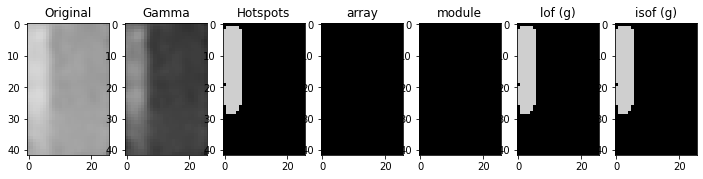

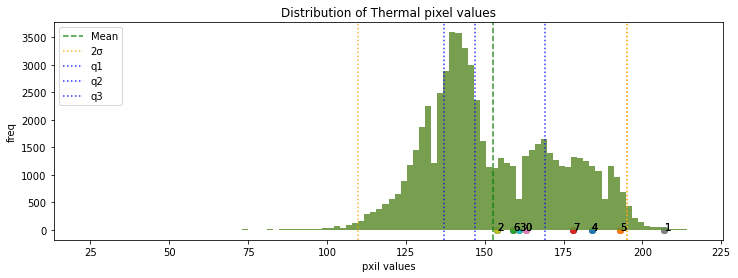

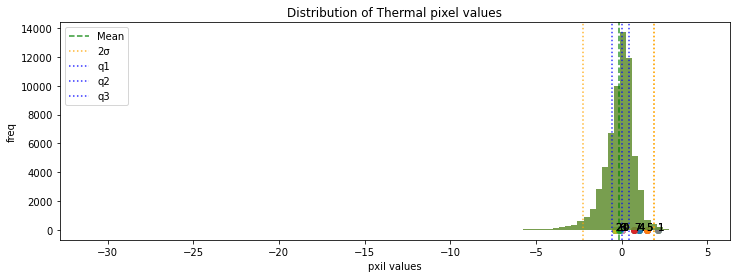

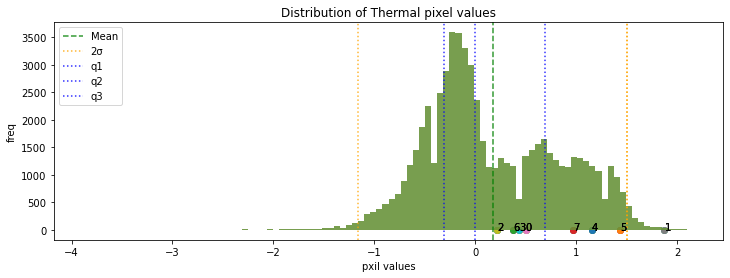

1408.jpg Single-Hotspot


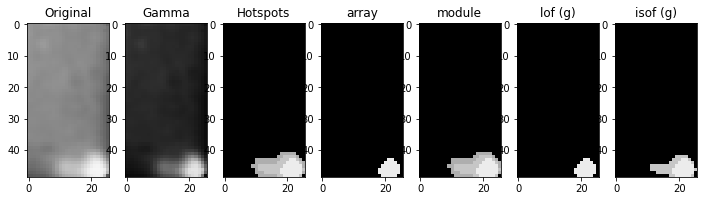

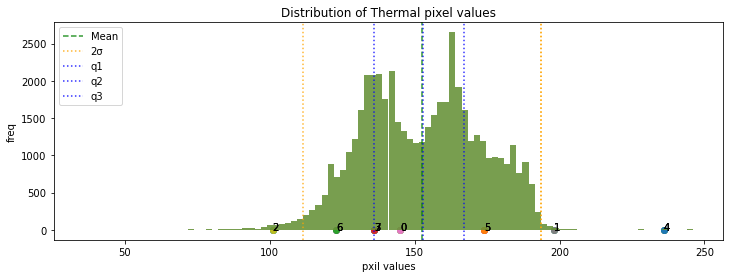

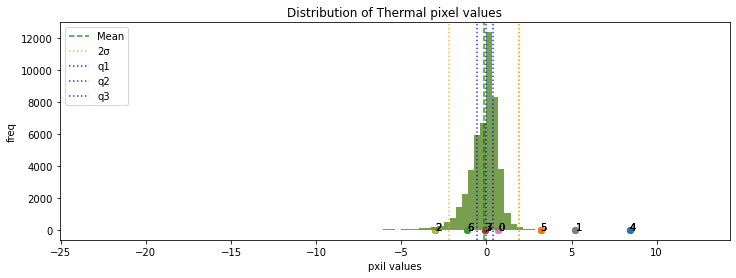

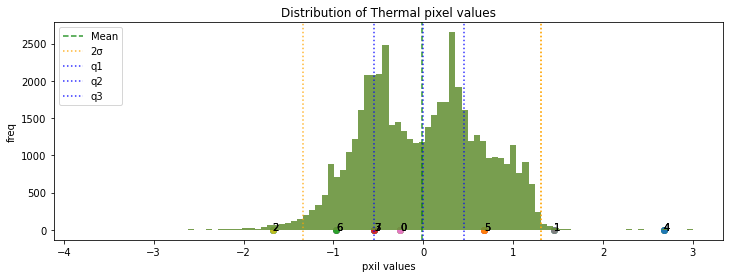

4567.jpg Single-Hotspot


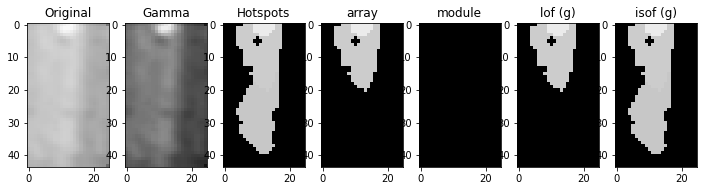

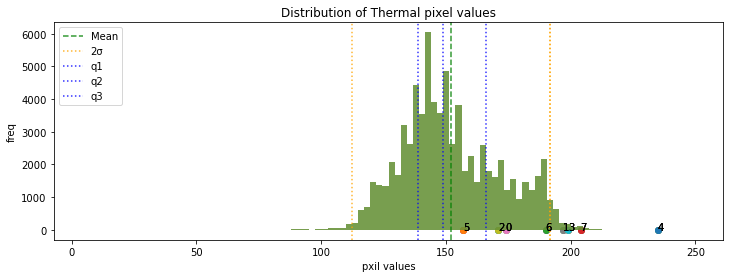

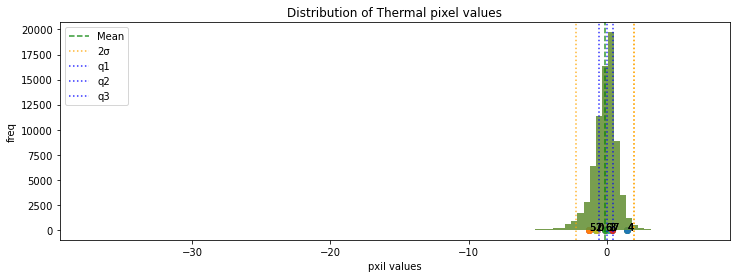

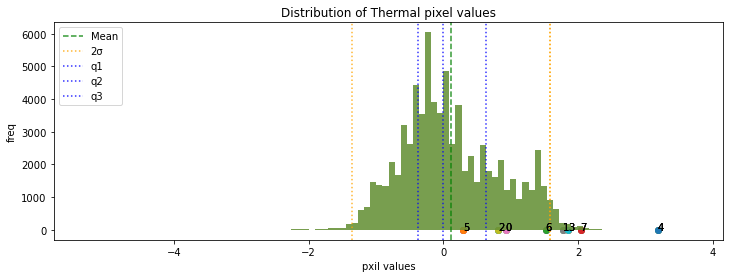

2139.jpg Single-Hotspot


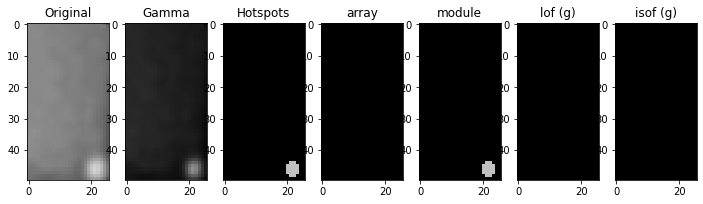

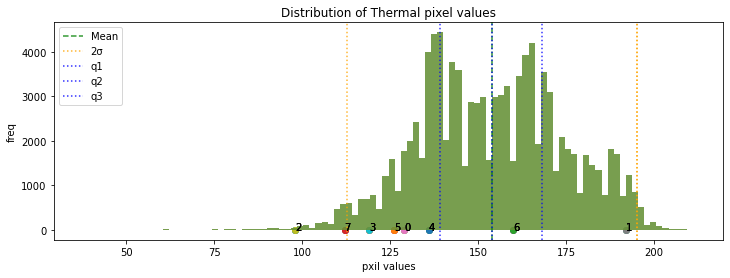

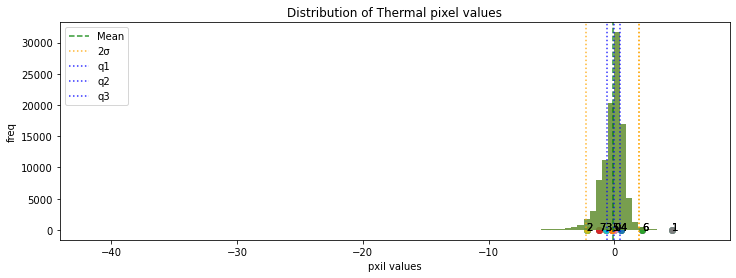

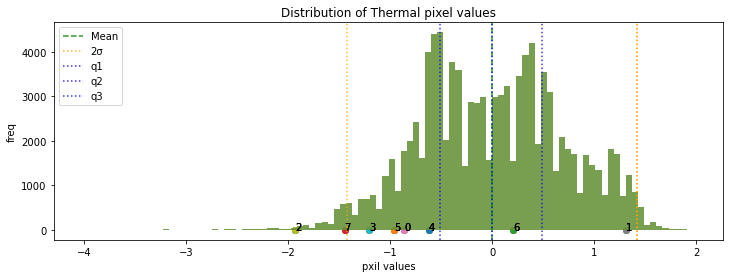

5079.jpg Single-Hotspot


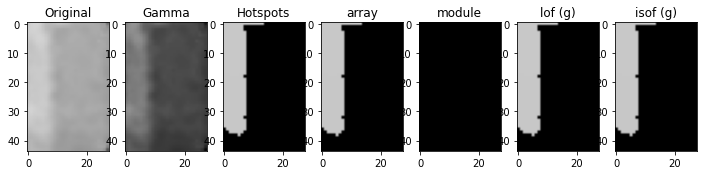

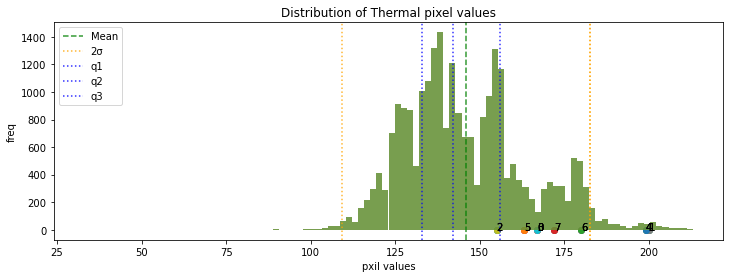

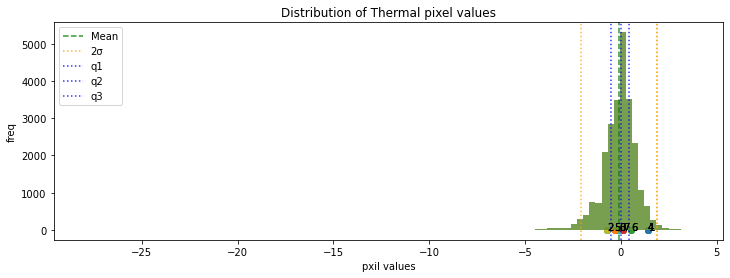

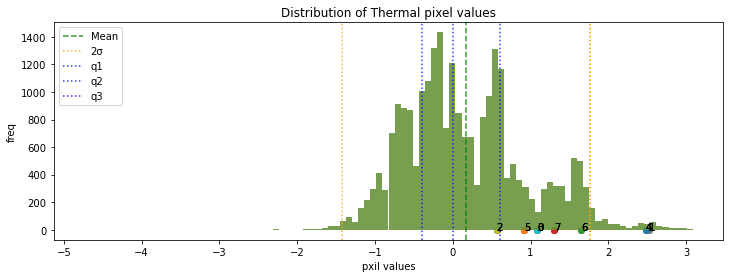

3283.jpg Cluster-Anomaly


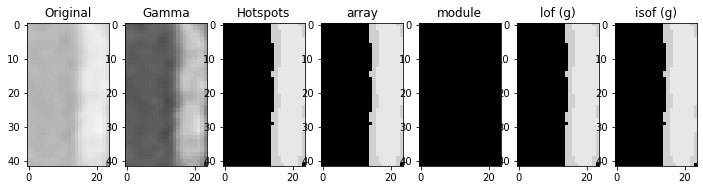

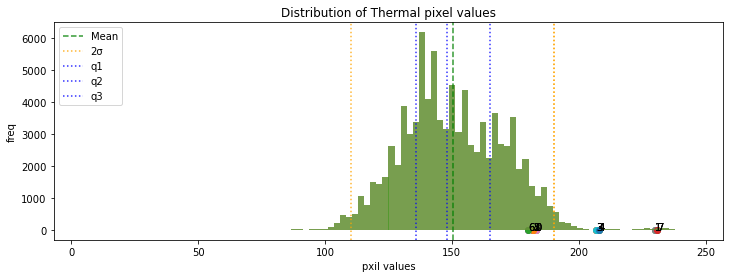

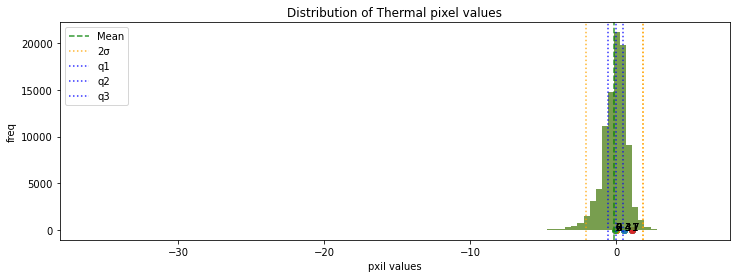

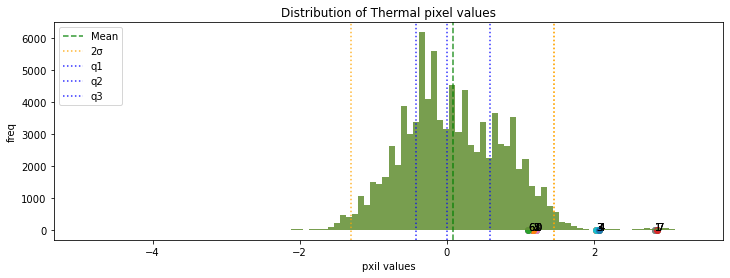

923.jpg Single-Hotspot


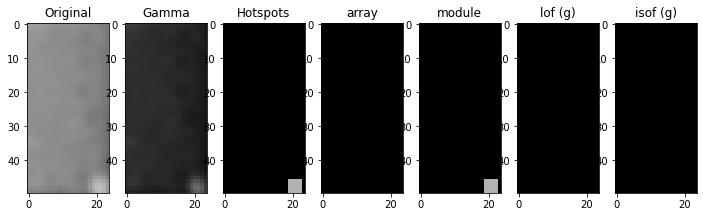

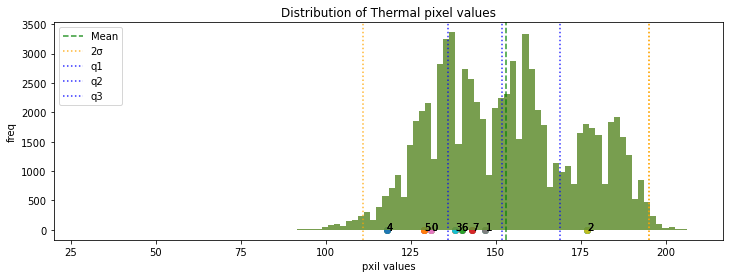

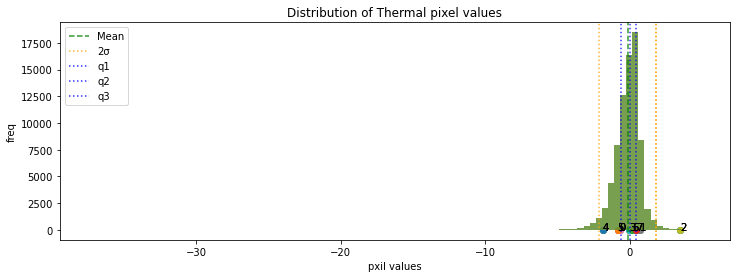

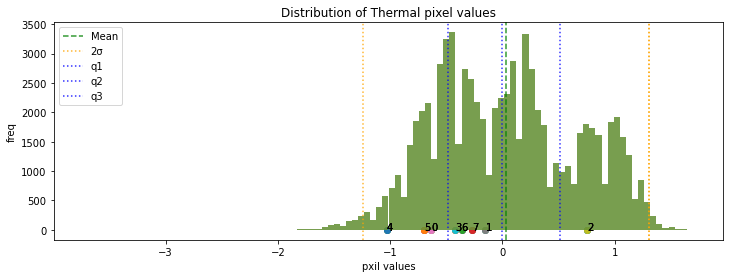

5151.jpg Single-Hotspot


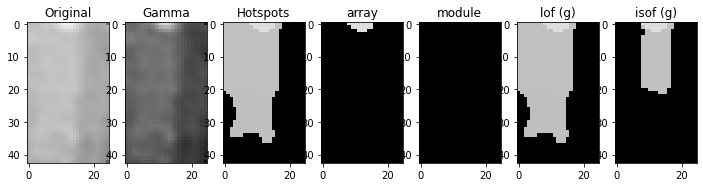

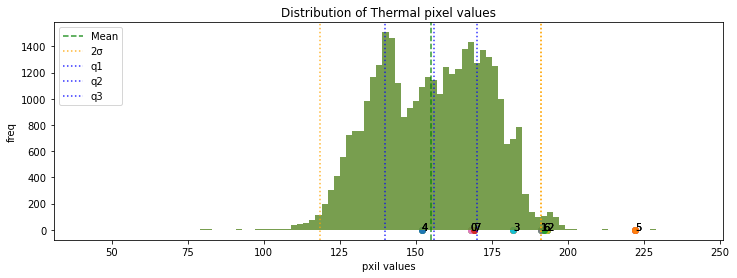

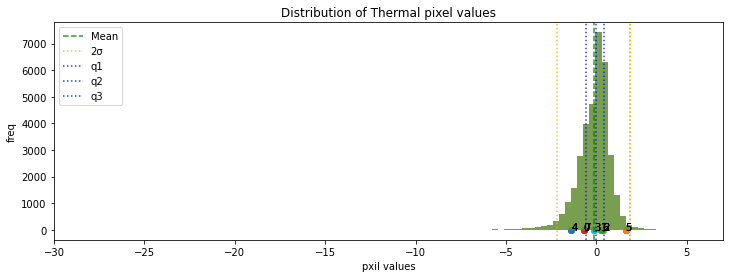

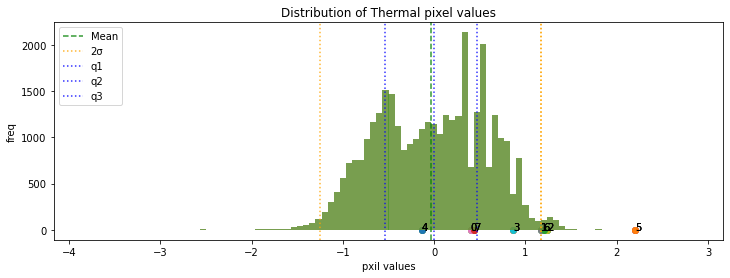

4700.jpg Multi-Hotspots


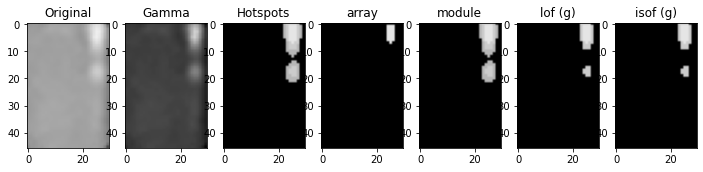

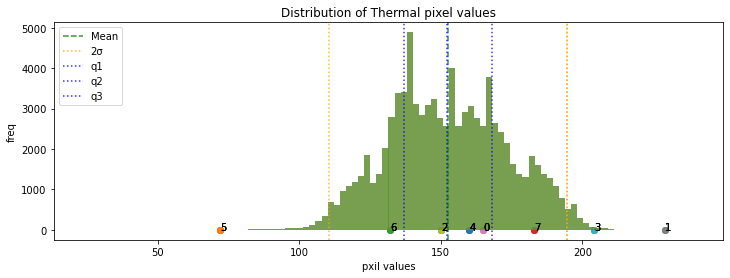

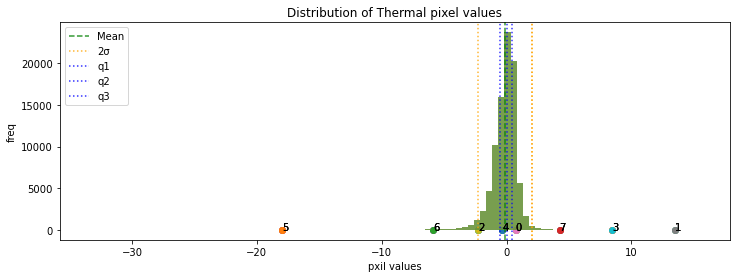

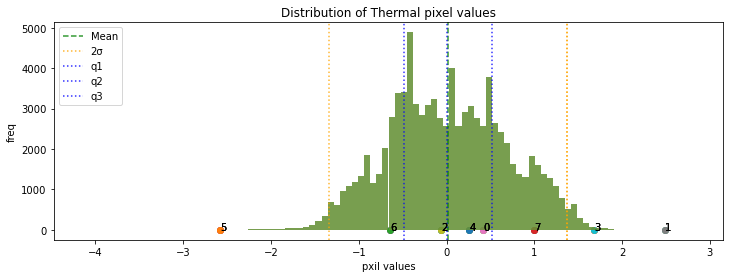

2195.jpg Normal


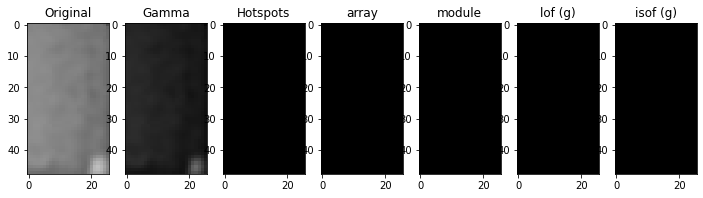

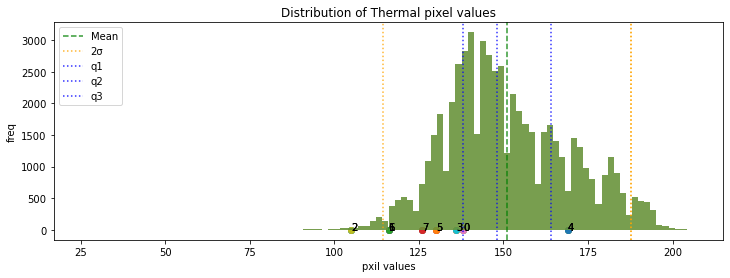

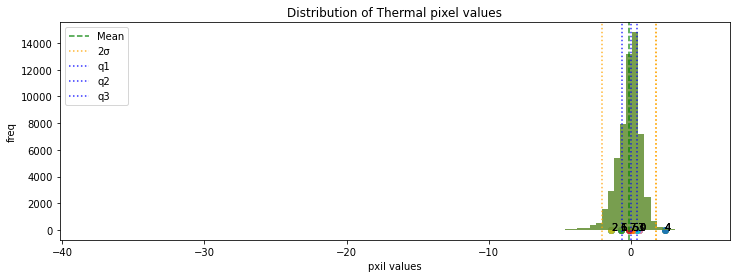

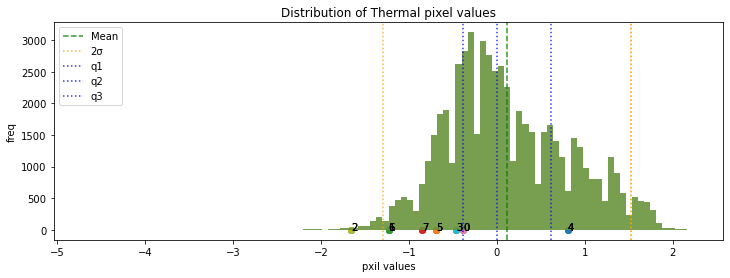

5017.jpg Single-Hotspot


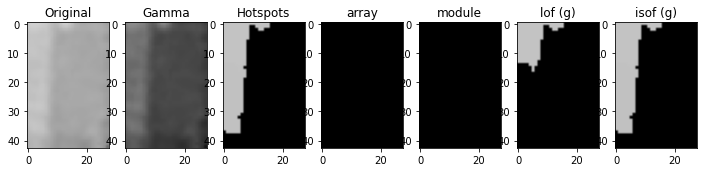

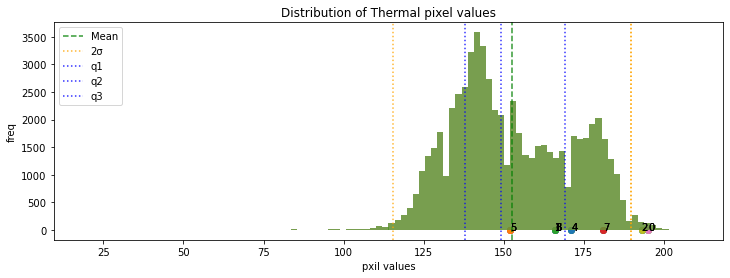

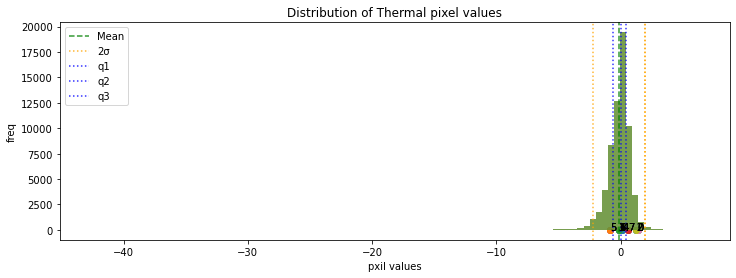

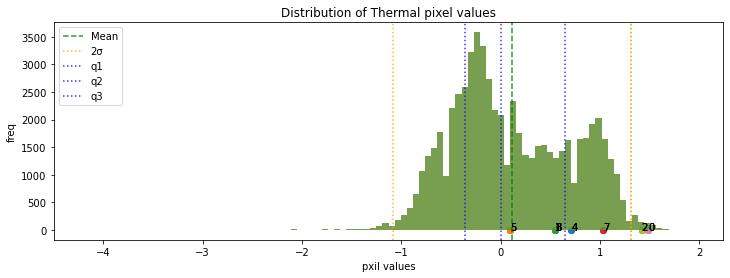

1270.jpg Single-Hotspot


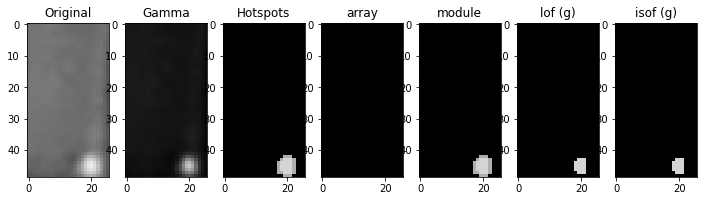

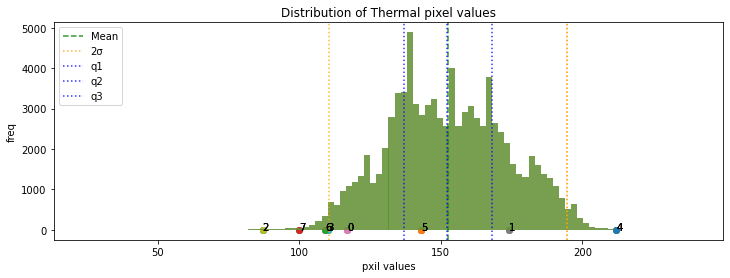

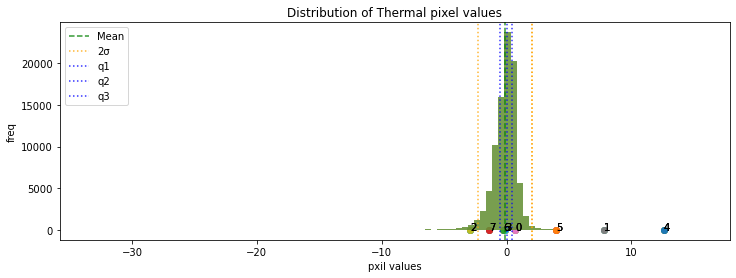

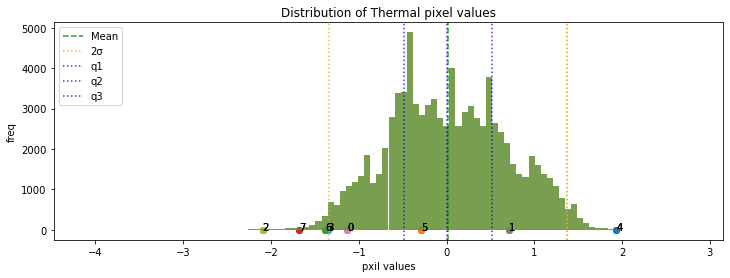

3672.jpg Single-Hotspot


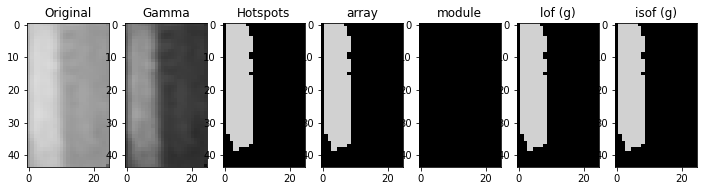

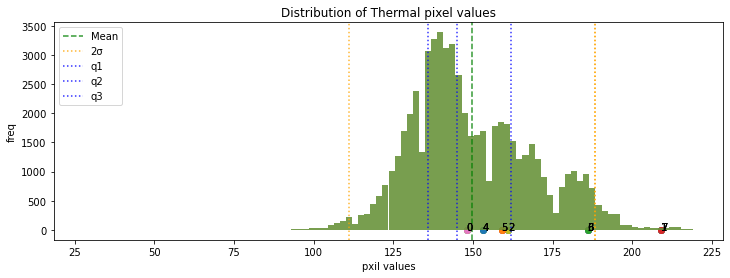

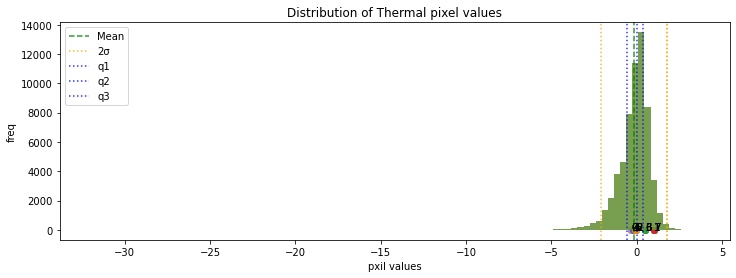

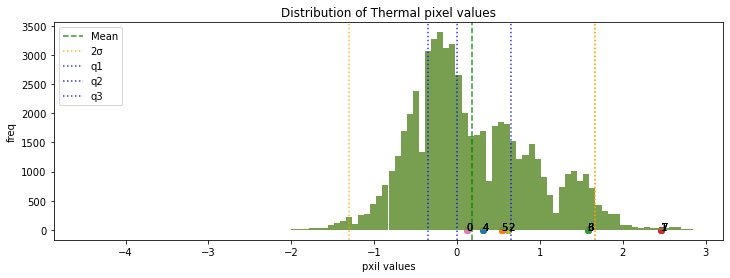

320.jpg Single-Hotspot


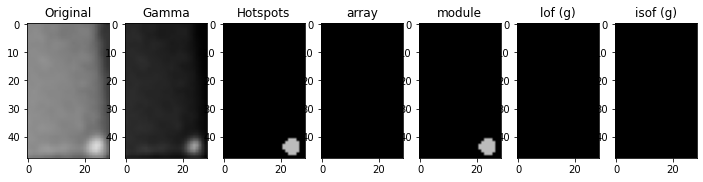

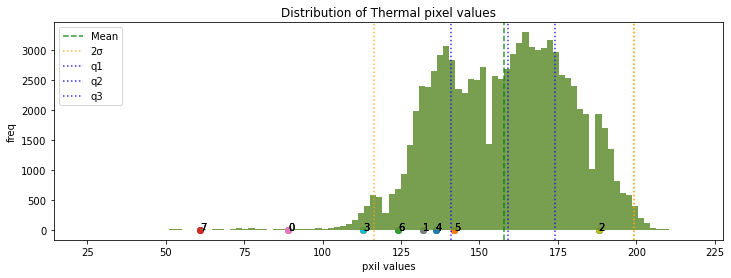

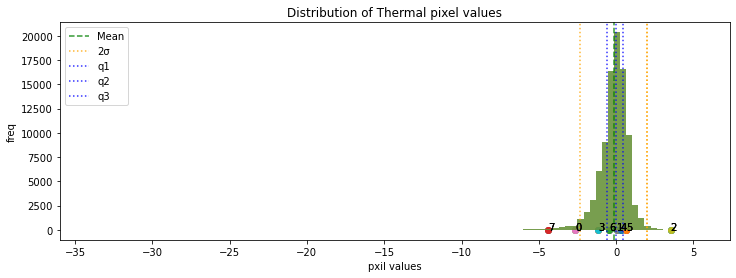

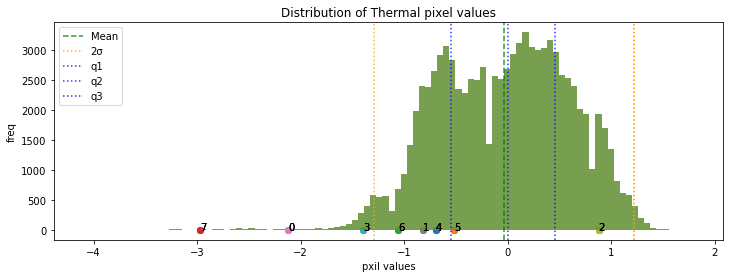

899.jpg Single-Hotspot


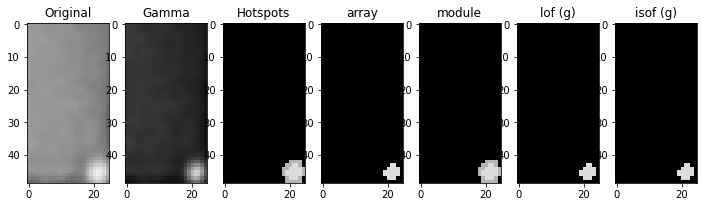

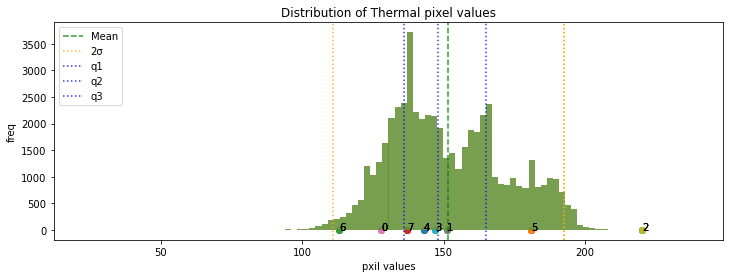

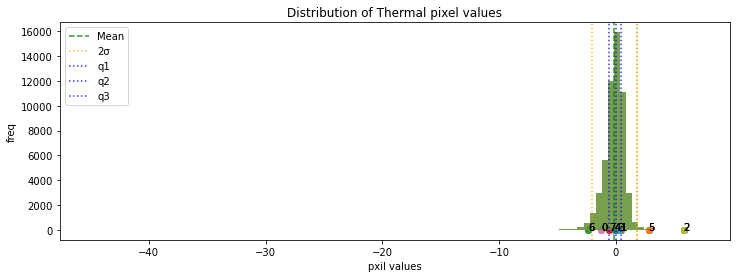

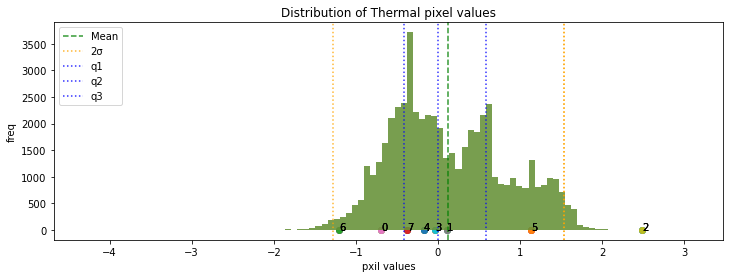

737.jpg Single-Hotspot


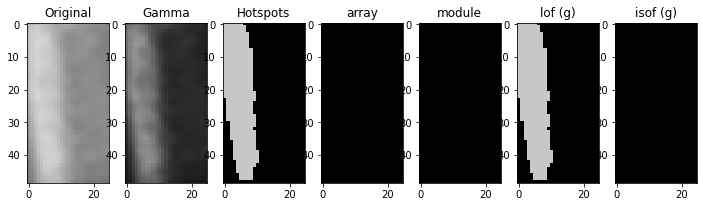

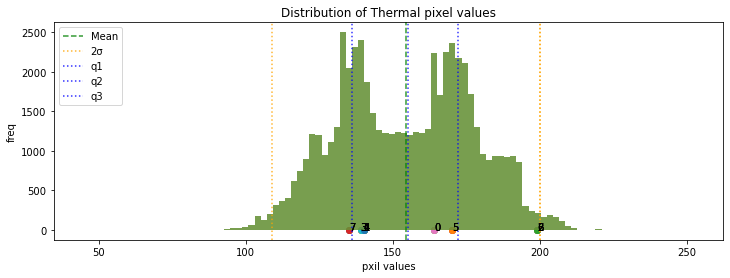

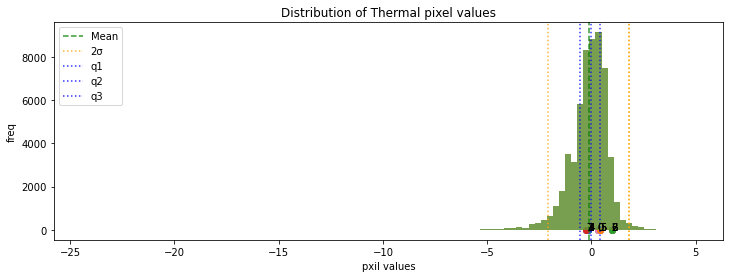

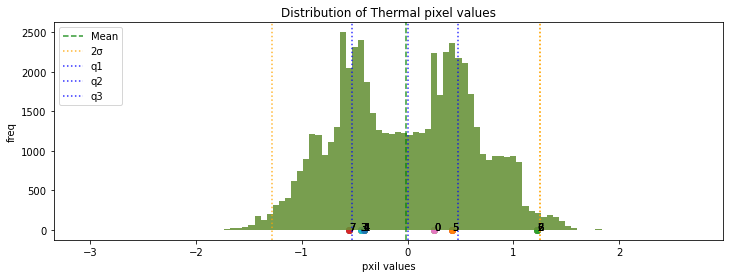

4655.jpg Single-Hotspot


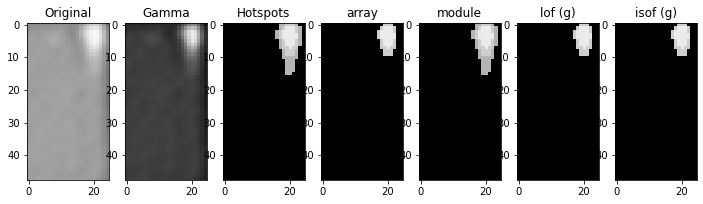

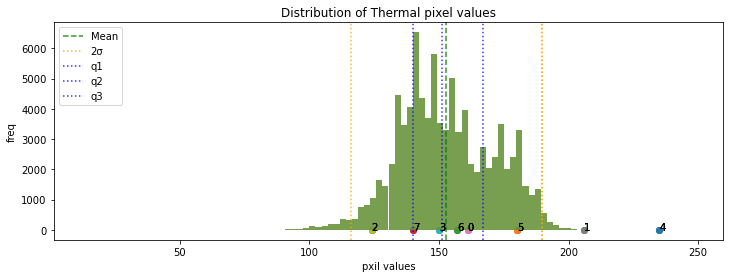

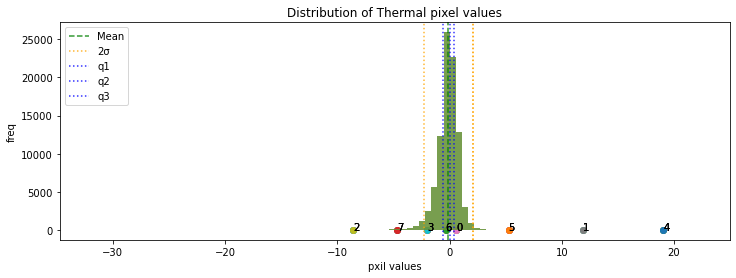

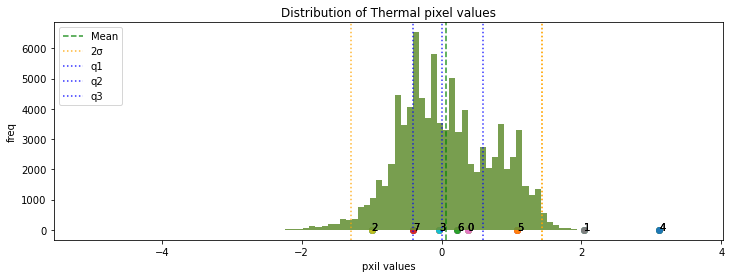

2078.jpg Single-Hotspot


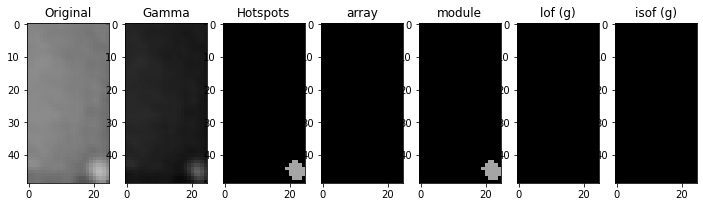

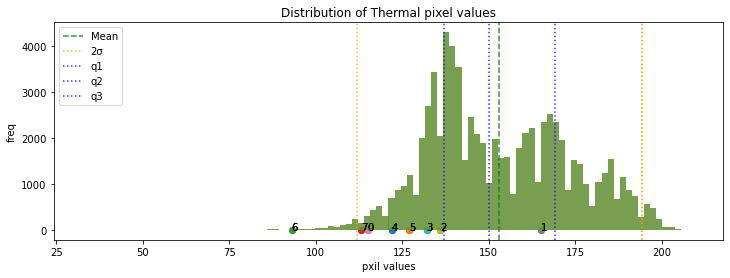

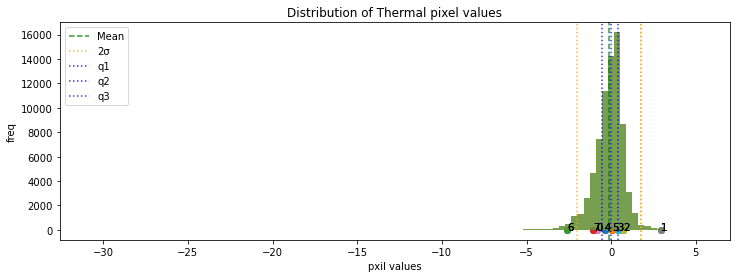

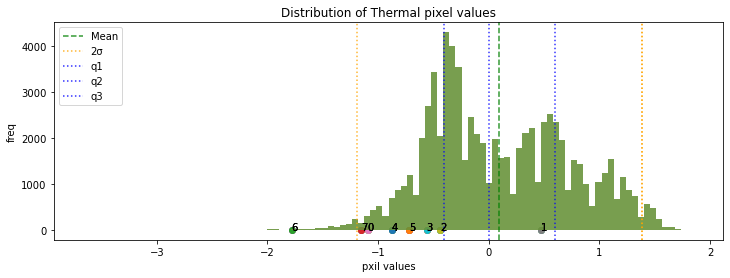

190.jpg Single-Hotspot


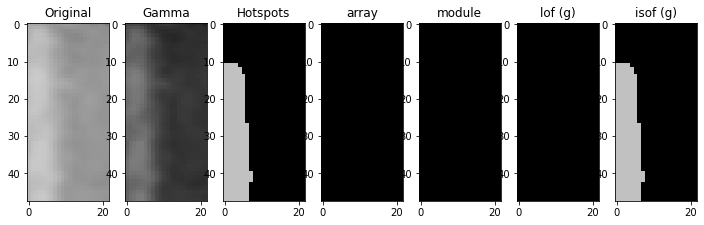

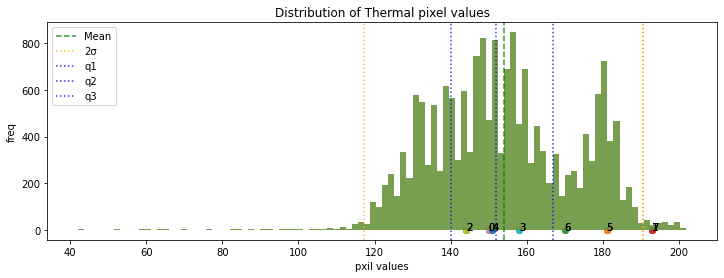

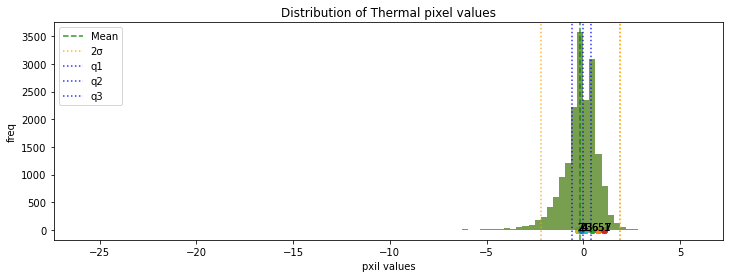

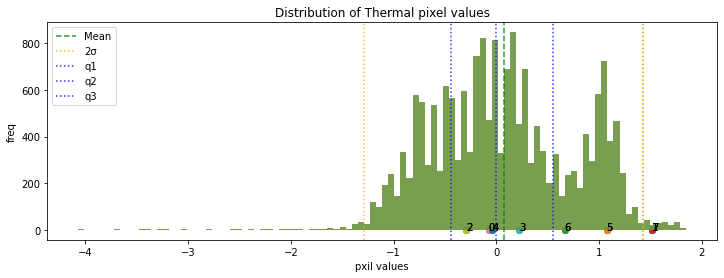

In [131]:
for n, k in enumerate(list(thermal_img_files)):    
    # -- module label --
    l = module_labels[n]
    if l == -1:
        pass
    elif k in list_anomaly_modules:
    #elif k in list_other_modules: 
    #elif k in ['923.jpg']:
        # -- cluster temperature ---
        clusters = clustering.TemperatureClusters(
            data_array[l].scaled_temperature_with_index[k], method=clustering_method)  
        # -- original cluster --
        sliced_data = clusters.get_clusters_data(data_array[l].temperature[k])    
        original_clusters_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in sliced_data])
        # -- scaled cluster --
        sliced_data = clusters.get_clusters_data(data_array[l].scaled_temperature[k])
        scaled_clusters_temperature = np.stack([t.mean(axis=0) for t in sliced_data ])
        # -- transformed temperature --
        transformed_clusters_temperature = array_zscaler[l].transform(
            original_clusters_temperature)
        gamma_clusters_temperature = gamma_correction(
            original_clusters_temperature, gamma=gamma)
        # -- anomaly detection --    
        hot_pixels_in_array, hot_clusters_in_array = get_hotspots_in_array(
            transformed_clusters_temperature, thermal_img_files[k], log=False) 
        hot_pixels_in_module, hot_clusters_in_module = get_hotspots_in_module(
            scaled_clusters_temperature, transformed_clusters_temperature, 
            thermal_img_files[k], log=False)
        hot_pixels_lof_normal, hot_clusters_lof_normal = get_hotspots_by_models(
            original_clusters_temperature, transformed_clusters_temperature,
            array_lof_normal[l], thermal_img_files[k], log=False)        
        hot_pixels_isof_normal, hot_clusters_isof_normal = get_hotspots_by_models(
            original_clusters_temperature, transformed_clusters_temperature,
            array_isof_normal[l], thermal_img_files[k], log=False)        
        hot_pixels_lof_gamma, hot_clusters_lof_gamma = get_hotspots_by_models(
            gamma_clusters_temperature, transformed_clusters_temperature,
            array_lof_gamma[l], thermal_img_files[k], log=False)
        hot_pixels_isof_gamma, hot_clusters_isof_gamma = get_hotspots_by_models(
            gamma_clusters_temperature, transformed_clusters_temperature,
            array_isof_gamma[l], thermal_img_files[k], log=False)
        hot_pixels = (
            hot_pixels_in_array
            | hot_pixels_in_module
            | hot_pixels_lof_gamma
            | hot_pixels_isof_gamma
        )
        hot_clusters = (
            hot_clusters_in_array 
            | hot_clusters_in_module 
            | hot_clusters_lof_gamma
            | hot_clusters_isof_gamma
        )
        module_type = anomaly_detection.detect_module_type(hot_clusters, hot_pixels, clusters)
        # -- save anomaly modules --
        if module_type not in anomaly_modules:
            anomaly_modules[module_type] = [k]
        else:
            anomaly_modules[module_type].append(k)        
        # -- display -- 
        img_clustered = original_clusters_temperature[clusters.labels].reshape(thermal_img_files[k].shape)
        img_hotspots = img_clustered * hot_pixels
        img_hotspots_in_array = img_clustered * hot_pixels_in_array
        img_hotspots_in_module = img_clustered * hot_pixels_in_module
        img_hotspots_lof_normal = img_clustered * hot_pixels_lof_normal
        img_hotspots_lof_gamma = img_clustered * hot_pixels_lof_gamma
        img_hotspots_isof_normal = img_clustered * hot_pixels_isof_normal
        img_hotspots_isof_gamma = img_clustered * hot_pixels_isof_gamma    
        print(k, module_type)
        display.display_modules({
            "Original": thermal_img_files[k], 
            "Gamma": gamma_correction(thermal_img_files[k], gamma=gamma), 
            "Hotspots": img_hotspots,
            "array": img_hotspots_in_array,
            "module": img_hotspots_in_module,
            #"lof (n)": img_hotspots_lof_normal,
            "lof (g)": img_hotspots_lof_gamma,
            #"isof (n)": img_hotspots_isof_normal,
            "isof (g)": img_hotspots_isof_gamma 
        })
        display.display_distributions(
            data_array[l].all_temperature,            
            filepath = input_dir_path+"/hist/hist_original_" + k,
            cluster_centers = original_clusters_temperature
        )
        display.display_distributions(
            data_array[l].scaled_all_temperature, 
            filepath = input_dir_path+"/hist/hist_scaled_" + k,
            cluster_centers = scaled_clusters_temperature
        )    
        display.display_distributions(
            array_zscaler[l].transform(data_array[l].all_temperature),
            filepath = input_dir_path+"/hist/hist_transformed_" + k,
            cluster_centers = transformed_clusters_temperature
        )    

異常モジュールデータの保存

In [ ]:
import json
with open(input_dir_path+"/anomaly_modules.json", "w") as f:
    json.dump(anomaly_modules, f, indent=4, sort_keys=True, separators=(',', ': '))

In [ ]:
with open(input_dir_path+"/anomaly_modules.json", "r") as f:
    anomaly_modules = json.load(f)

モジュール可視化

In [ ]:
modules = Modules(module_contours)

In [ ]:
img_con_index = modules.get_img_contours(img_org, index=True)
module_extraction.show_img({"extracted modules":img_con_index},cmap="gray",figsize=(30,30))

In [ ]:
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
module_extraction.show_img({"extracted modules (overlay)":img_mask_index},cmap="gray",figsize=(30,30))

異常モジュール可視化

In [ ]:
anomaly_contours = modules.get_anomaly_contours(anomaly_modules)

In [ ]:
import copy
color_list = {
    "Single-Hotspot": (0,255,255), # aqua
    "Multi-Hotspots": (0,255,0), # green
    "Cluster-Anomaly": (255,255,0), # yellow
    "Module-Anomaly": (255,165,0), # orange
    "String-Anomaly": (238,130,238) # violet
}
img_target_index = copy.deepcopy(img_mask_index)
for k, v in anomaly_contours.items():
    if k == "Normal":
        continue
    else:
        img_target_index = modules.get_img_target_contours(
            img_target_index, v, index=True, color=color_list[k])
module_extraction.show_img(
    {"highlighted modules":img_target_index}, cmap="gray", figsize=(30,30)
)

In [ ]:
img_write = cv2.cvtColor(img_target_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(input_dir_path+'/img_target_index.png',img_write)

ストリング異常を含めた異常モジュール可視化

In [ ]:
if "Module-Anomaly" in anomaly_contours:
    string_anomaly_labels = modules.get_dbscan_labels(anomaly_contours["Module-Anomaly"])
    string_anomaly_modules = np.array(anomaly_modules["Module-Anomaly"])[string_anomaly_labels > 0]
    anomaly_modules["String-Anomaly"] = list(string_anomaly_modules )

In [ ]:
anomaly_contours = modules.get_anomaly_contours(anomaly_modules)

In [ ]:
img_target_index = copy.deepcopy(img_mask_index)
for k, v in anomaly_contours.items():
    if k == "Normal":
        continue
    else:
        img_target_index = modules.get_img_target_contours(
            img_target_index, v, index=True, color=color_list[k])
module_extraction.show_img(
    {"highlighted modules":img_target_index}, cmap="gray", figsize=(30,30)
)

In [ ]:
img_write = cv2.cvtColor(img_target_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(input_dir_path+'/img_target_w_string_index.png',img_write)

In [ ]:
with open(input_dir_path+"/anomaly_modules.json", "w") as f:
    json.dump(anomaly_modules, f, indent=4, sort_keys=True, separators=(',', ': '))